<a href="https://colab.research.google.com/github/ecohydro/DroughtEDM/blob/master/growing_season_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This repository contains functions for generating the prediction skill across East Africa on the Administrative Level 1 Level and computing a pixelwise evaluation of prediction skill using EDM across Africa for a given environmental variable

- To do: 
    - look at sensitivity of ED on spatial scale and then adjust pixelwise analysis so that it is using the optimal ED for each pixel
    - what to do about gaps in time series 
    
    
    http://maps.elie.ucl.ac.be/CCI/viewer/download/ESACCI-LC-QuickUserGuide-LC-Maps_v2-0-7.pdf

In [1]:
from pyEDM import *
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import geopandas as gpd
from shapely.geometry import Polygon
import rasterio
import xarray as xr
from mpl_toolkits.axes_grid1 import make_axes_locatable
import fiona
import rasterio.mask
from descartes import PolygonPatch
from rasterio.plot import show
from tqdm import tqdm
import datetime
import random
from sklearn.preprocessing import StandardScaler
import scipy.stats

In [ ]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
croplands_vars_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/VariablesByLandCover2016/Variables_Croplands/'
grasslands_vars_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/VariablesByLandCover2016/Variables_Grasslands/'
savannas_vars_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/VariablesByLandCover2016/Variables_Savannas/'
cropnatveg_vars_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/VariablesByLandCover2016/Variables_CropNatVeg/'
EA_TS_DIR = '/home/rgreen/DroughtEDM/Data/EA_TS/Final/'

Africa_simplex = '/home/rgreen/DroughtEDM/Data/Africa_simplex/' #out directory
seasonal_simplex = '/home/rgreen/DroughtEDM/Data/Seasonal_Simplex/'
Admin_boundaries = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/AdminBoundaries/'
prediction_skill_interval = '/home/rgreen/DroughtEDM/Data/Prediction_skill_interval/'
prediction_skill_ed = '/home/rgreen/DroughtEDM/Data/Prediction_skill_ed/'
prediction_skill_ed_anom_hh = '/home/rgreen/DroughtEDM/Data/Prediction_skill_ed/ndvi_anom_hh/'

EA_prediction_skill= '/home/rgreen/DroughtEDM/Data/EA_prediction_skill/'
pred_skill_clim = '/home/rgreen/DroughtEDM/Data/Prediction_skill_climatology/'
anomaly_maps = '/home/rgreen/DroughtEDM/Data/Anomaly_Maps/'

In [3]:

precip_ea = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/CHIRPS/EA/'
temp_ea = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/LST/EA/'
ndvi_ea = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/eMODIS_NDVI/EA/'

In [4]:
precip_anom_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/CHIRPS/Anomaly2/'
temp_anom_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/LST/Anomaly2/'
ndvi_anom_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/eMODIS_NDVI/Anomaly2/'

In [7]:
broadleaf_open_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/VariablesByLandCover16/variables_broadleaf_open/'
crop_irr_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/VariablesByLandCover16/variables_crop_irr/'
crop_rain_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/VariablesByLandCover16/variables_crop_rain/'
grassland_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/VariablesByLandCover16/variables_grassland/'
shrubland_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/VariablesByLandCover16/variables_shrubland/'

broadleaf_open_anom_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/VariablesByLandCover16/variables_broadleaf_open_anom/'
crop_irr_anom_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/VariablesByLandCover16/variables_crop_irr_anom/'
crop_rain_anom_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/VariablesByLandCover16/variables_crop_rain_anom/'
grassland_anom_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/VariablesByLandCover16/variables_grassland_anom/'
shrubland_anom_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/VariablesByLandCover16/variables_shrubland_anom/'

In [8]:
ea_adminbds = Admin_boundaries + 'gadm36_EastAfrica.shp'
ea_bndry = gpd.read_file(ea_adminbds)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
Africa_basemap = world[world['continent'] == 'Africa']
EA_countries = ['Burundi', 'Djibouti', 'Eritrea', 'Ethiopia', 'Kenya', 'Rwanda', 'Sudan', 'S. Sudan', 'Somalia', 'Somaliland', 'South Sudan', 'Tanzania', 'Uganda']
EastAfrica_basemap = world[world['name'].isin(EA_countries)]
EastAfrica_basemap.to_file(Admin_boundaries + 'EastAfrica_countries.shp')

In [9]:
def generate_dekads(start, end):
    '''
    Generates list of timestamps of dekads between two dates
    
    Parameters
    ----------
    start : pd.datetime object
        Start date of list
    end : pd.datetime object
        end date of list
    '''
    
    dtrange = pd.date_range(start, end)
    days = list(range(len(dtrange))) #length of dtrange
    daysDF = pd.DataFrame({'Days': days}, index=dtrange)
    d = daysDF.index.day - np.clip((daysDF.index.day-1) // 10, 0, 2)*10 - 1 
    dekaddates = daysDF.index.values - np.array(d, dtype="timedelta64[D]")
    dekads = daysDF.groupby(dekaddates).mean()
    dekads = dekads.index
    
    return dekads

In [10]:
start = pd.datetime(2002,7,1)
end = pd.datetime(2019,4,30)

dekads = generate_dekads(start, end)

In [11]:
dekads

DatetimeIndex(['2002-07-01', '2002-07-11', '2002-07-21', '2002-08-01',
               '2002-08-11', '2002-08-21', '2002-09-01', '2002-09-11',
               '2002-09-21', '2002-10-01',
               ...
               '2019-01-21', '2019-02-01', '2019-02-11', '2019-02-21',
               '2019-03-01', '2019-03-11', '2019-03-21', '2019-04-01',
               '2019-04-11', '2019-04-21'],
              dtype='datetime64[ns]', length=606, freq=None)

## 2. Generate Anomaly Rasters to remove Climatology

In [60]:
def stack_rasters(in_dir, keyword):
    
    '''
    This function creates a raster stack xarray DataArray given a specified variable keyword.
    Keywords = 'precip', 'ndvi','lst'
    
    '''
    
    files=np.array(sorted(os.listdir(in_dir)))
    tifs = pd.Series(files).str.contains('.tif')
    files = files[tifs]
    
    stacked = []
    
    for filename in tqdm(files): 
        if keyword in filename:
    
            file = xr.open_rasterio(in_dir+filename)
            stacked.append(file.sel(band=1))
            
    combined = xr.concat(stacked, dim = 'time')
  

    return combined.assign_coords(time=dekads)

In [86]:
#stack_out = stack_rasters(precip_dir, 'chirps')

stack_out = stack_rasters(temp_ea, 'temp')

100%|██████████| 606/606 [00:03<00:00, 197.91it/s]


In [87]:
ds_anom = (stack_out - stack_out.mean('time'))/stack_out.std('time')

In [88]:
ds_anom.shape

(606, 674, 583)

In [89]:
#use this just for NDVI

#ds_ndvi = (stack_out-100)/100
#ds_anom = ds_ndvi.groupby('time.month') - ds_ndvi.groupby('time.month').mean('time')

#all other variables
#ds_anom = stack_out.groupby('time.month') - stack_out.groupby("time.month").mean("time")

In [90]:
def dataarray2tiff(dataarray, in_dir, out_dir, out_name):
    
    '''
    This function converts a 2D xarray DataArray into a tif using the profile of an existing tif

    '''
    

    with rasterio.open(in_dir+ os.listdir(in_dir)[0]) as src:
        profile = src.profile
        
    for i in np.arange(0,len(os.listdir(in_dir))):
        data = np.array(dataarray[i])
       
        with rasterio.open(out_dir + out_name + str(np.array(dataarray[i].time))[:10] + '.tif', 'w', **profile) as dst:
            
            data = data.astype(np.float32)
            dst.write(data, indexes = 1)

In [ ]:
dataarray2tiff(ds_anom, temp_ea, temp_anom_dir, 'anom_ea_temp_')

In [12]:
#separate by land cover in land_cover_zonal_stats notebook

## 3. Pixelwise Prediction Skill Across Africa

In [12]:
def pixelwise_ts_table(in_dir, keyword):
    
    '''
    This function searches through the file directory and creates a dataframe of pixel values over time from rasters
    based on a given keyword describing the environmental variable of interest to generate a raster time series stack 
    
   In the output dataframe, columns are each pixel extracted from the raster (read squentially into a list)
   and rows are the same pixel over time (dekads going down)
    
    Args:
    - in_dir: path to the input directory
    -keyword: string that is unique to the environmental variable
        options: ['precip', 'temp', 'ndvi']
    '''
    
    
    files=np.array(sorted(os.listdir(in_dir)))
    tifs = pd.Series(files).str.contains(keyword)
    files = files[tifs]
    #n_samples = len(files)
    
    
    pixelwise_TS = []
    
    for filename in tqdm(files): 
        
        
            open_file = xr.open_rasterio(in_dir+filename).sel(band=1)
            array = open_file.values
            #print(array)
            #scaler = StandardScaler()
            #scaled = scaler.fit_transform(array)
            # Determine the size of the datatable
            #rs_cols, rs_rows = array.shape()

    #         rs_cols = array.shape[0]
    #         rs_rows = array.shape[1]

            pixel_list = array.ravel().tolist()
            
            pixelwise_TS.append(pixel_list)

            # Create a DataFrame from the pixelwise list:
           # table = pd.DataFrame(pixelwise_TS)

            # Add rs_cols and rs_rows as attributes to the table DataFrame
    #         table.rs_cols = rs_cols
    #         table.rs_rows = rs_rows
    #         table.n_samples = n_samples
    #         if label:
    #             table.label = label
    return pd.DataFrame(pixelwise_TS)

    

In [ ]:
precip_table = pixelwise_ts_table(precip_ea, 'precip')
temp_table = pixelwise_ts_table(temp_ea, 'temp')
ndvi_table = pixelwise_ts_table(ndvi_ea,  'ndvi')

100%|██████████| 606/606 [00:11<00:00, 53.54it/s]


In [13]:
precip_table_anom = pixelwise_ts_table(precip_anom_dir, 'precip')
temp_table_anom = pixelwise_ts_table(temp_anom_dir, 'temp')
ndvi_table_anom = pixelwise_ts_table(ndvi_anom_dir, 'ndvi')

100%|██████████| 606/606 [00:20<00:00, 29.40it/s]


In [13]:
precip_bo_table_anom = pixelwise_ts_table(broadleaf_open_anom_dir, 'precip')
temp_bo_table_anom = pixelwise_ts_table(broadleaf_open_anom_dir, 'temp')
ndvi_bo_table_anom = pixelwise_ts_table(broadleaf_open_anom_dir,  'ndvi')

100%|██████████| 606/606 [00:11<00:00, 51.93it/s]


In [13]:
precip_bo_table = pixelwise_ts_table(broadleaf_open_dir, 'precip')
temp_bo_table = pixelwise_ts_table(broadleaf_open_dir, 'temp')
ndvi_bo_table = pixelwise_ts_table(broadleaf_open_dir,  'ndvi')

100%|██████████| 606/606 [00:08<00:00, 72.09it/s]


In [14]:
precip_ci_table_anom = pixelwise_ts_table(crop_irr_anom_dir, 'precip')
temp_ci_table_anom = pixelwise_ts_table(crop_irr_anom_dir, 'temp')
ndvi_ci_table_anom = pixelwise_ts_table(crop_irr_anom_dir,  'ndvi')

100%|██████████| 606/606 [00:11<00:00, 53.89it/s]


In [14]:
precip_ci_table = pixelwise_ts_table(crop_irr_dir, 'precip')
temp_ci_table = pixelwise_ts_table(crop_irr_dir, 'temp')
ndvi_ci_table = pixelwise_ts_table(crop_irr_dir,  'ndvi')

100%|██████████| 606/606 [00:10<00:00, 58.76it/s]


In [15]:
precip_cr_table_anom = pixelwise_ts_table(crop_rain_anom_dir, 'precip')
temp_cr_table_anom = pixelwise_ts_table(crop_rain_anom_dir, 'temp')
ndvi_cr_table_anom = pixelwise_ts_table(crop_rain_anom_dir,  'ndvi')

100%|██████████| 606/606 [00:11<00:00, 53.98it/s]


In [15]:
precip_cr_table = pixelwise_ts_table(crop_rain_dir, 'precip')
temp_cr_table = pixelwise_ts_table(crop_rain_dir, 'temp')
ndvi_cr_table = pixelwise_ts_table(crop_rain_dir,  'ndvi')

100%|██████████| 606/606 [00:10<00:00, 55.72it/s]


In [16]:
precip_gr_table_anom = pixelwise_ts_table(grassland_anom_dir, 'precip')
temp_gr_table_anom = pixelwise_ts_table(grassland_anom_dir, 'temp')
ndvi_gr_table_anom = pixelwise_ts_table(grassland_anom_dir,  'ndvi')

100%|██████████| 606/606 [00:11<00:00, 52.88it/s]


In [16]:
precip_gr_table = pixelwise_ts_table(grassland_dir, 'precip')
temp_gr_table = pixelwise_ts_table(grassland_dir, 'temp')
ndvi_gr_table = pixelwise_ts_table(grassland_dir,  'ndvi')

100%|██████████| 606/606 [00:10<00:00, 56.70it/s]


In [17]:
precip_sh_table_anom = pixelwise_ts_table(shrubland_anom_dir, 'precip')
temp_sh_table_anom = pixelwise_ts_table(shrubland_anom_dir, 'temp')
ndvi_sh_table_anom = pixelwise_ts_table(shrubland_anom_dir,  'ndvi')

100%|██████████| 606/606 [00:12<00:00, 47.00it/s]


In [ ]:
precip_sh_table = pixelwise_ts_table(shrubland_dir, 'precip')
temp_sh_table = pixelwise_ts_table(shrubland_dir, 'temp')
ndvi_sh_table = pixelwise_ts_table(shrubland_dir,  'ndvi')

In [ ]:
precip_table.label = 'precip'
precip_table.rs_rows = 674
precip_table.rs_cols = 583
precip_table.n_samples = 606
ndvi_table.label = 'ndvi'
ndvi_table.rs_rows = 674
ndvi_table.rs_cols = 583
ndvi_table.n_samples = 606
temp_table.label = 'temp'
temp_table.rs_rows = 674
temp_table.rs_cols = 583
temp_table.n_samples = 606

table_list = [precip_table, ndvi_table, temp_table]

In [20]:
precip_table_anom.label = 'precip'
precip_table_anom.rs_rows = 674
precip_table_anom.rs_cols = 583
precip_table_anom.n_samples = 606
ndvi_table_anom.label = 'ndvi'
ndvi_table_anom.rs_rows = 674
ndvi_table_anom.rs_cols = 583
ndvi_table_anom.n_samples = 606
temp_table_anom.label = 'temp'
temp_table_anom.rs_rows = 674
temp_table_anom.rs_cols = 583
temp_table_anom.n_samples = 606

table_list_anom = [precip_table_anom, ndvi_table_anom, temp_table_anom]

In [ ]:
precip_bo_table.label = 'precip'
precip_bo_table.rs_rows = 674
precip_bo_table.rs_cols = 583
precip_bo_table.n_samples = 606
ndvi_bo_table.label = 'ndvi'
ndvi_bo_table.rs_rows = 674
ndvi_bo_table.rs_cols = 583
ndvi_bo_table.n_samples = 606
temp_bo_table.label = 'temp'
temp_bo_table.rs_rows = 674
temp_bo_table.rs_cols = 583
temp_bo_table.n_samples = 606

table_list_bo = [precip_bo_table, ndvi_bo_table, temp_bo_table]

In [18]:
precip_bo_table_anom.label = 'precip'
precip_bo_table_anom.rs_rows = 674
precip_bo_table_anom.rs_cols = 583
precip_bo_table_anom.n_samples = 606
ndvi_bo_table_anom.label = 'ndvi'
ndvi_bo_table_anom.rs_rows = 674
ndvi_bo_table_anom.rs_cols = 583
ndvi_bo_table_anom.n_samples = 606
temp_bo_table_anom.label = 'temp'
temp_bo_table_anom.rs_rows = 674
temp_bo_table_anom.rs_cols = 583
temp_bo_table_anom.n_samples = 606

table_list_bo_anom = [precip_bo_table_anom, ndvi_bo_table_anom, temp_bo_table_anom]

In [ ]:
precip_ci_table.label = 'precip'
precip_ci_table.rs_rows = 674
precip_ci_table.rs_cols = 583
precip_ci_table.n_samples = 606
ndvi_ci_table.label = 'ndvi'
ndvi_ci_table.rs_rows = 674
ndvi_ci_table.rs_cols = 583
ndvi_ci_table.n_samples = 606
temp_ci_table.label = 'temp'
temp_ci_table.rs_rows = 674
temp_ci_table.rs_cols = 583
temp_ci_table.n_samples = 606

table_list_ci = [precip_ci_table, ndvi_ci_table, temp_ci_table]

In [19]:
precip_ci_table_anom.label = 'precip'
precip_ci_table_anom.rs_rows = 674
precip_ci_table_anom.rs_cols = 583
precip_ci_table_anom.n_samples = 606
ndvi_ci_table_anom.label = 'ndvi'
ndvi_ci_table_anom.rs_rows = 674
ndvi_ci_table_anom.rs_cols = 583
ndvi_ci_table_anom.n_samples = 606
temp_ci_table_anom.label = 'temp'
temp_ci_table_anom.rs_rows = 674
temp_ci_table_anom.rs_cols = 583
temp_ci_table_anom.n_samples = 606

table_list_ci_anom = [precip_ci_table_anom, ndvi_ci_table_anom, temp_ci_table_anom]

In [ ]:
precip_cr_table.label = 'precip'
precip_cr_table.rs_rows = 674
precip_cr_table.rs_cols = 583
precip_cr_table.n_samples = 606
ndvi_cr_table.label = 'ndvi'
ndvi_cr_table.rs_rows = 674
ndvi_cr_table.rs_cols = 583
ndvi_cr_table.n_samples = 606
temp_cr_table.label = 'temp'
temp_cr_table.rs_rows = 674
temp_cr_table.rs_cols = 583
temp_cr_table.n_samples = 606

table_list_cr = [precip_cr_table, ndvi_cr_table, temp_cr_table]

In [20]:
precip_cr_table_anom.label = 'precip'
precip_cr_table_anom.rs_rows = 674
precip_cr_table_anom.rs_cols = 583
precip_cr_table_anom.n_samples = 606
ndvi_cr_table_anom.label = 'ndvi'
ndvi_cr_table_anom.rs_rows = 674
ndvi_cr_table_anom.rs_cols = 583
ndvi_cr_table_anom.n_samples = 606
temp_cr_table_anom.label = 'temp'
temp_cr_table_anom.rs_rows = 674
temp_cr_table_anom.rs_cols = 583
temp_cr_table_anom.n_samples = 606

table_list_cr_anom = [precip_cr_table_anom, ndvi_cr_table_anom, temp_cr_table_anom]

In [ ]:
precip_gr_table.label = 'precip'
precip_gr_table.rs_rows = 674
precip_gr_table.rs_cols = 583
precip_gr_table.n_samples = 606
ndvi_gr_table.label = 'ndvi'
ndvi_gr_table.rs_rows = 674
ndvi_gr_table.rs_cols = 583
ndvi_gr_table.n_samples = 606
temp_gr_table.label = 'temp'
temp_gr_table.rs_rows = 674
temp_gr_table.rs_cols = 583
temp_gr_table.n_samples = 606

table_list_gr = [precip_gr_table, ndvi_gr_table, temp_gr_table]

In [21]:
precip_gr_table_anom.label = 'precip'
precip_gr_table_anom.rs_rows = 674
precip_gr_table_anom.rs_cols = 583
precip_gr_table_anom.n_samples = 606
ndvi_gr_table_anom.label = 'ndvi'
ndvi_gr_table_anom.rs_rows = 674
ndvi_gr_table_anom.rs_cols = 583
ndvi_gr_table_anom.n_samples = 606
temp_gr_table_anom.label = 'temp'
temp_gr_table_anom.rs_rows = 674
temp_gr_table_anom.rs_cols = 583
temp_gr_table_anom.n_samples = 606

table_list_gr_anom = [precip_gr_table_anom, ndvi_gr_table_anom, temp_gr_table_anom]

In [ ]:
precip_sh_table.label = 'precip'
precip_sh_table.rs_rows = 674
precip_sh_table.rs_cols = 583
precip_sh_table.n_samples = 606
ndvi_sh_table.label = 'ndvi'
ndvi_sh_table.rs_rows = 674
ndvi_sh_table.rs_cols = 583
ndvi_sh_table.n_samples = 606
temp_sh_table.label = 'temp'
temp_sh_table.rs_rows = 674
temp_sh_table.rs_cols = 583
temp_sh_table.n_samples = 606

table_list_sh = [precip_sh_table, ndvi_sh_table, temp_sh_table]

In [22]:
precip_sh_table_anom.label = 'precip'
precip_sh_table_anom.rs_rows = 674
precip_sh_table_anom.rs_cols = 583
precip_sh_table_anom.n_samples = 606
ndvi_sh_table_anom.label = 'ndvi'
ndvi_sh_table_anom.rs_rows = 674
ndvi_sh_table_anom.rs_cols = 583
ndvi_sh_table_anom.n_samples = 606
temp_sh_table_anom.label = 'temp'
temp_sh_table_anom.rs_rows = 674
temp_sh_table_anom.rs_cols = 583
temp_sh_table_anom.n_samples = 606

table_list_sh_anom = [precip_sh_table_anom, ndvi_sh_table_anom, temp_sh_table_anom]

In [13]:
# precip_broadleaf = pixelwise_ts_table(broadleaf_open_dir, 'precip')
# ndvi_broadleaf = pixelwise_ts_table(broadleaf_open_dir, 'ndvi')
# temp_broadleaf = pixelwise_ts_table(broadleaf_open_dir, 'temp')

In [14]:
# precip_broadleaf.label = 'precip'
# precip_broadleaf.rs_rows = 674
# precip_broadleaf.rs_cols = 583
# precip_broadleaf.n_samples = 606
# ndvi_broadleaf.label = 'ndvi'
# ndvi_broadleaf.rs_rows = 674
# ndvi_broadleaf.rs_cols = 583
# ndvi_broadleaf.n_samples = 606
# temp_broadleaf.label = 'temp'
# temp_broadleaf.rs_rows = 674
# temp_broadleaf.rs_cols = 583
# temp_broadleaf.n_samples = 606

# table_list_broadleaf = [precip_broadleaf, ndvi_broadleaf, temp_broadleaf]

In [101]:
#np.where(temp_table[233600].isnull())[0]
#temp_table[233600].copy().fillna(temp_table[233600].mean())

In [68]:

# def multi_pixelwise_simplex(tables, target_label, train_dekads, test_dekads, ed, pi, n_skips=36):
    
#     '''
#     This function computes the simplex prediction skill for a given embedding dimensions, prediction interval, land cover and environmental variable
#     across pixels given multiple tables of different variables of pixel values across time for a region from the function pixelwise_ts_table 

#     The result is an np.array of simplex error values reshaped back into the shape of the original raster image
    
#     Args:
#     - table: list of input tables, where every table has columns with the time series of each pixel in a raster
#     - target_label: text label for the table to be used as the target (e.g. 'ndvi')
#     - train: portion of data library used to train (string of range with space between values)
#     - test: portion of data libary used to test (string of range with space between values) 
#     - ed: embedding dimension
#     - pi: prediction interval (Tp) 
#     - rs_rows: number of rows to reshape list into original raster size
#     - rs_cols: number of columns to reshape list into original raster size
   
#     '''
#     begin = pd.datetime(2002,7,1)
#     end = pd.datetime(2019,4,30)
#     dtrange = pd.date_range(begin, end)
#     days = list(range(len(dtrange))) #length of dtrange
#     daysDF = pd.DataFrame({'Days': days}, index=dtrange)
#     d = daysDF.index.day - np.clip((daysDF.index.day-1) // 10, 0, 2)*10 - 1 
#     dekaddates = daysDF.index.values - np.array(d, dtype="timedelta64[D]")
#     dekads = daysDF.groupby(dekaddates).mean()
#     dekads = dekads.index
    
#     table_dict = {
#         'Time': list(range(0,tables[0].n_samples)) 
#     }    
#     simplex_out_df = []
#     labels = ' '.join([table.label for table in tables]) # Assumes that all tables have labels
#     for col in tqdm(range(len(tables[0].columns))):
#         [table_dict.update({table.label: table.iloc[:,col]}) for i, table in enumerate(tables)]
#         interim_df = pd.DataFrame(table_dict, index =- )
#         print(interim_df)
#         train_list = sorted(list(np.concatenate([np.arange(dekad, tables[0].n_samples, n_skips) for dekad in train_dekads])))
#         train_season = interim_df.loc[train_list]
        
#         test_list = sorted(list(np.concatenate([np.arange(dekad, tables[0].n_samples, n_skips) for dekad in test_dekads])))
#         test_season = interim_df.loc[test_list]
        
#         n_interim_df = pd.concat([train_season, test_season])
#         n_interim_df.reset_index()
#        # print(n_interim_df)
       
#         if n_interim_df.isnull().values.any():
#             simplex_out_df.append(np.nan)
            
#         else:
# #             
#             simplex_result = Simplex(dataFrame = n_interim_df,
#                                      lib = '1' + ' ' + str(len(train_season)),
#                                      pred = str(len(train_season)+1) + ' ' + str(len(n_interim_df)),
#                                      E = ed, Tp = pi,
#                                      columns = labels, target = target_label, showPlot = False)
#             error = ComputeError(list(simplex_result.Observations), list(simplex_result.Predictions))
#             rho = list(error.values())[2]
#             simplex_out_df.append(rho)
            
            
#     return(np.reshape(simplex_out_df, (tables[0].rs_rows, tables[0].rs_cols)))
            



In [91]:
# df = pd.DataFrame(0, index=range(21), columns=range(1))
# df[1]= df[0]+1
# df

In [ ]:
#table_list = [precip_table, ndvi_table, temp_table]
labels = 'precip ndvi temp'
target_label = 'ndvi'
train = '1 605'
test = '1 606'
month_list = 5
ed = 2
pi = 18
table_list = table_list_sh

table_dict = {'Time': dekads }
[table_dict.update({table.label: table.iloc[:,1091]}) for i, table in enumerate(table_list)]
#interim_df = pd.DataFrame(table_dict, index = dekads)
interim_df = pd.DataFrame(table_dict)
#print(interim_df)

interim_df.set_index('Time',inplace=True, drop=False)

dekads_fut = generate_dekads(dekads[-1],pd.datetime(2020,4,30))

# Check whether column has a few nans
if interim_df.temp.isnull().values.any():
    # If so, iterate through nan rows and replace with monthly mean
    for t in interim_df[interim_df.temp.isnull()].index:
        interim_df.temp.loc[t] = interim_df.temp[interim_df.index.month == t.month].mean()
if interim_df.ndvi.isnull().values.any():
    # If so, iterate through nan rows and replace with monthly mean
    for t in interim_df[interim_df.ndvi.isnull()].index:
        interim_df.ndvi.loc[t] = interim_df.ndvi[interim_df.index.month == t.month].mean()
if interim_df.precip.isnull().values.any():
    # If so, iterate through nan rows and replace with monthly mean
    for t in interim_df[interim_df.precip.isnull()].index:
        interim_df.precip.loc[t] = interim_df.precip[interim_df.index.month == t.month].mean()
        
#interim_df.isnull().values.any()

simplex_result = Simplex(dataFrame = interim_df,
                         lib = train,
                         pred = test,
                         E = ed, Tp = pi,
                         columns = labels, target = target_label, showPlot = False)

simplex_result.Time = pd.to_datetime(simplex_result.Time)
simplex_result.set_index(simplex_result.Time, inplace=True)

# Fix datetime index for future dekads
simplex_result[-pi:].Time = dekads_fut[1:pi+1]


# Select desired months
simp_season = simplex_result[simplex_result.index.month == month_list]
#print(simp_season)
#simp_year = simplex_result[simplex_result.index.year == 2003]
#print(simp_year)
error = ComputeError(list(simp_year.Observations), list(simp_year.Predictions))
rho = list(error.values())[2]
print(rho)
simplex_out.append(rho)

In [25]:
def multi_pixelwise_simplex(tables, target_label, train, test, ed, pi): #year month_list, 
    
    '''
    This function computes the simplex prediction skill for a given embedding dimensions, prediction interval, land cover and environmental variable
    across pixels given multiple tables of different variables of pixel values across time for a region from the function pixelwise_ts_table 

    The result is an np.array of simplex error values reshaped back into the shape of the original raster image
    
    Args:
    - table: list of input tables, where every table has columns with the time series of each pixel in a raster
    - target_label: text label for the table to be used as the target (e.g. 'ndvi')
    - train: portion of data library used to train (string of range with space between values)
    - test: portion of data libary used to test (string of range with space between values) 
    - ed: embedding dimension
    - pi: prediction interval (Tp) 
    - rs_rows: number of rows to reshape list into original raster size
    - rs_cols: number of columns to reshape list into original raster size
   
    '''

    table_dict = {'Time': dekads }

    simplex_out = []
    labels = ' '.join([table.label for table in tables]) # Assumes that all tables have labels

    # Generate future dekads
    dekads_fut = generate_dekads(dekads[-1],pd.datetime(2020,4,30))
    
    # Iterate through columns (pixels)
    for col in tqdm(range(len(tables[0].columns))):
        # PIXEL DATAFRAME
        # Generate dataframe for pixel where columns correspond to variables and rows to timestamp (image)
        [table_dict.update({table.label: table.iloc[:,col]}) for i, table in enumerate(tables)]
        #interim_df = pd.DataFrame(table_dict, index = dekads)
        interim_df = pd.DataFrame(table_dict)

        interim_df.set_index('Time',inplace=True, drop=False)

    
        # If column has lots of nans (water), append nan
        if max([len(interim_df[interim_df[col].isnull()]) for col in interim_df.columns]) > 20:
            simplex_out.append(np.nan)
        
        else:

            # Check whether column has a few nans
            if interim_df.temp.isnull().values.any():
                # If so, iterate through nan rows and replace with monthly mean
                for t in interim_df[interim_df.temp.isnull()].index:
                    interim_df.temp.loc[t] = interim_df.temp[interim_df.index.month == t.month].mean()
                    #print(interim_df)
            if interim_df.ndvi.isnull().values.any():
            # If so, iterate through nan rows and replace with monthly mean
                for t in interim_df[interim_df.ndvi.isnull()].index:
                    interim_df.ndvi.loc[t] = interim_df.ndvi[interim_df.index.month == t.month].mean()
            if interim_df.precip.isnull().values.any():
            # If so, iterate through nan rows and replace with monthly mean
                for t in interim_df[interim_df.precip.isnull()].index:
                    interim_df.precip.loc[t] = interim_df.precip[interim_df.index.month == t.month].mean()
    
            #interim_season = interim_df[interim_df.index.month.isin(month_list)]
           # print(interim_season)
            # Run simplex
            simplex_result = Simplex(dataFrame = interim_df,
                                     lib = train,
                                     pred = test,
                                     E = ed, Tp = pi,
                                     columns = labels, target = target_label, showPlot = False)

            
            # Add datetime index + fix dekad values for future values
            simplex_result.Time = pd.to_datetime(simplex_result.Time)
            simplex_result.set_index(simplex_result.Time, inplace=True)
            
            
            # Fix datetime index for future dekads
            simplex_result[-pi:].Time = dekads_fut[1:pi+1]
            #simplex_result.dropna()
           # print(simplex_result)

            # Select desired months
            #simplex_season = simplex_result[simplex_result.index.month.isin(month_list)]#.isin(month_list)]
            #simp_season.replace([np.inf, -np.inf], np.nan)
            #simp_season = simp_season.dropna()
            #simp_season_concat = pd.concat([simp_season,simp_season])
            #print(simp_season_concat)
            #simp_year = simp_season[simp_season.index.year == year]
            #print(simp_season)
            error = ComputeError(list(simplex_result.Observations), list(simplex_result.Predictions))
        
        
            rho = list(error.values())[2]
            
            #print(rho)
            simplex_out.append(rho)
            
    #return simplex_out
    return np.reshape(simplex_out, (tables[0].rs_rows, tables[0].rs_cols))

OND skill training on 2002-03 data

In [ ]:
ndvi_ea_simplex_multi_ond = multi_pixelwise_simplex(table_list, 'ndvi', train = '1 54', test = '55 606', month_list = [10,11,12], year = 2004, ed = 2, pi = 18)

OND skill training on half the data for all land covers

In [ ]:
ndvi_ea_simplex_multi_ond_bo = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 300', test = '301 606', month_list = [10,11,12], ed = 2, pi = 18)

In [104]:
ndvi_ea_simplex_multi_ond_ci = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 300', test = '301 606', month_list = [10,11,12], ed = 2, pi = 18)

100%|██████████| 392942/392942 [18:37<00:00, 351.64it/s]


In [109]:
ndvi_ea_simplex_multi_ond_cr = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 300', test = '301 606', month_list = [10,11,12], ed = 2, pi = 18)

100%|██████████| 392942/392942 [22:27<00:00, 291.53it/s]


In [112]:
ndvi_ea_simplex_multi_ond_gr = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 300', test = '301 606', month_list = [10,11,12], ed = 2, pi = 18)

100%|██████████| 392942/392942 [21:00<00:00, 311.65it/s]


In [120]:
ndvi_ea_simplex_multi_ond_sh = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 300', test = '301 606', month_list = [10,11,12], ed = 2, pi = 18)

100%|██████████| 392942/392942 [28:59<00:00, 225.87it/s] 


In [ ]:
ndvi_ea_simplex_multi_ond_ci = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 300', test = '301 606', month_list = [10,11,12], ed = 2, pi = 18)

2003 OND skill ed2

In [226]:
ndvi_ea_simplex_multi_ond_cr_03 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 605', test = '1 606', month_list = [10,11,12], year = 2003, ed = 2, pi = 18)

100%|██████████| 392942/392942 [28:46<00:00, 227.54it/s] 


2003-2009 skill OND ed2

In [228]:
ndvi_ea_simplex_multi_ond_cr_03 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 605', test = '1 606', month_list = [10,11,12], year = 2012, ed = 2, pi = 18)
ndvi_ea_simplex_multi_ond_cr_04 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 605', test = '1 606', month_list = [10,11,12], year = 2010, ed = 2, pi = 18)
ndvi_ea_simplex_multi_ond_cr_05 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 605', test = '1 606', month_list = [10,11,12], year = 2011, ed = 2, pi = 18)
ndvi_ea_simplex_multi_ond_cr_06 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 605', test = '1 606', month_list = [10,11,12], year = 2012, ed = 2, pi = 18)
ndvi_ea_simplex_multi_ond_cr_07 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 605', test = '1 606', month_list = [10,11,12], year = 2010, ed = 2, pi = 18)
ndvi_ea_simplex_multi_ond_cr_08 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 605', test = '1 606', month_list = [10,11,12], year = 2011, ed = 2, pi = 18)
ndvi_ea_simplex_multi_ond_cr_09 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 605', test = '1 606', month_list = [10,11,12], year = 2012, ed = 2, pi = 18)


100%|██████████| 392942/392942 [28:41<00:00, 228.25it/s] 


In [231]:

ndvi_ea_simplex_multi_ond_cr_10 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 605', test = '1 606', month_list = [10,11,12], year = 2010, ed = 2, pi = 18)

ndvi_ea_simplex_multi_ond_cr_11 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 605', test = '1 606', month_list = [10,11,12], year = 2011, ed = 2, pi = 18)

ndvi_ea_simplex_multi_ond_cr_12 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 605', test = '1 606', month_list = [10,11,12], year = 2012, ed = 2, pi = 18)


100%|█████████▉| 392638/392942 [28:59<00:01, 291.05it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [232]:

ndvi_ea_simplex_multi_ond_cr_13 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 605', test = '1 606', month_list = [10,11,12], year = 2013, ed = 2, pi = 18)

ndvi_ea_simplex_multi_ond_cr_14 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 605', test = '1 606', month_list = [10,11,12], year = 2014, ed = 2, pi = 18)
ndvi_ea_simplex_multi_ond_cr_15 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 605', test = '1 606', month_list = [10,11,12], year = 2015, ed = 2, pi = 18)
ndvi_ea_simplex_multi_ond_cr_16 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 605', test = '1 606', month_list = [10,11,12], year = 2016, ed = 2, pi = 18)
ndvi_ea_simplex_multi_ond_cr_17 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 605', test = '1 606', month_list = [10,11,12], year = 2017, ed = 2, pi = 18)
ndvi_ea_simplex_multi_ond_cr_18 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 605', test = '1 606', month_list = [10,11,12], year = 2018, ed = 2, pi = 18)


100%|██████████| 392942/392942 [28:48<00:00, 227.31it/s] 


MAM 2003-18 skill ed2

In [38]:
ndvi_ea_simplex_multi_mam_cr_03 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 605', test = '1 606', month_list = [3,4,5], year = 2003 , ed = 2, pi = 18)

ndvi_ea_simplex_multi_mam_cr_04 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 605', test = '1 606', month_list = [3,4,5], year = 2004, ed = 2, pi = 18)

ndvi_ea_simplex_multi_mam_cr_05 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 605', test = '1 606', month_list = [3,4,5], year = 2005, ed = 2, pi = 18)


100%|██████████| 392942/392942 [28:25<00:00, 230.43it/s] 


In [43]:
ndvi_ea_simplex_multi_mam_cr_06 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 605', test = '1 606', month_list = [3,4,5], year = 2006 , ed = 2, pi = 18)
ndvi_ea_simplex_multi_mam_cr_07 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 605', test = '1 606', month_list = [3,4,5], year = 2007, ed = 2, pi = 18)
ndvi_ea_simplex_multi_mam_cr_08 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 605', test = '1 606', month_list = [3,4,5], year = 2008, ed = 2, pi = 18)

ndvi_ea_simplex_multi_mam_cr_09 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 605', test = '1 606', month_list = [3,4,5], year = 2009 , ed = 2, pi = 18)
ndvi_ea_simplex_multi_mam_cr_10 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 605', test = '1 606', month_list = [3,4,5], year = 2010, ed = 2, pi = 18)
ndvi_ea_simplex_multi_mam_cr_11 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 605', test = '1 606', month_list = [3,4,5], year = 2011, ed = 2, pi = 18)


100%|██████████| 392942/392942 [28:15<00:00, 231.72it/s] 


In [ ]:
ndvi_ea_simplex_multi_mam_cr_12 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 605', test = '1 606', month_list = [3,4,5], year = 2012 , ed = 2, pi = 18)
ndvi_ea_simplex_multi_mam_cr_13 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 605', test = '1 606', month_list = [3,4,5], year = 2013, ed = 2, pi = 18)
ndvi_ea_simplex_multi_mam_cr_14 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 605', test = '1 606', month_list = [3,4,5], year = 2014, ed = 2, pi = 18)

ndvi_ea_simplex_multi_mam_cr_15 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 605', test = '1 606', month_list = [3,4,5], year = 2015 , ed = 2, pi = 18)
ndvi_ea_simplex_multi_mam_cr_16 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 605', test = '1 606', month_list = [3,4,5], year = 2016, ed = 2, pi = 18)
ndvi_ea_simplex_multi_mam_cr_17 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 605', test = '1 606', month_list = [3,4,5], year = 2017, ed = 2, pi = 18)
ndvi_ea_simplex_multi_mam_cr_18 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 605', test = '1 606', month_list = [3,4,5], year = 2018, ed = 2, pi = 18)


 82%|████████▏ | 322652/392942 [24:46<03:41, 316.94it/s] 

prediction skill vs prediction interal 1-18 croplands rainfed

In [101]:
ndvi_ea_simplex_multi_cr_pi1 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 1)
ndvi_ea_simplex_multi_cr_pi2 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 2)
ndvi_ea_simplex_multi_cr_pi3 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 3)
ndvi_ea_simplex_multi_cr_pi4 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 4)
ndvi_ea_simplex_multi_cr_pi5 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 5)
ndvi_ea_simplex_multi_cr_pi6 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 6)
ndvi_ea_simplex_multi_cr_pi7 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 7)
ndvi_ea_simplex_multi_cr_pi8 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 8)


100%|██████████| 392942/392942 [28:25<00:00, 230.42it/s] 


In [111]:
ndvi_ea_simplex_multi_cr_pi9 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 9)
ndvi_ea_simplex_multi_cr_pi10 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 10)
ndvi_ea_simplex_multi_cr_pi11 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 11)
ndvi_ea_simplex_multi_cr_pi12 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 12)
ndvi_ea_simplex_multi_cr_pi13 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 13)
ndvi_ea_simplex_multi_cr_pi14 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 14)
ndvi_ea_simplex_multi_cr_pi15 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 15)
ndvi_ea_simplex_multi_cr_pi16 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 16)
ndvi_ea_simplex_multi_cr_pi17 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 17)
ndvi_ea_simplex_multi_cr_pi18 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 18)


100%|██████████| 392942/392942 [28:17<00:00, 231.50it/s] 


In [ ]:
ndvi_ea_simplex_multi_gr_pi01 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 1)
ndvi_ea_simplex_multi_gr_pi02 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 2)
ndvi_ea_simplex_multi_gr_pi03 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 3)
ndvi_ea_simplex_multi_gr_pi04 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 4)
ndvi_ea_simplex_multi_gr_pi05 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 5)
ndvi_ea_simplex_multi_gr_pi06 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 6)
ndvi_ea_simplex_multi_gr_pi07 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 7)
ndvi_ea_simplex_multi_gr_pi08 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 8)
ndvi_ea_simplex_multi_gr_pi09 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 9)
ndvi_ea_simplex_multi_gr_pi10 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 10)
ndvi_ea_simplex_multi_gr_pi11 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 11)
ndvi_ea_simplex_multi_gr_pi12 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 12)
ndvi_ea_simplex_multi_gr_pi13 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 13)
ndvi_ea_simplex_multi_gr_pi14 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 14)
ndvi_ea_simplex_multi_gr_pi15 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 15)
ndvi_ea_simplex_multi_gr_pi16 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 16)
ndvi_ea_simplex_multi_gr_pi17 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 17)
ndvi_ea_simplex_multi_gr_pi18 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 18)



 28%|██▊       | 108755/392942 [07:38<22:15, 212.76it/s] 

In [ ]:
ndvi_ea_simplex_multi_sh_pi01 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 1)
ndvi_ea_simplex_multi_sh_pi02 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 2)
ndvi_ea_simplex_multi_sh_pi03 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 3)
ndvi_ea_simplex_multi_sh_pi04 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 4)
ndvi_ea_simplex_multi_sh_pi05 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 5)
ndvi_ea_simplex_multi_sh_pi06 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 6)
ndvi_ea_simplex_multi_sh_pi07 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 7)
ndvi_ea_simplex_multi_sh_pi08 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 8)
ndvi_ea_simplex_multi_sh_pi09 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 9)
ndvi_ea_simplex_multi_sh_pi10 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 10)
ndvi_ea_simplex_multi_sh_pi11 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 11)
ndvi_ea_simplex_multi_sh_pi12 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 12)
ndvi_ea_simplex_multi_sh_pi13 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 13)
ndvi_ea_simplex_multi_sh_pi14 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 14)
ndvi_ea_simplex_multi_sh_pi15 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 15)
ndvi_ea_simplex_multi_sh_pi16 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 16)
ndvi_ea_simplex_multi_sh_pi17 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 17)
ndvi_ea_simplex_multi_sh_pi18 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 18)



 50%|█████     | 197868/392942 [23:37<41:00, 79.28it/s]  

In [ ]:
ndvi_ea_simplex_multi_bo_pi01 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 1)
ndvi_ea_simplex_multi_bo_pi02 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 2)
ndvi_ea_simplex_multi_bo_pi03 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 3)
ndvi_ea_simplex_multi_bo_pi04 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 4)
ndvi_ea_simplex_multi_bo_pi05 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 5)
ndvi_ea_simplex_multi_bo_pi06 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 6)
ndvi_ea_simplex_multi_bo_pi07 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 7)
ndvi_ea_simplex_multi_bo_pi08 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 8)
ndvi_ea_simplex_multi_bo_pi09 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 9)
ndvi_ea_simplex_multi_bo_pi10 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 10)
ndvi_ea_simplex_multi_bo_pi11 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 11)
ndvi_ea_simplex_multi_bo_pi12 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 12)
ndvi_ea_simplex_multi_bo_pi13 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 13)
ndvi_ea_simplex_multi_bo_pi14 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 14)
ndvi_ea_simplex_multi_bo_pi15 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 15)
ndvi_ea_simplex_multi_bo_pi16 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 16)
ndvi_ea_simplex_multi_bo_pi17 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 17)
ndvi_ea_simplex_multi_bo_pi18 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 18)



 96%|█████████▋| 378423/392942 [34:27<01:55, 126.20it/s] 

In [ ]:
ndvi_ea_simplex_multi_ci_pi01 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 1)
ndvi_ea_simplex_multi_ci_pi02 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 2)
ndvi_ea_simplex_multi_ci_pi03 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 3)
ndvi_ea_simplex_multi_ci_pi04 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 4)
ndvi_ea_simplex_multi_ci_pi05 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 5)
ndvi_ea_simplex_multi_ci_pi06 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 6)
ndvi_ea_simplex_multi_ci_pi07 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 7)
ndvi_ea_simplex_multi_ci_pi08 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 8)
ndvi_ea_simplex_multi_ci_pi09 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 9)
ndvi_ea_simplex_multi_ci_pi10 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 10)
ndvi_ea_simplex_multi_ci_pi11 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 11)
ndvi_ea_simplex_multi_ci_pi12 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 12)
ndvi_ea_simplex_multi_ci_pi13 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 13)
ndvi_ea_simplex_multi_ci_pi14 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 14)
ndvi_ea_simplex_multi_ci_pi15 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 15)
ndvi_ea_simplex_multi_ci_pi16 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 16)
ndvi_ea_simplex_multi_ci_pi17 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 17)
ndvi_ea_simplex_multi_ci_pi18 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 18)



 28%|██▊       | 109879/392942 [05:41<14:03, 335.71it/s]

prediction skill vs edmbedding dimension ed 1-10

In [286]:
ndvi_ea_simplex_multi_ci_ed01 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 606', test = '1 606', ed = 1, pi = 6)
ndvi_ea_simplex_multi_ci_ed02 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 6)


100%|██████████| 392942/392942 [19:19<00:00, 338.83it/s]


In [287]:
ndvi_ea_simplex_multi_ci_ed03 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 604', test = '1 606', ed = 3, pi = 6)
ndvi_ea_simplex_multi_ci_ed04 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 603', test = '1 606', ed = 4, pi = 6)
ndvi_ea_simplex_multi_ci_ed05 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 602', test = '1 606', ed = 5, pi = 6)
ndvi_ea_simplex_multi_ci_ed06 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 6)
ndvi_ea_simplex_multi_ci_ed07 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 599', test = '1 606', ed = 7, pi = 6)
ndvi_ea_simplex_multi_ci_ed08 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 598', test = '1 606', ed = 8, pi = 6)
ndvi_ea_simplex_multi_ci_ed09 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 597', test = '1 606', ed = 9, pi = 6)
ndvi_ea_simplex_multi_ci_ed10 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 596', test = '1 606', ed = 10, pi = 6)


100%|██████████| 392942/392942 [20:13<00:00, 323.93it/s]


In [ ]:
ndvi_ea_simplex_multi_cr_ed01 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 606', test = '1 606', ed = 1, pi = 6)
ndvi_ea_simplex_multi_cr_ed02 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 6)
ndvi_ea_simplex_multi_cr_ed03 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 604', test = '1 606', ed = 3, pi = 6)
ndvi_ea_simplex_multi_cr_ed04 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 603', test = '1 606', ed = 4, pi = 6)
ndvi_ea_simplex_multi_cr_ed05 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 602', test = '1 606', ed = 5, pi = 6)
ndvi_ea_simplex_multi_cr_ed06 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 6)
ndvi_ea_simplex_multi_cr_ed07 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 599', test = '1 606', ed = 7, pi = 6)
ndvi_ea_simplex_multi_cr_ed08 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 598', test = '1 606', ed = 8, pi = 6)
ndvi_ea_simplex_multi_cr_ed09 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 597', test = '1 606', ed = 9, pi = 6)
ndvi_ea_simplex_multi_cr_ed10 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 596', test = '1 606', ed = 10, pi = 6)


 51%|█████     | 198720/392942 [14:10<09:17, 348.31it/s] 

In [ ]:
ndvi_ea_simplex_multi_gr_ed01 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 606', test = '1 606', ed = 1, pi = 6)
ndvi_ea_simplex_multi_gr_ed02 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 6)
ndvi_ea_simplex_multi_gr_ed03 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 604', test = '1 606', ed = 3, pi = 6)
ndvi_ea_simplex_multi_gr_ed04 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 603', test = '1 606', ed = 4, pi = 6)
ndvi_ea_simplex_multi_gr_ed05 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 602', test = '1 606', ed = 5, pi = 6)
ndvi_ea_simplex_multi_gr_ed06 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 6)
ndvi_ea_simplex_multi_gr_ed07 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 599', test = '1 606', ed = 7, pi = 6)
ndvi_ea_simplex_multi_gr_ed08 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 598', test = '1 606', ed = 8, pi = 6)
ndvi_ea_simplex_multi_gr_ed09 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 597', test = '1 606', ed = 9, pi = 6)
ndvi_ea_simplex_multi_gr_ed10 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 596', test = '1 606', ed = 10, pi = 6)


 18%|█▊        | 71827/392942 [03:35<18:10, 294.51it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 39%|███▉      | 154360/392942 [14:39<17:00, 233.82it/s] 

In [ ]:
ndvi_ea_simplex_multi_sh_ed01 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 606', test = '1 606', ed = 1, pi = 6)
ndvi_ea_simplex_multi_sh_ed02 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 6)
ndvi_ea_simplex_multi_sh_ed03 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 604', test = '1 606', ed = 3, pi = 6)
ndvi_ea_simplex_multi_sh_ed04 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 603', test = '1 606', ed = 4, pi = 6)
ndvi_ea_simplex_multi_sh_ed05 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 602', test = '1 606', ed = 5, pi = 6)
ndvi_ea_simplex_multi_sh_ed06 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 6)
ndvi_ea_simplex_multi_sh_ed07 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 599', test = '1 606', ed = 7, pi = 6)
ndvi_ea_simplex_multi_sh_ed08 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 598', test = '1 606', ed = 8, pi = 6)
ndvi_ea_simplex_multi_sh_ed09 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 597', test = '1 606', ed = 9, pi = 6)
ndvi_ea_simplex_multi_sh_ed10 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 596', test = '1 606', ed = 10, pi = 6)


In [ ]:
ndvi_ea_simplex_multi_bo_ed01 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 606', test = '1 606', ed = 1, pi = 6)
ndvi_ea_simplex_multi_bo_ed02 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 6)
ndvi_ea_simplex_multi_bo_ed03 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 604', test = '1 606', ed = 3, pi = 6)
ndvi_ea_simplex_multi_bo_ed04 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 603', test = '1 606', ed = 4, pi = 6)
ndvi_ea_simplex_multi_bo_ed05 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 602', test = '1 606', ed = 5, pi = 6)
ndvi_ea_simplex_multi_bo_ed06 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 6)
ndvi_ea_simplex_multi_bo_ed07 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 599', test = '1 606', ed = 7, pi = 6)
ndvi_ea_simplex_multi_bo_ed08 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 598', test = '1 606', ed = 8, pi = 6)
ndvi_ea_simplex_multi_bo_ed09 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 597', test = '1 606', ed = 9, pi = 6)
ndvi_ea_simplex_multi_bo_ed10 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 596', test = '1 606', ed = 10, pi = 6)


 94%|█████████▍| 371113/392942 [45:39<09:12, 39.53it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 95%|█████████▌| 373906/392942 [45:06<07:41, 41.24it/s]  

prediction skill on full dataset for ed2

In [ ]:
ndvi_ea_simplex_multi_full = multi_pixelwise_simplex(table_list, 'ndvi', train = '1 605', test = '1 606', ed = 2, pi = 18)

prediction skill on full dataset for ed10

In [ ]:
ndvi_ea_simplex_multi_full_ed10 = multi_pixelwise_simplex(table_list, 'ndvi', train = '1 596', test = '1 606', ed = 10, pi = 18)

 15%|█▌        | 60227/392942 [43:28<4:13:20, 21.89it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 34%|███▍      | 133107/392942 [1:33:13<3:59:57, 18.05it/s]

testing prediction skill for ed10 for all land covers

In [316]:
ndvi_ea_simplex_multi_full_ed10_bo = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 596', test = '1 606', ed = 10, pi = 18)

100%|██████████| 392942/392942 [49:03<00:00, 133.50it/s] 


In [319]:
ndvi_ea_simplex_multi_full_ed10_cr = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 596', test = '1 606', ed = 10, pi = 18)

100%|██████████| 392942/392942 [35:36<00:00, 183.94it/s] 


In [324]:
ndvi_ea_simplex_multi_full_ed10_ci = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 596', test = '1 606', ed = 10, pi = 18)

 91%|█████████ | 356985/392942 [18:17<01:36, 372.34it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [327]:
ndvi_ea_simplex_multi_full_ed10_sh = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 596', test = '1 606', ed = 10, pi = 18)

100%|██████████| 392942/392942 [1:00:33<00:00, 108.14it/s]


In [330]:
ndvi_ea_simplex_multi_full_ed10_gr = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 596', test = '1 606', ed = 10, pi = 18)

100%|██████████| 392942/392942 [30:43<00:00, 213.12it/s] 


monthly prediction skill for all land covers using ED6

In [ ]:
ndvi_ea_simplex_multi_full_ed6_cr_m1 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 601', test = '1 606', month_list = 1, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_cr_m2 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 601', test = '1 606', month_list = 2, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_cr_m3 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 601', test = '1 606', month_list = 3, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_cr_m4 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 601', test = '1 606', month_list = 4, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_cr_m5 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 601', test = '1 606', month_list = 5, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_cr_m6 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 601', test = '1 606', month_list = 6, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_cr_m7 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 601', test = '1 606', month_list = 7, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_cr_m8 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 601', test = '1 606', month_list = 8, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_cr_m9 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 601', test = '1 606', month_list = 9, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_cr_m10 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 601', test = '1 606', month_list = 10, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_cr_m11 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 601', test = '1 606', month_list = 11, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_cr_m12 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 601', test = '1 606', month_list = 12, ed = 6, pi = 18)

 29%|██▊       | 112122/392942 [08:49<2:00:27, 38.85it/s]

In [ ]:
ndvi_ea_simplex_multi_full_ed6_ci_m1 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 601', test = '1 606', month_list = 1, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_ci_m2 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 601', test = '1 606', month_list = 2, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_ci_m3 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 601', test = '1 606', month_list = 3, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_ci_m4 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 601', test = '1 606', month_list = 4, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_ci_m5 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 601', test = '1 606', month_list = 5, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_ci_m6 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 601', test = '1 606', month_list = 6, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_ci_m7 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 601', test = '1 606', month_list = 7, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_ci_m8 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 601', test = '1 606', month_list = 8, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_ci_m9 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 601', test = '1 606', month_list = 9, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_ci_m10 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 601', test = '1 606', month_list = 10, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_ci_m11 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 601', test = '1 606', month_list = 11, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_ci_m12 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 601', test = '1 606', month_list = 12, ed = 6, pi = 18)

In [ ]:
ndvi_ea_simplex_multi_full_ed6_gr_m1 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 601', test = '1 606', month_list = 1, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_gr_m2 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 601', test = '1 606', month_list = 2, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_gr_m3 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 601', test = '1 606', month_list = 3, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_gr_m4 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 601', test = '1 606', month_list = 4, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_gr_m5 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 601', test = '1 606', month_list = 5, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_gr_m6 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 601', test = '1 606', month_list = 6, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_gr_m7 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 601', test = '1 606', month_list = 7, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_gr_m8 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 601', test = '1 606', month_list = 8, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_gr_m9 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 601', test = '1 606', month_list = 9, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_gr_m10 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 601', test = '1 606', month_list = 10, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_gr_m11 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 601', test = '1 606', month_list = 11, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_gr_m12 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 601', test = '1 606', month_list = 12, ed = 6, pi = 18)

 24%|██▍       | 95130/392942 [07:41<1:51:59, 44.32it/s]

In [115]:
ndvi_ea_simplex_multi_full_ed6_sh_m1 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 596', test = '1 606', month_list = 1, ed = 10, pi = 9)


100%|██████████| 392942/392942 [1:00:31<00:00, 108.21it/s]


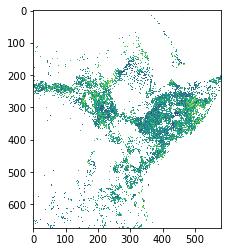

In [116]:
show(ndvi_ea_simplex_multi_full_ed6_sh_m1)

In [117]:
mean_raster = ndvi_ea_simplex_multi_full_ed6_sh_m1[np.isfinite(ndvi_ea_simplex_multi_full_ed6_sh_m1)].mean()

In [118]:
mean_raster

0.15490723141227575

In [ ]:
ndvi_ea_simplex_multi_full_ed6_sh_m1 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 601', test = '1 606', month_list = 1, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_sh_m2 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 601', test = '1 606', month_list = 2, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_sh_m3 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 601', test = '1 606', month_list = 3, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_sh_m4 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 601', test = '1 606', month_list = 4, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_sh_m5 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 601', test = '1 606', month_list = 5, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_sh_m6 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 601', test = '1 606', month_list = 6, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_sh_m7 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 601', test = '1 606', month_list = 7, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_sh_m8 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 601', test = '1 606', month_list = 8, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_sh_m9 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 601', test = '1 606', month_list = 9, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_sh_m10 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 601', test = '1 606', month_list = 10, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_sh_m11 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 601', test = '1 606', month_list = 11, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_sh_m12 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 601', test = '1 606', month_list = 12, ed = 6, pi = 18)

In [ ]:
ndvi_ea_simplex_multi_full_ed6_bo_m1 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 601', test = '1 606', month_list = 1, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_bo_m2 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 601', test = '1 606', month_list = 2, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_bo_m3 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 601', test = '1 606', month_list = 3, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_bo_m4 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 601', test = '1 606', month_list = 4, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_bo_m5 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 601', test = '1 606', month_list = 5, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_bo_m6 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 601', test = '1 606', month_list = 6, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_bo_m7 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 601', test = '1 606', month_list = 7, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_bo_m8 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 601', test = '1 606', month_list = 8, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_bo_m9 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 601', test = '1 606', month_list = 9, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_bo_m10 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 601', test = '1 606', month_list = 10, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_bo_m11 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 601', test = '1 606', month_list = 11, ed = 6, pi = 18)
ndvi_ea_simplex_multi_full_ed6_bo_m12 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 601', test = '1 606', month_list = 12, ed = 6, pi = 18)

 32%|███▏      | 123868/392942 [07:22<25:04, 178.86it/s] 

In [ ]:
ndvi_ea_simplex_multi_full_ed6_bo_m6 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 601', test = '1 606', month_list = 6, ed = 6, pi = 18)


prediction skill vs prediction interval using ED6 for all land covers

In [ ]:
ndvi_ea_simplex_multi_ci_pi01_ed6 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 1)
ndvi_ea_simplex_multi_ci_pi02_ed6 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 2)
ndvi_ea_simplex_multi_ci_pi03_ed6 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 3)
ndvi_ea_simplex_multi_ci_pi04_ed6 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 4)
ndvi_ea_simplex_multi_ci_pi05_ed6 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 5)
ndvi_ea_simplex_multi_ci_pi06_ed6 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 6)
ndvi_ea_simplex_multi_ci_pi07_ed6 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 7)
ndvi_ea_simplex_multi_ci_pi08_ed6 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 8)
ndvi_ea_simplex_multi_ci_pi09_ed6 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 9)
ndvi_ea_simplex_multi_ci_pi10_ed6 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 10)
ndvi_ea_simplex_multi_ci_pi11_ed6 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 11)
ndvi_ea_simplex_multi_ci_pi12_ed6 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 12)
ndvi_ea_simplex_multi_ci_pi13_ed6 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 13)
ndvi_ea_simplex_multi_ci_pi14_ed6 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 14)
ndvi_ea_simplex_multi_ci_pi15_ed6 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 15)
ndvi_ea_simplex_multi_ci_pi16_ed6 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 16)
ndvi_ea_simplex_multi_ci_pi17_ed6 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 17)
ndvi_ea_simplex_multi_ci_pi18_ed6 = multi_pixelwise_simplex(table_list_ci, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 18)



In [ ]:
ndvi_ea_simplex_multi_cr_pi01_ed6 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 1)
ndvi_ea_simplex_multi_cr_pi02_ed6 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 2)
ndvi_ea_simplex_multi_cr_pi03_ed6 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 3)
ndvi_ea_simplex_multi_cr_pi04_ed6 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 4)
ndvi_ea_simplex_multi_cr_pi05_ed6 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 5)
ndvi_ea_simplex_multi_cr_pi06_ed6 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 6)
ndvi_ea_simplex_multi_cr_pi07_ed6 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 7)
ndvi_ea_simplex_multi_cr_pi08_ed6 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 8)
ndvi_ea_simplex_multi_cr_pi09_ed6 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 9)
ndvi_ea_simplex_multi_cr_pi10_ed6 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 10)
ndvi_ea_simplex_multi_cr_pi11_ed6 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 11)
ndvi_ea_simplex_multi_cr_pi12_ed6 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 12)
ndvi_ea_simplex_multi_cr_pi13_ed6 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 13)
ndvi_ea_simplex_multi_cr_pi14_ed6 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 14)
ndvi_ea_simplex_multi_cr_pi15_ed6 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 15)
ndvi_ea_simplex_multi_cr_pi16_ed6 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 16)
ndvi_ea_simplex_multi_cr_pi17_ed6 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 17)
ndvi_ea_simplex_multi_cr_pi18_ed6 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 18)



 29%|██▉       | 113138/392942 [07:38<28:58, 160.90it/s] 

In [ ]:
ndvi_ea_simplex_multi_gr_pi01_ed6 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 1)
ndvi_ea_simplex_multi_gr_pi02_ed6 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 2)
ndvi_ea_simplex_multi_gr_pi03_ed6 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 3)
ndvi_ea_simplex_multi_gr_pi04_ed6 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 4)
ndvi_ea_simplex_multi_gr_pi05_ed6 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 5)
ndvi_ea_simplex_multi_gr_pi06_ed6 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 6)
ndvi_ea_simplex_multi_gr_pi07_ed6 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 7)
ndvi_ea_simplex_multi_gr_pi08_ed6 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 8)
ndvi_ea_simplex_multi_gr_pi09_ed6 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 9)
ndvi_ea_simplex_multi_gr_pi10_ed6 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 10)
ndvi_ea_simplex_multi_gr_pi11_ed6 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 11)
ndvi_ea_simplex_multi_gr_pi12_ed6 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 12)
ndvi_ea_simplex_multi_gr_pi13_ed6 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 13)
ndvi_ea_simplex_multi_gr_pi14_ed6 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 14)
ndvi_ea_simplex_multi_gr_pi15_ed6 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 15)
ndvi_ea_simplex_multi_gr_pi16_ed6 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 16)
ndvi_ea_simplex_multi_gr_pi17_ed6 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 17)
ndvi_ea_simplex_multi_gr_pi18_ed6 = multi_pixelwise_simplex(table_list_gr, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 18)



 29%|██▉       | 115780/392942 [09:10<18:35, 248.41it/s] 

In [ ]:
ndvi_ea_simplex_multi_sh_pi01_ed6 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 1)
ndvi_ea_simplex_multi_sh_pi02_ed6 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 2)
ndvi_ea_simplex_multi_sh_pi03_ed6 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 3)
ndvi_ea_simplex_multi_sh_pi04_ed6 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 4)
ndvi_ea_simplex_multi_sh_pi05_ed6 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 5)
ndvi_ea_simplex_multi_sh_pi06_ed6 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 6)
ndvi_ea_simplex_multi_sh_pi07_ed6 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 7)
ndvi_ea_simplex_multi_sh_pi08_ed6 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 8)
ndvi_ea_simplex_multi_sh_pi09_ed6 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 9)
ndvi_ea_simplex_multi_sh_pi10_ed6 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 10)
ndvi_ea_simplex_multi_sh_pi11_ed6 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 11)
ndvi_ea_simplex_multi_sh_pi12_ed6 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 12)
ndvi_ea_simplex_multi_sh_pi13_ed6 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 13)
ndvi_ea_simplex_multi_sh_pi14_ed6 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 14)
ndvi_ea_simplex_multi_sh_pi15_ed6 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 15)
ndvi_ea_simplex_multi_sh_pi16_ed6 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 16)
ndvi_ea_simplex_multi_sh_pi17_ed6 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 17)
ndvi_ea_simplex_multi_sh_pi18_ed6 = multi_pixelwise_simplex(table_list_sh, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 18)



In [ ]:
ndvi_ea_simplex_multi_bo_pi01_ed6 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 1)
ndvi_ea_simplex_multi_bo_pi02_ed6 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 2)
ndvi_ea_simplex_multi_bo_pi03_ed6 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 3)
ndvi_ea_simplex_multi_bo_pi04_ed6 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 4)
ndvi_ea_simplex_multi_bo_pi05_ed6 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 5)
ndvi_ea_simplex_multi_bo_pi06_ed6 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 6)
ndvi_ea_simplex_multi_bo_pi07_ed6 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 7)
ndvi_ea_simplex_multi_bo_pi08_ed6 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 8)
ndvi_ea_simplex_multi_bo_pi09_ed6 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 9)
ndvi_ea_simplex_multi_bo_pi10_ed6 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 10)
ndvi_ea_simplex_multi_bo_pi11_ed6 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 11)
ndvi_ea_simplex_multi_bo_pi12_ed6 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 12)
ndvi_ea_simplex_multi_bo_pi13_ed6 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 13)
ndvi_ea_simplex_multi_bo_pi14_ed6 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 14)
ndvi_ea_simplex_multi_bo_pi15_ed6 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 15)
ndvi_ea_simplex_multi_bo_pi16_ed6 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 16)
ndvi_ea_simplex_multi_bo_pi17_ed6 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 17)
ndvi_ea_simplex_multi_bo_pi18_ed6 = multi_pixelwise_simplex(table_list_bo, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 18)



 48%|████▊     | 190213/392942 [18:15<2:15:17, 24.98it/s]

prediction skill vs prediction interval using ED6 for all land covers using anomalies and splitting train/test in half

In [ ]:
ndvi_ea_simplex_multi_ci_pi01_ed6_anom = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 1)
ndvi_ea_simplex_multi_ci_pi02_ed6_anom = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 2)
ndvi_ea_simplex_multi_ci_pi03_ed6_anom = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 3)
ndvi_ea_simplex_multi_ci_pi04_ed6_anom = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 4)
ndvi_ea_simplex_multi_ci_pi05_ed6_anom = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 5)
ndvi_ea_simplex_multi_ci_pi06_ed6_anom = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 6)
ndvi_ea_simplex_multi_ci_pi07_ed6_anom = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 7)
ndvi_ea_simplex_multi_ci_pi08_ed6_anom = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 8)
ndvi_ea_simplex_multi_ci_pi09_ed6_anom = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 9)
ndvi_ea_simplex_multi_ci_pi10_ed6_anom = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 10)
ndvi_ea_simplex_multi_ci_pi11_ed6_anom = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 11)
ndvi_ea_simplex_multi_ci_pi12_ed6_anom = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 12)
ndvi_ea_simplex_multi_ci_pi13_ed6_anom = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 13)
ndvi_ea_simplex_multi_ci_pi14_ed6_anom = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 14)
ndvi_ea_simplex_multi_ci_pi15_ed6_anom = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 15)
ndvi_ea_simplex_multi_ci_pi16_ed6_anom = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 16)
ndvi_ea_simplex_multi_ci_pi17_ed6_anom = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 17)
ndvi_ea_simplex_multi_ci_pi18_ed6_anom = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 18)



 59%|█████▉    | 233704/392942 [11:11<08:33, 309.97it/s]

In [ ]:
ndvi_ea_simplex_multi_cr_pi01_ed6_anom = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 1)
ndvi_ea_simplex_multi_cr_pi02_ed6_anom = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 2)
ndvi_ea_simplex_multi_cr_pi03_ed6_anom = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 3)
ndvi_ea_simplex_multi_cr_pi04_ed6_anom = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 4)
ndvi_ea_simplex_multi_cr_pi05_ed6_anom = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 5)
ndvi_ea_simplex_multi_cr_pi06_ed6_anom = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 6)
ndvi_ea_simplex_multi_cr_pi07_ed6_anom = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 7)
ndvi_ea_simplex_multi_cr_pi08_ed6_anom = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 8)
ndvi_ea_simplex_multi_cr_pi09_ed6_anom = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 9)
ndvi_ea_simplex_multi_cr_pi10_ed6_anom = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 10)
ndvi_ea_simplex_multi_cr_pi11_ed6_anom = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 11)
ndvi_ea_simplex_multi_cr_pi12_ed6_anom = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 12)
ndvi_ea_simplex_multi_cr_pi13_ed6_anom = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 13)
ndvi_ea_simplex_multi_cr_pi14_ed6_anom = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 14)
ndvi_ea_simplex_multi_cr_pi15_ed6_anom = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 15)
ndvi_ea_simplex_multi_cr_pi16_ed6_anom = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 16)
ndvi_ea_simplex_multi_cr_pi17_ed6_anom = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 17)
ndvi_ea_simplex_multi_cr_pi18_ed6_anom = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 18)


In [ ]:
ndvi_ea_simplex_multi_gr_pi01_ed6_anom = multi_pixelwise_simplex(table_list_gr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 1)
ndvi_ea_simplex_multi_gr_pi02_ed6_anom = multi_pixelwise_simplex(table_list_gr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 2)
ndvi_ea_simplex_multi_gr_pi03_ed6_anom = multi_pixelwise_simplex(table_list_gr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 3)
ndvi_ea_simplex_multi_gr_pi04_ed6_anom = multi_pixelwise_simplex(table_list_gr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 4)
ndvi_ea_simplex_multi_gr_pi05_ed6_anom = multi_pixelwise_simplex(table_list_gr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 5)
ndvi_ea_simplex_multi_gr_pi06_ed6_anom = multi_pixelwise_simplex(table_list_gr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 6)
ndvi_ea_simplex_multi_gr_pi07_ed6_anom = multi_pixelwise_simplex(table_list_gr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 7)
ndvi_ea_simplex_multi_gr_pi08_ed6_anom = multi_pixelwise_simplex(table_list_gr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 8)
ndvi_ea_simplex_multi_gr_pi09_ed6_anom = multi_pixelwise_simplex(table_list_gr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 9)
ndvi_ea_simplex_multi_gr_pi10_ed6_anom = multi_pixelwise_simplex(table_list_gr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 10)
ndvi_ea_simplex_multi_gr_pi11_ed6_anom = multi_pixelwise_simplex(table_list_gr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 11)
ndvi_ea_simplex_multi_gr_pi12_ed6_anom = multi_pixelwise_simplex(table_list_gr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 12)
ndvi_ea_simplex_multi_gr_pi13_ed6_anom = multi_pixelwise_simplex(table_list_gr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 13)
ndvi_ea_simplex_multi_gr_pi14_ed6_anom = multi_pixelwise_simplex(table_list_gr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 14)
ndvi_ea_simplex_multi_gr_pi15_ed6_anom = multi_pixelwise_simplex(table_list_gr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 15)
ndvi_ea_simplex_multi_gr_pi16_ed6_anom = multi_pixelwise_simplex(table_list_gr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 16)
ndvi_ea_simplex_multi_gr_pi17_ed6_anom = multi_pixelwise_simplex(table_list_gr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 17)
ndvi_ea_simplex_multi_gr_pi18_ed6_anom = multi_pixelwise_simplex(table_list_gr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 18)


In [ ]:
ndvi_ea_simplex_multi_sh_pi01_ed6_anom = multi_pixelwise_simplex(table_list_sh_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 1)
ndvi_ea_simplex_multi_sh_pi02_ed6_anom = multi_pixelwise_simplex(table_list_sh_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 2)
ndvi_ea_simplex_multi_sh_pi03_ed6_anom = multi_pixelwise_simplex(table_list_sh_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 3)
ndvi_ea_simplex_multi_sh_pi04_ed6_anom = multi_pixelwise_simplex(table_list_sh_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 4)
ndvi_ea_simplex_multi_sh_pi05_ed6_anom = multi_pixelwise_simplex(table_list_sh_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 5)
ndvi_ea_simplex_multi_sh_pi06_ed6_anom = multi_pixelwise_simplex(table_list_sh_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 6)
ndvi_ea_simplex_multi_sh_pi07_ed6_anom = multi_pixelwise_simplex(table_list_sh_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 7)
ndvi_ea_simplex_multi_sh_pi08_ed6_anom = multi_pixelwise_simplex(table_list_sh_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 8)
ndvi_ea_simplex_multi_sh_pi09_ed6_anom = multi_pixelwise_simplex(table_list_sh_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 9)
ndvi_ea_simplex_multi_sh_pi10_ed6_anom = multi_pixelwise_simplex(table_list_sh_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 10)
ndvi_ea_simplex_multi_sh_pi11_ed6_anom = multi_pixelwise_simplex(table_list_sh_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 11)
ndvi_ea_simplex_multi_sh_pi12_ed6_anom = multi_pixelwise_simplex(table_list_sh_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 12)
ndvi_ea_simplex_multi_sh_pi13_ed6_anom = multi_pixelwise_simplex(table_list_sh_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 13)
ndvi_ea_simplex_multi_sh_pi14_ed6_anom = multi_pixelwise_simplex(table_list_sh_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 14)
ndvi_ea_simplex_multi_sh_pi15_ed6_anom = multi_pixelwise_simplex(table_list_sh_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 15)
ndvi_ea_simplex_multi_sh_pi16_ed6_anom = multi_pixelwise_simplex(table_list_sh_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 16)
ndvi_ea_simplex_multi_sh_pi17_ed6_anom = multi_pixelwise_simplex(table_list_sh_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 17)
ndvi_ea_simplex_multi_sh_pi18_ed6_anom = multi_pixelwise_simplex(table_list_sh_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 18)

 28%|██▊       | 108070/392942 [05:31<15:18, 310.19it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  1%|          | 2419/392942 [00:06<17:15, 377.07it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 49%|████▉     | 192931/392942 [15:47<34:36, 96.31it/s]  

In [1]:
x

NameError: name 'x' is not defined

In [ ]:
ndvi_ea_simplex_multi_bo_pi01_ed6_anom = multi_pixelwise_simplex(table_list_bo_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 1)
ndvi_ea_simplex_multi_bo_pi02_ed6_anom = multi_pixelwise_simplex(table_list_bo_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 2)
ndvi_ea_simplex_multi_bo_pi03_ed6_anom = multi_pixelwise_simplex(table_list_bo_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 3)
ndvi_ea_simplex_multi_bo_pi04_ed6_anom = multi_pixelwise_simplex(table_list_bo_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 4)
ndvi_ea_simplex_multi_bo_pi05_ed6_anom = multi_pixelwise_simplex(table_list_bo_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 5)
ndvi_ea_simplex_multi_bo_pi06_ed6_anom = multi_pixelwise_simplex(table_list_bo_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 6)
ndvi_ea_simplex_multi_bo_pi07_ed6_anom = multi_pixelwise_simplex(table_list_bo_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 7)
ndvi_ea_simplex_multi_bo_pi08_ed6_anom = multi_pixelwise_simplex(table_list_bo_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 8)
ndvi_ea_simplex_multi_bo_pi09_ed6_anom = multi_pixelwise_simplex(table_list_bo_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 9)
ndvi_ea_simplex_multi_bo_pi10_ed6_anom = multi_pixelwise_simplex(table_list_bo_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 10)
ndvi_ea_simplex_multi_bo_pi11_ed6_anom = multi_pixelwise_simplex(table_list_bo_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 11)
ndvi_ea_simplex_multi_bo_pi12_ed6_anom = multi_pixelwise_simplex(table_list_bo_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 12)
ndvi_ea_simplex_multi_bo_pi13_ed6_anom = multi_pixelwise_simplex(table_list_bo_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 13)
ndvi_ea_simplex_multi_bo_pi14_ed6_anom = multi_pixelwise_simplex(table_list_bo_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 14)
ndvi_ea_simplex_multi_bo_pi15_ed6_anom = multi_pixelwise_simplex(table_list_bo_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 15)
ndvi_ea_simplex_multi_bo_pi16_ed6_anom = multi_pixelwise_simplex(table_list_bo_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 16)
ndvi_ea_simplex_multi_bo_pi17_ed6_anom = multi_pixelwise_simplex(table_list_bo_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 17)
ndvi_ea_simplex_multi_bo_pi18_ed6_anom = multi_pixelwise_simplex(table_list_bo_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 18)

 86%|████████▋ | 339820/392942 [22:34<03:10, 278.38it/s] 

Prediction skill vs embedding dimension anomalies 

In [ ]:
ndvi_ea_simplex_multi_ci_pi6_ed01_anom = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 604', test = '1 606', ed = 1, pi = 6)
ndvi_ea_simplex_multi_ci_pi6_ed02_anom = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 603', test = '1 606', ed = 2, pi = 6)
ndvi_ea_simplex_multi_ci_pi6_ed03_anom = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 604', test = '1 606', ed = 3, pi = 6)
ndvi_ea_simplex_multi_ci_pi6_ed04_anom = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 603', test = '1 606', ed = 4, pi = 6)
ndvi_ea_simplex_multi_ci_pi6_ed05_anom = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 602', test = '1 606', ed = 5, pi = 6)
ndvi_ea_simplex_multi_ci_pi6_ed06_anom = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 6)
ndvi_ea_simplex_multi_ci_pi6_ed07_anom = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 599', test = '1 606', ed = 7, pi = 6)
ndvi_ea_simplex_multi_ci_pi6_ed08_anom = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 598', test = '1 606', ed = 8, pi = 6)
ndvi_ea_simplex_multi_ci_pi6_ed09_anom = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 597', test = '1 606', ed = 9, pi = 6)
ndvi_ea_simplex_multi_ci_pi6_ed10_anom = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 596', test = '1 606', ed = 10, pi = 6)


In [ ]:
ndvi_ea_simplex_multi_cr_pi6_ed01_anom = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 604', test = '1 606', ed = 1, pi = 6)
ndvi_ea_simplex_multi_cr_pi6_ed02_anom = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 603', test = '1 606', ed = 2, pi = 6)
ndvi_ea_simplex_multi_cr_pi6_ed03_anom = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 604', test = '1 606', ed = 3, pi = 6)
ndvi_ea_simplex_multi_cr_pi6_ed04_anom = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 603', test = '1 606', ed = 4, pi = 6)
ndvi_ea_simplex_multi_cr_pi6_ed05_anom = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 602', test = '1 606', ed = 5, pi = 6)
ndvi_ea_simplex_multi_cr_pi6_ed06_anom = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 6)
ndvi_ea_simplex_multi_cr_pi6_ed07_anom = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 599', test = '1 606', ed = 7, pi = 6)
ndvi_ea_simplex_multi_cr_pi6_ed08_anom = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 598', test = '1 606', ed = 8, pi = 6)
ndvi_ea_simplex_multi_cr_pi6_ed09_anom = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 597', test = '1 606', ed = 9, pi = 6)
ndvi_ea_simplex_multi_cr_pi6_ed10_anom = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 596', test = '1 606', ed = 10, pi = 6)


In [ ]:
ndvi_ea_simplex_multi_sh_pi6_ed01_anom = multi_pixelwise_simplex(table_list_sh_anom, 'ndvi', train = '1 604', test = '1 606', ed = 1, pi = 6)
ndvi_ea_simplex_multi_sh_pi6_ed02_anom = multi_pixelwise_simplex(table_list_sh_anom, 'ndvi', train = '1 603', test = '1 606', ed = 2, pi = 6)
ndvi_ea_simplex_multi_sh_pi6_ed03_anom = multi_pixelwise_simplex(table_list_sh_anom, 'ndvi', train = '1 604', test = '1 606', ed = 3, pi = 6)
ndvi_ea_simplex_multi_sh_pi6_ed04_anom = multi_pixelwise_simplex(table_list_sh_anom, 'ndvi', train = '1 603', test = '1 606', ed = 4, pi = 6)
ndvi_ea_simplex_multi_sh_pi6_ed05_anom = multi_pixelwise_simplex(table_list_sh_anom, 'ndvi', train = '1 602', test = '1 606', ed = 5, pi = 6)
ndvi_ea_simplex_multi_sh_pi6_ed06_anom = multi_pixelwise_simplex(table_list_sh_anom, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 6)
ndvi_ea_simplex_multi_sh_pi6_ed07_anom = multi_pixelwise_simplex(table_list_sh_anom, 'ndvi', train = '1 599', test = '1 606', ed = 7, pi = 6)
ndvi_ea_simplex_multi_sh_pi6_ed08_anom = multi_pixelwise_simplex(table_list_sh_anom, 'ndvi', train = '1 598', test = '1 606', ed = 8, pi = 6)
ndvi_ea_simplex_multi_sh_pi6_ed09_anom = multi_pixelwise_simplex(table_list_sh_anom, 'ndvi', train = '1 597', test = '1 606', ed = 9, pi = 6)
ndvi_ea_simplex_multi_sh_pi6_ed10_anom = multi_pixelwise_simplex(table_list_sh_anom, 'ndvi', train = '1 596', test = '1 606', ed = 10, pi = 6)


In [ ]:
ndvi_ea_simplex_multi_gr_pi6_ed01_anom = multi_pixelwise_simplex(table_list_gr_anom, 'ndvi', train = '1 604', test = '1 606', ed = 1, pi = 6)
ndvi_ea_simplex_multi_gr_pi6_ed02_anom = multi_pixelwise_simplex(table_list_gr_anom, 'ndvi', train = '1 603', test = '1 606', ed = 2, pi = 6)
ndvi_ea_simplex_multi_gr_pi6_ed03_anom = multi_pixelwise_simplex(table_list_gr_anom, 'ndvi', train = '1 604', test = '1 606', ed = 3, pi = 6)
ndvi_ea_simplex_multi_gr_pi6_ed04_anom = multi_pixelwise_simplex(table_list_gr_anom, 'ndvi', train = '1 603', test = '1 606', ed = 4, pi = 6)
ndvi_ea_simplex_multi_gr_pi6_ed05_anom = multi_pixelwise_simplex(table_list_gr_anom, 'ndvi', train = '1 602', test = '1 606', ed = 5, pi = 6)
ndvi_ea_simplex_multi_gr_pi6_ed06_anom = multi_pixelwise_simplex(table_list_gr_anom, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 6)
ndvi_ea_simplex_multi_gr_pi6_ed07_anom = multi_pixelwise_simplex(table_list_gr_anom, 'ndvi', train = '1 599', test = '1 606', ed = 7, pi = 6)
ndvi_ea_simplex_multi_gr_pi6_ed08_anom = multi_pixelwise_simplex(table_list_gr_anom, 'ndvi', train = '1 598', test = '1 606', ed = 8, pi = 6)
ndvi_ea_simplex_multi_gr_pi6_ed09_anom = multi_pixelwise_simplex(table_list_gr_anom, 'ndvi', train = '1 597', test = '1 606', ed = 9, pi = 6)
ndvi_ea_simplex_multi_gr_pi6_ed10_anom = multi_pixelwise_simplex(table_list_gr_anom, 'ndvi', train = '1 596', test = '1 606', ed = 10, pi = 6)


In [ ]:
ndvi_ea_simplex_multi_bo_pi6_ed01_anom = multi_pixelwise_simplex(table_list_bo_anom, 'ndvi', train = '1 604', test = '1 606', ed = 1, pi = 6)
ndvi_ea_simplex_multi_bo_pi6_ed02_anom = multi_pixelwise_simplex(table_list_bo_anom, 'ndvi', train = '1 603', test = '1 606', ed = 2, pi = 6)
ndvi_ea_simplex_multi_bo_pi6_ed03_anom = multi_pixelwise_simplex(table_list_bo_anom, 'ndvi', train = '1 604', test = '1 606', ed = 3, pi = 6)
ndvi_ea_simplex_multi_bo_pi6_ed04_anom = multi_pixelwise_simplex(table_list_bo_anom, 'ndvi', train = '1 603', test = '1 606', ed = 4, pi = 6)
ndvi_ea_simplex_multi_bo_pi6_ed05_anom = multi_pixelwise_simplex(table_list_bo_anom, 'ndvi', train = '1 602', test = '1 606', ed = 5, pi = 6)
ndvi_ea_simplex_multi_bo_pi6_ed06_anom = multi_pixelwise_simplex(table_list_bo_anom, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 6)
ndvi_ea_simplex_multi_bo_pi6_ed07_anom = multi_pixelwise_simplex(table_list_bo_anom, 'ndvi', train = '1 599', test = '1 606', ed = 7, pi = 6)
ndvi_ea_simplex_multi_bo_pi6_ed08_anom = multi_pixelwise_simplex(table_list_bo_anom, 'ndvi', train = '1 598', test = '1 606', ed = 8, pi = 6)
ndvi_ea_simplex_multi_bo_pi6_ed09_anom = multi_pixelwise_simplex(table_list_bo_anom, 'ndvi', train = '1 597', test = '1 606', ed = 9, pi = 6)
ndvi_ea_simplex_multi_bo_pi6_ed10_anom = multi_pixelwise_simplex(table_list_bo_anom, 'ndvi', train = '1 596', test = '1 606', ed = 10, pi = 6)


Prediction skill vs embedding dimension with anomalies and splitting training/testing in half

In [ ]:
ndvi_ea_simplex_multi_ci_pi6_ed01_anom_hh = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 1, pi = 6)
ndvi_ea_simplex_multi_ci_pi6_ed02_anom_hh = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 2, pi = 6)
ndvi_ea_simplex_multi_ci_pi6_ed03_anom_hh = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 3, pi = 6)
ndvi_ea_simplex_multi_ci_pi6_ed04_anom_hh = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 4, pi = 6)
ndvi_ea_simplex_multi_ci_pi6_ed05_anom_hh = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 5, pi = 6)
ndvi_ea_simplex_multi_ci_pi6_ed06_anom_hh = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 6)
ndvi_ea_simplex_multi_ci_pi6_ed07_anom_hh = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 7, pi = 6)
ndvi_ea_simplex_multi_ci_pi6_ed08_anom_hh = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 8, pi = 6)
ndvi_ea_simplex_multi_ci_pi6_ed09_anom_hh = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 9, pi = 6)
ndvi_ea_simplex_multi_ci_pi6_ed10_anom_hh = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 10, pi = 6)


In [ ]:
ndvi_ea_simplex_multi_cr_pi6_ed01_anom_hh = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 1, pi = 6)
ndvi_ea_simplex_multi_cr_pi6_ed02_anom_hh = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 2, pi = 6)
ndvi_ea_simplex_multi_cr_pi6_ed03_anom_hh = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 3, pi = 6)
ndvi_ea_simplex_multi_cr_pi6_ed04_anom_hh = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 4, pi = 6)
ndvi_ea_simplex_multi_cr_pi6_ed05_anom_hh = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 5, pi = 6)
ndvi_ea_simplex_multi_cr_pi6_ed06_anom_hh = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 6)
ndvi_ea_simplex_multi_cr_pi6_ed07_anom_hh = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 7, pi = 6)
ndvi_ea_simplex_multi_cr_pi6_ed08_anom_hh = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 8, pi = 6)
ndvi_ea_simplex_multi_cr_pi6_ed09_anom_hh = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 9, pi = 6)
ndvi_ea_simplex_multi_cr_pi6_ed10_anom_hh = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 10, pi = 6)


 46%|████▌     | 181584/392942 [10:54<11:39, 302.15it/s] 

In [ ]:
ndvi_ea_simplex_multi_sh_pi6_ed01_anom_hh = multi_pixelwise_simplex(table_list_sh_anom, 'ndvi', train = '1 303', test = '304 606', ed = 1, pi = 6)
ndvi_ea_simplex_multi_sh_pi6_ed02_anom_hh = multi_pixelwise_simplex(table_list_sh_anom, 'ndvi', train = '1 303', test = '304 606', ed = 2, pi = 6)
ndvi_ea_simplex_multi_sh_pi6_ed03_anom_hh = multi_pixelwise_simplex(table_list_sh_anom, 'ndvi', train = '1 303', test = '304 606', ed = 3, pi = 6)
ndvi_ea_simplex_multi_sh_pi6_ed04_anom_hh = multi_pixelwise_simplex(table_list_sh_anom, 'ndvi', train = '1 303', test = '304 606', ed = 4, pi = 6)
ndvi_ea_simplex_multi_sh_pi6_ed05_anom_hh = multi_pixelwise_simplex(table_list_sh_anom, 'ndvi', train = '1 303', test = '304 606', ed = 5, pi = 6)
ndvi_ea_simplex_multi_sh_pi6_ed06_anom_hh = multi_pixelwise_simplex(table_list_sh_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 6)
ndvi_ea_simplex_multi_sh_pi6_ed07_anom_hh = multi_pixelwise_simplex(table_list_sh_anom, 'ndvi', train = '1 303', test = '304 606', ed = 7, pi = 6)
ndvi_ea_simplex_multi_sh_pi6_ed08_anom_hh = multi_pixelwise_simplex(table_list_sh_anom, 'ndvi', train = '1 303', test = '304 606', ed = 8, pi = 6)
ndvi_ea_simplex_multi_sh_pi6_ed09_anom_hh = multi_pixelwise_simplex(table_list_sh_anom, 'ndvi', train = '1 303', test = '304 606', ed = 9, pi = 6)
ndvi_ea_simplex_multi_sh_pi6_ed10_anom_hh = multi_pixelwise_simplex(table_list_sh_anom, 'ndvi', train = '1 303', test = '304 606', ed = 10, pi = 6)


In [ ]:
ndvi_ea_simplex_multi_gr_pi6_ed01_anom_hh = multi_pixelwise_simplex(table_list_gr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 1, pi = 6)
ndvi_ea_simplex_multi_gr_pi6_ed02_anom_hh = multi_pixelwise_simplex(table_list_gr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 2, pi = 6)
ndvi_ea_simplex_multi_gr_pi6_ed03_anom_hh = multi_pixelwise_simplex(table_list_gr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 3, pi = 6)
ndvi_ea_simplex_multi_gr_pi6_ed04_anom_hh = multi_pixelwise_simplex(table_list_gr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 4, pi = 6)
ndvi_ea_simplex_multi_gr_pi6_ed05_anom_hh = multi_pixelwise_simplex(table_list_gr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 5, pi = 6)
ndvi_ea_simplex_multi_gr_pi6_ed06_anom_hh = multi_pixelwise_simplex(table_list_gr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 6)
ndvi_ea_simplex_multi_gr_pi6_ed07_anom_hh = multi_pixelwise_simplex(table_list_gr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 7, pi = 6)
ndvi_ea_simplex_multi_gr_pi6_ed08_anom_hh = multi_pixelwise_simplex(table_list_gr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 8, pi = 6)
ndvi_ea_simplex_multi_gr_pi6_ed09_anom_hh = multi_pixelwise_simplex(table_list_gr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 9, pi = 6)
ndvi_ea_simplex_multi_gr_pi6_ed10_anom_hh = multi_pixelwise_simplex(table_list_gr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 10, pi = 6)


In [ ]:
ndvi_ea_simplex_multi_bo_pi6_ed01_anom_hh = multi_pixelwise_simplex(table_list_bo_anom, 'ndvi', train = '1 303', test = '304 606', ed = 1, pi = 6)
ndvi_ea_simplex_multi_bo_pi6_ed02_anom_hh = multi_pixelwise_simplex(table_list_bo_anom, 'ndvi', train = '1 303', test = '304 606', ed = 2, pi = 6)
ndvi_ea_simplex_multi_bo_pi6_ed03_anom_hh = multi_pixelwise_simplex(table_list_bo_anom, 'ndvi', train = '1 303', test = '304 606', ed = 3, pi = 6)
ndvi_ea_simplex_multi_bo_pi6_ed04_anom_hh = multi_pixelwise_simplex(table_list_bo_anom, 'ndvi', train = '1 303', test = '304 606', ed = 4, pi = 6)
ndvi_ea_simplex_multi_bo_pi6_ed05_anom_hh = multi_pixelwise_simplex(table_list_bo_anom, 'ndvi', train = '1 303', test = '304 606', ed = 5, pi = 6)
ndvi_ea_simplex_multi_bo_pi6_ed06_anom_hh = multi_pixelwise_simplex(table_list_bo_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 6)
ndvi_ea_simplex_multi_bo_pi6_ed07_anom_hh = multi_pixelwise_simplex(table_list_bo_anom, 'ndvi', train = '1 303', test = '304 606', ed = 7, pi = 6)
ndvi_ea_simplex_multi_bo_pi6_ed08_anom_hh = multi_pixelwise_simplex(table_list_bo_anom, 'ndvi', train = '1 303', test = '304 606', ed = 8, pi = 6)
ndvi_ea_simplex_multi_bo_pi6_ed09_anom_hh = multi_pixelwise_simplex(table_list_bo_anom, 'ndvi', train = '1 303', test = '304 606', ed = 9, pi = 6)
ndvi_ea_simplex_multi_bo_pi6_ed10_anom_hh = multi_pixelwise_simplex(table_list_bo_anom, 'ndvi', train = '1 303', test = '304 606', ed = 10, pi = 6)


Prediction skill ed 6 pi 18

In [ ]:
ndvi_ea_simplex_multi_bo_pi18_ed6_anom = multi_pixelwise_simplex(table_list_bo_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 18)
ndvi_ea_simplex_multi_sh_pi18_ed6_anom = multi_pixelwise_simplex(table_list_sh_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 18)
ndvi_ea_simplex_multi_gr_pi18_ed6_anom = multi_pixelwise_simplex(table_list_gr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 18)
ndvi_ea_simplex_multi_ci_pi18_ed6_anom = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 18)
ndvi_ea_simplex_multi_cr_pi18_ed6_anom = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 18)

 56%|█████▌    | 218929/392942 [12:46<14:00, 206.98it/s]

How early before and during a season can we skillfully predict the end of season result?

In [ ]:
ndvi_seasonal_2002_ond = multi_pixelwise_simplex(table_list_bo_anom, 'ndvi', train = '1 296', test = '297 306', ed = 2, pi = 9)

In [59]:
ndvi_seasonal_ond_ci = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 1, month_list = [10,11,12])

100%|██████████| 392942/392942 [18:23<00:00, 356.01it/s]


In [8]:
ndvi_seasonal_mam_cr_pi02

NameError: name 'ndvi_seasonal_mam_cr_pi02' is not defined

In [60]:
ndvi_seasonal_ond_ci_pi02 = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 2, month_list = [10,11,12])
ndvi_seasonal_ond_ci_pi03 = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 3, month_list = [10,11,12])
ndvi_seasonal_ond_ci_pi04 = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 4, month_list = [10,11,12])
ndvi_seasonal_ond_ci_pi05 = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 5, month_list = [10,11,12])
ndvi_seasonal_ond_ci_pi06 = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 6, month_list = [10,11,12])
ndvi_seasonal_ond_ci_pi07 = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 7, month_list = [10,11,12])
ndvi_seasonal_ond_ci_pi08 = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 8, month_list = [10,11,12])
ndvi_seasonal_ond_ci_pi09 = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 9, month_list = [10,11,12])
ndvi_seasonal_ond_ci_pi10 = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 10, month_list = [10,11,12])
ndvi_seasonal_ond_ci_pi11 = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 11, month_list = [10,11,12])
ndvi_seasonal_ond_ci_pi12 = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 12, month_list = [10,11,12])
ndvi_seasonal_ond_ci_pi13 = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 13, month_list = [10,11,12])
ndvi_seasonal_ond_ci_pi14 = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 14, month_list = [10,11,12])
ndvi_seasonal_ond_ci_pi15 = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 15, month_list = [10,11,12])
ndvi_seasonal_ond_ci_pi16 = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 16, month_list = [10,11,12])
ndvi_seasonal_ond_ci_pi17 = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 17, month_list = [10,11,12])
ndvi_seasonal_ond_ci_pi18 = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 18, month_list = [10,11,12])

 65%|██████▍   | 253585/392942 [11:53<06:21, 365.01it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 69%|██████▉   | 272064/392942 [12:43<05:19, 378.50it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 73%|███████▎  | 286309/392942 [13:21<04:48, 369.14it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--No

In [ ]:
ndvi_seasonal_ond_cr_pi02 = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 2, month_list = [10,11,12])
ndvi_seasonal_ond_cr_pi03 = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 3, month_list = [10,11,12])
ndvi_seasonal_ond_cr_pi04 = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 4, month_list = [10,11,12])
ndvi_seasonal_ond_cr_pi05 = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 5, month_list = [10,11,12])
ndvi_seasonal_ond_cr_pi06 = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 6, month_list = [10,11,12])
ndvi_seasonal_ond_cr_pi07 = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 7, month_list = [10,11,12])
ndvi_seasonal_ond_cr_pi08 = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 8, month_list = [10,11,12])
ndvi_seasonal_ond_cr_pi09 = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 9, month_list = [10,11,12])
ndvi_seasonal_ond_cr_pi10 = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 10, month_list = [10,11,12])
ndvi_seasonal_ond_cr_pi11 = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 11, month_list = [10,11,12])
ndvi_seasonal_ond_cr_pi12 = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 12, month_list = [10,11,12])
ndvi_seasonal_ond_cr_pi13 = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 13, month_list = [10,11,12])
ndvi_seasonal_ond_cr_pi14 = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 14, month_list = [10,11,12])
ndvi_seasonal_ond_cr_pi15 = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 15, month_list = [10,11,12])
ndvi_seasonal_ond_cr_pi16 = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 16, month_list = [10,11,12])
ndvi_seasonal_ond_cr_pi17 = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 17, month_list = [10,11,12])
ndvi_seasonal_ond_cr_pi18 = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 18, month_list = [10,11,12])

 82%|████████▏ | 321012/392942 [20:48<05:35, 214.22it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 41%|████      | 160318/392942 [10:15<12:33, 308.80it/s] 

In [ ]:
ndvi_seasonal_mam_ci_pi02 = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 2, month_list = [3,4,5])
ndvi_seasonal_mam_ci_pi03 = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 3, month_list = [3,4,5])
ndvi_seasonal_mam_ci_pi04 = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 4, month_list = [3,4,5])
ndvi_seasonal_mam_ci_pi05 = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 5, month_list = [3,4,5])
ndvi_seasonal_mam_ci_pi06 = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 6, month_list = [3,4,5])
ndvi_seasonal_mam_ci_pi07 = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 7, month_list = [3,4,5])
ndvi_seasonal_mam_ci_pi08 = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 8, month_list = [3,4,5])
ndvi_seasonal_mam_ci_pi09 = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 9, month_list = [3,4,5])
ndvi_seasonal_mam_ci_pi10 = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 10, month_list = [3,4,5])
ndvi_seasonal_mam_ci_pi11 = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 11, month_list = [3,4,5])
ndvi_seasonal_mam_ci_pi12 = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 12, month_list = [3,4,5])
ndvi_seasonal_mam_ci_pi13 = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 13, month_list = [3,4,5])
ndvi_seasonal_mam_ci_pi14 = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 14, month_list = [3,4,5])
ndvi_seasonal_mam_ci_pi15 = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 15, month_list = [3,4,5])
ndvi_seasonal_mam_ci_pi16 = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 16, month_list = [3,4,5])
ndvi_seasonal_mam_ci_pi17 = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 17, month_list = [3,4,5])
ndvi_seasonal_mam_ci_pi18 = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 18, month_list = [3,4,5])

In [ ]:
ndvi_seasonal_mam_cr_pi02 = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 2, month_list = [3,4,5])
ndvi_seasonal_mam_cr_pi03 = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 3, month_list = [3,4,5])
ndvi_seasonal_mam_cr_pi04 = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 4, month_list = [3,4,5])
ndvi_seasonal_mam_cr_pi05 = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 5, month_list = [3,4,5])
ndvi_seasonal_mam_cr_pi06 = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 6, month_list = [3,4,5])
ndvi_seasonal_mam_cr_pi07 = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 7, month_list = [3,4,5])
ndvi_seasonal_mam_cr_pi08 = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 8, month_list = [3,4,5])
ndvi_seasonal_mam_cr_pi09 = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 9, month_list = [3,4,5])
ndvi_seasonal_mam_cr_pi10 = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 10, month_list = [3,4,5])
ndvi_seasonal_mam_cr_pi11 = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 11, month_list = [3,4,5])
ndvi_seasonal_mam_cr_pi12 = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 12, month_list = [3,4,5])
ndvi_seasonal_mam_cr_pi13 = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 13, month_list = [3,4,5])
ndvi_seasonal_mam_cr_pi14 = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 14, month_list = [3,4,5])
ndvi_seasonal_mam_cr_pi15 = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 15, month_list = [3,4,5])
ndvi_seasonal_mam_cr_pi16 = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 16, month_list = [3,4,5])
ndvi_seasonal_mam_cr_pi17 = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 17, month_list = [3,4,5])
ndvi_seasonal_mam_cr_pi18 = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 18, month_list = [3,4,5])

In [ ]:
x

Prediction skill ed 6 pi 6

In [26]:
ndvi_ea_simplex_multi_bo_pi6_ed6_anom = multi_pixelwise_simplex(table_list_bo_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 6)
ndvi_ea_simplex_multi_sh_pi6_ed6_anom = multi_pixelwise_simplex(table_list_sh_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 6)
ndvi_ea_simplex_multi_gr_pi6_ed6_anom = multi_pixelwise_simplex(table_list_gr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 6)
ndvi_ea_simplex_multi_ci_pi6_ed6_anom = multi_pixelwise_simplex(table_list_ci_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 6)
ndvi_ea_simplex_multi_cr_pi6_ed6_anom = multi_pixelwise_simplex(table_list_cr_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 6)

100%|██████████| 392942/392942 [26:04<00:00, 251.16it/s] 


# Prediction Skill/Prediction Interval Rainfall

In [81]:
def pixelwise_simplex(table, target_label, train, test, ed, pi):
    
    '''
    This function computes the simplex prediction skill for a given embedding dimensions, prediction interval, land cover and environmental variable
    across pixels given a table of pixel values across time for a region from the function pixelwise_ts_table 

    The result is an np.array of simplex error values reshaped back into the shape of the original raster image
    
    Args:
    - table: input table, where every column is the time series of each pixel in a raster
    - train: portion of data library used to train (string of range with space between values)
    - test: portion of data libary used to test (string of range with space between values) 
    - ed: embedding dimension
    - pi: prediction interval (Tp) 
    - rs_rows: number of rows to reshape list into original raster size
    - rs_cols: number of columns to reshape list into original raster size
   
     '''

    simplex_out_df = []
    table_dict = {'Time': dekads }
    #table_dict = {
       # 'Time': list(range(0,table.n_samples)) 
    #}    
    simplex_out_df = []
    label = table.label # Assumes that all tables have labels
    dekads_fut = generate_dekads(dekads[-1],pd.datetime(2020,4,30))
    
    for col in tqdm(range(len(table.columns))):
        [table_dict.update({table.label: table.iloc[:,col]})]
        interim_df = pd.DataFrame(table_dict)
        interim_df.set_index('Time',inplace=True, drop=False)
        
        
#         if interim_df.isnull().values.any():
        if max([len(interim_df[interim_df[col].isnull()]) for col in interim_df.columns]) > 20:
            simplex_out_df.append(np.nan)  
            #simplex_out_df.append(np.nan)
        else:
            # Check whether column has a few nans
            if interim_df[label].isnull().values.any():
                # If so, iterate through nan rows and replace with monthly mean
                for t in interim_df[interim_df[label].isnull()].index:
                    interim_df[label].loc[t] = interim_df[label][interim_df.index.month == t.month].mean()
                    
            #interim_df = pd.DataFrame({'Time': list(range(0,table.n_samples)), 'Data': table[column]}) #'Time': dekads
            simplex_result = Simplex(dataFrame = interim_df, 
                                     lib = train,
                                     pred = test,
                                     E = ed, Tp = pi, 
                                     columns = target_label, target = target_label, showPlot = False)
            
            # Add datetime index + fix dekad values for future values
            simplex_result.Time = pd.to_datetime(simplex_result.Time)
            simplex_result.set_index(simplex_result.Time, inplace=True)
            
            
            # Fix datetime index for future dekads
            simplex_result[-pi:].Time = dekads_fut[1:pi+1]
            
            error = ComputeError(list(simplex_result.Observations), list(simplex_result.Predictions))
            
            rho = list(error.values())[2]
            simplex_out_df.append(rho) 
            
    return(np.reshape(simplex_out_df, (table.rs_rows, table.rs_cols)))
            



precip prediction skill for all intervals

In [50]:
precip_ea_simplex_multi_cr_pi01 = pixelwise_simplex(precip_cr_table_anom, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 1)

100%|██████████| 392942/392942 [18:58<00:00, 345.21it/s] 


In [ ]:
precip_ea_simplex_multi_cr_pi01 = precip_anom_ea_simplex_multi_cr_pi01

In [ ]:

precip_anom_ea_simplex_multi_cr_pi02 = pixelwise_simplex(precip_cr_table_anom, 'precip', train = '1 303', test = '304 606', ed = 2, pi = 2)
precip_anom_ea_simplex_multi_cr_pi03 = pixelwise_simplex(precip_cr_table_anom, 'precip', train = '1 303', test = '304 606', ed = 2, pi = 3)
precip_anom_ea_simplex_multi_cr_pi04 = pixelwise_simplex(precip_cr_table_anom, 'precip', train = '1 303', test = '304 606', ed = 2, pi = 4)
precip_anom_ea_simplex_multi_cr_pi05 = pixelwise_simplex(precip_cr_table_anom, 'precip', train = '1 303', test = '304 606', ed = 2, pi = 5)
precip_anom_ea_simplex_multi_cr_pi06 = pixelwise_simplex(precip_cr_table_anom, 'precip', train = '1 303', test = '304 606', ed = 2, pi = 6)
precip_anom_ea_simplex_multi_cr_pi07 = pixelwise_simplex(precip_cr_table_anom, 'precip', train = '1 303', test = '304 606', ed = 2, pi = 7)
precip_anom_ea_simplex_multi_cr_pi08 = pixelwise_simplex(precip_cr_table_anom, 'precip', train = '1 303', test = '304 606', ed = 2, pi = 8)
precip_anom_ea_simplex_multi_cr_pi09 = pixelwise_simplex(precip_cr_table_anom, 'precip', train = '1 303', test = '304 606', ed = 2, pi = 9)
precip_anom_ea_simplex_multi_cr_pi10 = pixelwise_simplex(precip_cr_table_anom, 'precip', train = '1 303', test = '304 606', ed = 2, pi = 10)
precip_anom_ea_simplex_multi_cr_pi11 = pixelwise_simplex(precip_cr_table_anom, 'precip', train = '1 303', test = '304 606', ed = 2, pi = 11)
precip_anom_ea_simplex_multi_cr_pi12 = pixelwise_simplex(precip_cr_table_anom, 'precip', train = '1 303', test = '304 606', ed = 2, pi = 12)
precip_anom_ea_simplex_multi_cr_pi13 = pixelwise_simplex(precip_cr_table_anom, 'precip', train = '1 303', test = '304 606', ed = 2, pi = 13)
precip_anom_ea_simplex_multi_cr_pi14 = pixelwise_simplex(precip_cr_table_anom, 'precip', train = '1 303', test = '304 606', ed = 2, pi = 14)
precip_anom_ea_simplex_multi_cr_pi15 = pixelwise_simplex(precip_cr_table_anom, 'precip', train = '1 303', test = '304 606', ed = 2, pi = 15)
precip_anom_ea_simplex_multi_cr_pi16 = pixelwise_simplex(precip_cr_table_anom, 'precip', train = '1 303', test = '304 606', ed = 2, pi = 16)
precip_anom_ea_simplex_multi_cr_pi17 = pixelwise_simplex(precip_cr_table_anom, 'precip', train = '1 303', test = '304 606', ed = 2, pi = 17)
precip_anom_ea_simplex_multi_cr_pi18 = pixelwise_simplex(precip_cr_table_anom, 'precip', train = '1 303', test = '304 606', ed = 2, pi = 18)



 38%|███▊      | 149090/392942 [06:13<14:30, 280.09it/s]

In [ ]:
precip_anom_ea_simplex_multi_ci_pi01 = pixelwise_simplex(precip_ci_table_anom, 'precip', train = '1 303', test = '304 606', ed = 2, pi = 1)
precip_anom_ea_simplex_multi_ci_pi02 = pixelwise_simplex(precip_ci_table_anom, 'precip', train = '1 303', test = '304 606', ed = 2, pi = 2)
precip_anom_ea_simplex_multi_ci_pi03 = pixelwise_simplex(precip_ci_table_anom, 'precip', train = '1 303', test = '304 606', ed = 2, pi = 3)
precip_anom_ea_simplex_multi_ci_pi04 = pixelwise_simplex(precip_ci_table_anom, 'precip', train = '1 303', test = '304 606', ed = 2, pi = 4)
precip_anom_ea_simplex_multi_ci_pi05 = pixelwise_simplex(precip_ci_table_anom, 'precip', train = '1 303', test = '304 606', ed = 2, pi = 5)
precip_anom_ea_simplex_multi_ci_pi06 = pixelwise_simplex(precip_ci_table_anom, 'precip', train = '1 303', test = '304 606', ed = 2, pi = 6)
precip_anom_ea_simplex_multi_ci_pi07 = pixelwise_simplex(precip_ci_table_anom, 'precip', train = '1 303', test = '304 606', ed = 2, pi = 7)
precip_anom_ea_simplex_multi_ci_pi08 = pixelwise_simplex(precip_ci_table_anom, 'precip', train = '1 303', test = '304 606', ed = 2, pi = 8)
precip_anom_ea_simplex_multi_ci_pi09 = pixelwise_simplex(precip_ci_table_anom, 'precip', train = '1 303', test = '304 606', ed = 2, pi = 9)
precip_anom_ea_simplex_multi_ci_pi10 = pixelwise_simplex(precip_ci_table_anom, 'precip', train = '1 303', test = '304 606', ed = 2, pi = 10)
precip_anom_ea_simplex_multi_ci_pi11 = pixelwise_simplex(precip_ci_table_anom, 'precip', train = '1 303', test = '304 606', ed = 2, pi = 11)
precip_anom_ea_simplex_multi_ci_pi12 = pixelwise_simplex(precip_ci_table_anom, 'precip', train = '1 303', test = '304 606', ed = 2, pi = 12)
precip_anom_ea_simplex_multi_ci_pi13 = pixelwise_simplex(precip_ci_table_anom, 'precip', train = '1 303', test = '304 606', ed = 2, pi = 13)
precip_anom_ea_simplex_multi_ci_pi14 = pixelwise_simplex(precip_ci_table_anom, 'precip', train = '1 303', test = '304 606', ed = 2, pi = 14)
precip_anom_ea_simplex_multi_ci_pi15 = pixelwise_simplex(precip_ci_table_anom, 'precip', train = '1 303', test = '304 606', ed = 2, pi = 15)
precip_anom_ea_simplex_multi_ci_pi16 = pixelwise_simplex(precip_ci_table_anom, 'precip', train = '1 303', test = '304 606', ed = 2, pi = 16)
precip_anom_ea_simplex_multi_ci_pi17 = pixelwise_simplex(precip_ci_table_anom, 'precip', train = '1 303', test = '304 606', ed = 2, pi = 17)
precip_anom_ea_simplex_multi_ci_pi18 = pixelwise_simplex(precip_ci_table_anom, 'precip', train = '1 303', test = '304 606', ed = 2, pi = 18)


In [ ]:
precip_anom_ea_simplex_multi_bo_pi02 = pixelwise_simplex(precip_bo_table_anom, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 2)
precip_anom_ea_simplex_multi_bo_pi03 = pixelwise_simplex(precip_bo_table_anom, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 3)
precip_anom_ea_simplex_multi_bo_pi04 = pixelwise_simplex(precip_bo_table_anom, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 4)
precip_anom_ea_simplex_multi_bo_pi05 = pixelwise_simplex(precip_bo_table_anom, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 5)
precip_anom_ea_simplex_multi_bo_pi06 = pixelwise_simplex(precip_bo_table_anom, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 6)
precip_anom_ea_simplex_multi_bo_pi07 = pixelwise_simplex(precip_bo_table_anom, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 7)
precip_anom_ea_simplex_multi_bo_pi08 = pixelwise_simplex(precip_bo_table_anom, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 8)
precip_anom_ea_simplex_multi_bo_pi09 = pixelwise_simplex(precip_bo_table_anom, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 9)
precip_anom_ea_simplex_multi_bo_pi10 = pixelwise_simplex(precip_bo_table_anom, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 10)
precip_anom_ea_simplex_multi_bo_pi11 = pixelwise_simplex(precip_bo_table_anom, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 11)
precip_anom_ea_simplex_multi_bo_pi12 = pixelwise_simplex(precip_bo_table_anom, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 12)
precip_anom_ea_simplex_multi_bo_pi13 = pixelwise_simplex(precip_bo_table_anom, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 13)
precip_anom_ea_simplex_multi_bo_pi14 = pixelwise_simplex(precip_bo_table_anom, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 14)
precip_anom_ea_simplex_multi_bo_pi15 = pixelwise_simplex(precip_bo_table_anom, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 15)
precip_anom_ea_simplex_multi_bo_pi16 = pixelwise_simplex(precip_bo_table_anom, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 16)
precip_anom_ea_simplex_multi_bo_pi17 = pixelwise_simplex(precip_bo_table_anom, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 17)
precip_anom_ea_simplex_multi_bo_pi18 = pixelwise_simplex(precip_bo_table_anom, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 18)


 27%|██▋       | 107396/392942 [03:04<20:47, 228.98it/s]

In [59]:
x

NameError: name 'x' is not defined

In [ ]:
precip_anom_ea_simplex_multi_sh_pi01 = pixelwise_simplex(precip_sh_table_anom, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 1)
precip_anom_ea_simplex_multi_sh_pi02 = pixelwise_simplex(precip_sh_table_anom, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 2)
precip_anom_ea_simplex_multi_sh_pi03 = pixelwise_simplex(precip_sh_table_anom, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 3)
precip_anom_ea_simplex_multi_sh_pi04 = pixelwise_simplex(precip_sh_table_anom, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 4)
precip_anom_ea_simplex_multi_sh_pi05 = pixelwise_simplex(precip_sh_table_anom, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 5)
precip_anom_ea_simplex_multi_sh_pi06 = pixelwise_simplex(precip_sh_table_anom, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 6)
precip_anom_ea_simplex_multi_sh_pi07 = pixelwise_simplex(precip_sh_table_anom, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 7)
precip_anom_ea_simplex_multi_sh_pi08 = pixelwise_simplex(precip_sh_table_anom, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 8)
precip_anom_ea_simplex_multi_sh_pi09 = pixelwise_simplex(precip_sh_table_anom, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 9)
precip_anom_ea_simplex_multi_sh_pi10 = pixelwise_simplex(precip_sh_table_anom, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 10)
precip_anom_ea_simplex_multi_sh_pi11 = pixelwise_simplex(precip_sh_table_anom, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 11)
precip_anom_ea_simplex_multi_sh_pi12 = pixelwise_simplex(precip_sh_table_anom, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 12)
precip_anom_ea_simplex_multi_sh_pi13 = pixelwise_simplex(precip_sh_table_anom, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 13)
precip_anom_ea_simplex_multi_sh_pi14 = pixelwise_simplex(precip_sh_table_anom, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 14)
precip_anom_ea_simplex_multi_sh_pi15 = pixelwise_simplex(precip_sh_table_anom, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 15)
precip_anom_ea_simplex_multi_sh_pi16 = pixelwise_simplex(precip_sh_table_anom, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 16)
precip_anom_ea_simplex_multi_sh_pi17 = pixelwise_simplex(precip_sh_table_anom, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 17)
precip_anom_ea_simplex_multi_sh_pi18 = pixelwise_simplex(precip_sh_table_anom9, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 18)


 93%|█████████▎| 364108/392942 [26:35<01:03, 456.19it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 15%|█▍        | 57109/392942 [01:38<10:44, 521.08it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 51%|█████     | 198707/392942 [15:38<58:35, 55.26it/s]  

In [ ]:
precip_anom_ea_simplex_multi_gr_pi01 = pixelwise_simplex(precip_gr_table_anom, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 1)
precip_anom_ea_simplex_multi_gr_pi02 = pixelwise_simplex(precip_gr_table_anom, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 2)
precip_anom_ea_simplex_multi_gr_pi03 = pixelwise_simplex(precip_gr_table_anom, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 3)
precip_anom_ea_simplex_multi_gr_pi04 = pixelwise_simplex(precip_gr_table_anom, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 4)
precip_anom_ea_simplex_multi_gr_pi05 = pixelwise_simplex(precip_gr_table_anom, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 5)
precip_anom_ea_simplex_multi_gr_pi06 = pixelwise_simplex(precip_gr_table_anom, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 6)
precip_anom_ea_simplex_multi_gr_pi07 = pixelwise_simplex(precip_gr_table_anom, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 7)
precip_anom_ea_simplex_multi_gr_pi08 = pixelwise_simplex(precip_gr_table_anom, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 8)
precip_anom_ea_simplex_multi_gr_pi09 = pixelwise_simplex(precip_gr_table_anom, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 9)
precip_anom_ea_simplex_multi_gr_pi10 = pixelwise_simplex(precip_gr_table_anom, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 10)
precip_anom_ea_simplex_multi_gr_pi11 = pixelwise_simplex(precip_gr_table_anom, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 11)
precip_anom_ea_simplex_multi_gr_pi12 = pixelwise_simplex(precip_gr_table_anom, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 12)
precip_anom_ea_simplex_multi_gr_pi13 = pixelwise_simplex(precip_gr_table_anom, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 13)
precip_anom_ea_simplex_multi_gr_pi14 = pixelwise_simplex(precip_gr_table_anom, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 14)
precip_anom_ea_simplex_multi_gr_pi15 = pixelwise_simplex(precip_gr_table_anom, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 15)
precip_anom_ea_simplex_multi_gr_pi16 = pixelwise_simplex(precip_gr_table_anom, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 16)
precip_anom_ea_simplex_multi_gr_pi17 = pixelwise_simplex(precip_gr_table_anom, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 17)
precip_anom_ea_simplex_multi_gr_pi18 = pixelwise_simplex(precip_gr_table_anom, 'precip', train = '1 605', test = '1 606', ed = 2, pi = 18)


In [ ]:
precip_ea_simplex_multi_ed10_cr_m1 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 596', test = '1 606', month_list = 1, ed = 10, pi = 18)
precip_ea_simplex_multi_ed10_cr_m2 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 596', test = '1 606', month_list = 2, ed = 10, pi = 18)
precip_ea_simplex_multi_full_ed10_cr_m3 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 596', test = '1 606', month_list = 3, ed = 10, pi = 18)
precip_ea_simplex_multi_full_ed10_cr_m4 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 596', test = '1 606', month_list = 4, ed = 10, pi = 18)
precip_ea_simplex_multi_full_ed10_cr_m5 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 596', test = '1 606', month_list = 5, ed = 10, pi = 18)
precip_ea_simplex_multi_full_ed10_cr_m6 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 596', test = '1 606', month_list = 6, ed = 10, pi = 18)
precip_ea_simplex_multi_full_ed10_cr_m7 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 596', test = '1 606', month_list = 7, ed = 10, pi = 18)
precip_ea_simplex_multi_full_ed10_cr_m8 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 596', test = '1 606', month_list = 8, ed = 10, pi = 18)
precip_ea_simplex_multi_full_ed10_cr_m9 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 596', test = '1 606', month_list = 9, ed = 10, pi = 18)
precip_ea_simplex_multi_full_ed10_cr_m10 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 596', test = '1 606', month_list = 10, ed = 10, pi = 18)
precip_ea_simplex_multi_full_ed10_cr_m11 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 596', test = '1 606', month_list = 11, ed = 10, pi = 18)
precip_ea_simplex_multi_full_ed10_cr_m12 = multi_pixelwise_simplex(table_list_cr, 'ndvi', train = '1 596', test = '1 606', month_list = 12, ed = 10, pi = 18)

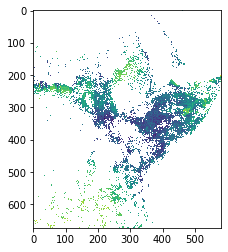

In [256]:
plt.imshow(precip_ea_simplex_multi_sh_pi03)

ndvi single prediction skill for 18 intervals

In [ ]:
ndvi_single_ea_simplex_multi_gr_pi01 = pixelwise_simplex(ndvi_gr_table, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 1)
ndvi_single_ea_simplex_multi_gr_pi02 = pixelwise_simplex(ndvi_gr_table, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 2)
ndvi_single_ea_simplex_multi_gr_pi03 = pixelwise_simplex(ndvi_gr_table, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 3)
ndvi_single_ea_simplex_multi_gr_pi04 = pixelwise_simplex(ndvi_gr_table, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 4)
ndvi_single_ea_simplex_multi_gr_pi05 = pixelwise_simplex(ndvi_gr_table, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 5)
ndvi_single_ea_simplex_multi_gr_pi06 = pixelwise_simplex(ndvi_gr_table, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 6)
ndvi_single_ea_simplex_multi_gr_pi07 = pixelwise_simplex(ndvi_gr_table, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 7)
ndvi_single_ea_simplex_multi_gr_pi08 = pixelwise_simplex(ndvi_gr_table, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 8)
ndvi_single_ea_simplex_multi_gr_pi09 = pixelwise_simplex(ndvi_gr_table, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 9)
ndvi_single_ea_simplex_multi_gr_pi10 = pixelwise_simplex(ndvi_gr_table, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 10)
ndvi_single_ea_simplex_multi_gr_pi11 = pixelwise_simplex(ndvi_gr_table, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 11)
ndvi_single_ea_simplex_multi_gr_pi12 = pixelwise_simplex(ndvi_gr_table, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 12)
ndvi_single_ea_simplex_multi_gr_pi13 = pixelwise_simplex(ndvi_gr_table, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 13)
ndvi_single_ea_simplex_multi_gr_pi14 = pixelwise_simplex(ndvi_gr_table, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 14)
ndvi_single_ea_simplex_multi_gr_pi15 = pixelwise_simplex(ndvi_gr_table, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 15)
ndvi_single_ea_simplex_multi_gr_pi16 = pixelwise_simplex(ndvi_gr_table, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 16)
ndvi_single_ea_simplex_multi_gr_pi17 = pixelwise_simplex(ndvi_gr_table, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 17)
ndvi_single_ea_simplex_multi_gr_pi18 = pixelwise_simplex(ndvi_gr_table, 'ndvi', train = '1 601', test = '1 606', ed = 6, pi = 18)


 53%|█████▎    | 208756/392942 [10:05<09:57, 308.31it/s]

In [ ]:
ndvi_single_anom_ed6_pi18 = pixelwise_simplex(ndvi_table_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 18)

 82%|████████▏ | 322484/392942 [57:52<10:00, 117.39it/s] 

In [82]:
ndvi_single_anom_bo_ed6_pi18 = pixelwise_simplex(ndvi_bo_table_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 18)
ndvi_single_anom_ci_ed6_pi18 = pixelwise_simplex(ndvi_ci_table_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 18)
ndvi_single_anom_cr_ed6_pi18 = pixelwise_simplex(ndvi_cr_table_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 18)
ndvi_single_anom_sh_ed6_pi18 = pixelwise_simplex(ndvi_sh_table_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 18)
ndvi_single_anom_gr_ed6_pi18 = pixelwise_simplex(ndvi_gr_table_anom, 'ndvi', train = '1 303', test = '304 606', ed = 6, pi = 18)

100%|██████████| 392942/392942 [12:36<00:00, 519.09it/s]


In [ ]:
precip_single_anom_bo_ed6_pi18 = pixelwise_simplex(precip_bo_table_anom, 'precip', train = '1 303', test = '304 606', ed = 6, pi = 18)
precip_single_anom_ci_ed6_pi18 = pixelwise_simplex(precip_ci_table_anom, 'precip', train = '1 303', test = '304 606', ed = 6, pi = 18)
precip_single_anom_cr_ed6_pi18 = pixelwise_simplex(precip_cr_table_anom, 'precip', train = '1 303', test = '304 606', ed = 6, pi = 18)
precip_single_anom_sh_ed6_pi18 = pixelwise_simplex(precip_sh_table_anom, 'precip', train = '1 303', test = '304 606', ed = 6, pi = 18)
precip_single_anom_gr_ed6_pi18 = pixelwise_simplex(precip_gr_table_anom, 'precip', train = '1 303', test = '304 606', ed = 6, pi = 18)

 45%|████▌     | 177308/392942 [06:37<23:57, 149.99it/s]

In [40]:
temp_single_anom_bo_ed6_pi18 = pixelwise_simplex(temp_bo_table_anom, 'temp', train = '1 303', test = '304 606', ed = 6, pi = 18)
temp_single_anom_ci_ed6_pi18 = pixelwise_simplex(temp_ci_table_anom, 'temp', train = '1 303', test = '304 606', ed = 6, pi = 18)
temp_single_anom_cr_ed6_pi18 = pixelwise_simplex(temp_cr_table_anom, 'temp', train = '1 303', test = '304 606', ed = 6, pi = 18)
temp_single_anom_sh_ed6_pi18 = pixelwise_simplex(temp_sh_table_anom, 'temp', train = '1 303', test = '304 606', ed = 6, pi = 18)
temp_single_anom_gr_ed6_pi18 = pixelwise_simplex(temp_gr_table_anom, 'temp', train = '1 303', test = '304 606', ed = 6, pi = 18)

100%|██████████| 392942/392942 [15:12<00:00, 430.44it/s]


In [27]:
def array2tiff(array, in_dir, out_dir, out_name):
    
    '''
    This function converts a 2D array into a tif using the profile of an existing tif

    '''
    

    with rasterio.open(in_dir+ os.listdir(in_dir)[0]) as src:
        profile = src.profile

    with rasterio.open(out_dir + out_name + '.tif', 'w', **profile) as dst:
        data = array
        data = data.astype(np.float32)
        #data[data<=0] = np.nan
        dst.write(data, indexes=1)


In [125]:
array2tiff(ndvi_ea_simplex_multi_ond_bo, ndvi_ea, seasonal_simplex, 'ndvi_ea_simplex_multi_ond_bo')

In [126]:
array2tiff(ndvi_ea_simplex_multi_ond_ci, ndvi_ea, seasonal_simplex, 'ndvi_ea_simplex_multi_ond_ci')

In [127]:
array2tiff(ndvi_ea_simplex_multi_ond_cr, ndvi_ea, seasonal_simplex, 'ndvi_ea_simplex_multi_ond_cr')

In [128]:
array2tiff(ndvi_ea_simplex_multi_ond_gr, ndvi_ea, seasonal_simplex, 'ndvi_ea_simplex_multi_ond_gr')

In [129]:
array2tiff(ndvi_ea_simplex_multi_ond_sh, ndvi_ea, seasonal_simplex, 'ndvi_ea_simplex_multi_ond_sh')

In [37]:
array2tiff(ndvi_ea_simplex_multi_ond_cr_03, ndvi_ea, seasonal_simplex, 'ndvi_ea_simplex_multi_ond_cr_03')

In [58]:
array2tiff(ndvi_ea_simplex_multi_mam_cr_18, ndvi_ea, seasonal_simplex, 'ndvi_ea_simplex_multi_mam_cr_18')

In [121]:
array2tiff(ndvi_ea_simplex_multi_cr_pi1, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi01')
array2tiff(ndvi_ea_simplex_multi_cr_pi2, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi02')
array2tiff(ndvi_ea_simplex_multi_cr_pi3, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi03')
array2tiff(ndvi_ea_simplex_multi_cr_pi4, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi04')
array2tiff(ndvi_ea_simplex_multi_cr_pi5, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi05')
array2tiff(ndvi_ea_simplex_multi_cr_pi6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi06')
array2tiff(ndvi_ea_simplex_multi_cr_pi7, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi07')
array2tiff(ndvi_ea_simplex_multi_cr_pi8, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi08')


In [122]:
array2tiff(ndvi_ea_simplex_multi_cr_pi9, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi09')
array2tiff(ndvi_ea_simplex_multi_cr_pi10, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi10')
array2tiff(ndvi_ea_simplex_multi_cr_pi11, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi11')
array2tiff(ndvi_ea_simplex_multi_cr_pi12, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi12')
array2tiff(ndvi_ea_simplex_multi_cr_pi13, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi13')
array2tiff(ndvi_ea_simplex_multi_cr_pi14, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi14')
array2tiff(ndvi_ea_simplex_multi_cr_pi15, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi15')
array2tiff(ndvi_ea_simplex_multi_cr_pi16, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi16')
array2tiff(ndvi_ea_simplex_multi_cr_pi17, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi17')
array2tiff(ndvi_ea_simplex_multi_cr_pi18, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi18')

In [123]:
array2tiff(ndvi_ea_simplex_multi_gr_pi01, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi01')
array2tiff(ndvi_ea_simplex_multi_gr_pi02, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi02')
array2tiff(ndvi_ea_simplex_multi_gr_pi03, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi03')
array2tiff(ndvi_ea_simplex_multi_gr_pi04, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi04')
array2tiff(ndvi_ea_simplex_multi_gr_pi05, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi05')
array2tiff(ndvi_ea_simplex_multi_gr_pi06, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi06')
array2tiff(ndvi_ea_simplex_multi_gr_pi07, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi07')
array2tiff(ndvi_ea_simplex_multi_gr_pi08, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi08')
array2tiff(ndvi_ea_simplex_multi_gr_pi09, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi09')
array2tiff(ndvi_ea_simplex_multi_gr_pi10, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi10')
array2tiff(ndvi_ea_simplex_multi_gr_pi11, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi11')
array2tiff(ndvi_ea_simplex_multi_gr_pi12, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi12')
array2tiff(ndvi_ea_simplex_multi_gr_pi13, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi13')
array2tiff(ndvi_ea_simplex_multi_gr_pi14, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi14')
array2tiff(ndvi_ea_simplex_multi_gr_pi15, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi15')
array2tiff(ndvi_ea_simplex_multi_gr_pi16, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi16')
array2tiff(ndvi_ea_simplex_multi_gr_pi17, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi17')
array2tiff(ndvi_ea_simplex_multi_gr_pi18, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi18')


In [130]:
array2tiff(ndvi_ea_simplex_multi_sh_pi01, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi01')
array2tiff(ndvi_ea_simplex_multi_sh_pi02, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi02')
array2tiff(ndvi_ea_simplex_multi_sh_pi03, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi03')
array2tiff(ndvi_ea_simplex_multi_sh_pi04, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi04')
array2tiff(ndvi_ea_simplex_multi_sh_pi05, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi05')
array2tiff(ndvi_ea_simplex_multi_sh_pi06, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi06')
array2tiff(ndvi_ea_simplex_multi_sh_pi07, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi07')
array2tiff(ndvi_ea_simplex_multi_sh_pi08, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi08')
array2tiff(ndvi_ea_simplex_multi_sh_pi09, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi09')
array2tiff(ndvi_ea_simplex_multi_sh_pi10, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi10')
array2tiff(ndvi_ea_simplex_multi_sh_pi11, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi11')
array2tiff(ndvi_ea_simplex_multi_sh_pi12, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi12')
array2tiff(ndvi_ea_simplex_multi_sh_pi13, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi13')
array2tiff(ndvi_ea_simplex_multi_sh_pi14, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi14')
array2tiff(ndvi_ea_simplex_multi_sh_pi15, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi15')
array2tiff(ndvi_ea_simplex_multi_sh_pi16, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi16')
array2tiff(ndvi_ea_simplex_multi_sh_pi17, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi17')
array2tiff(ndvi_ea_simplex_multi_sh_pi18, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi18')


In [136]:
array2tiff(ndvi_ea_simplex_multi_bo_pi01, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi01')
array2tiff(ndvi_ea_simplex_multi_bo_pi02, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi02')
array2tiff(ndvi_ea_simplex_multi_bo_pi03, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi03')
array2tiff(ndvi_ea_simplex_multi_bo_pi04, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi04')
array2tiff(ndvi_ea_simplex_multi_bo_pi05, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi05')
array2tiff(ndvi_ea_simplex_multi_bo_pi06, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi06')
array2tiff(ndvi_ea_simplex_multi_bo_pi07, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi07')
array2tiff(ndvi_ea_simplex_multi_bo_pi08, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi08')
array2tiff(ndvi_ea_simplex_multi_bo_pi09, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi09')
array2tiff(ndvi_ea_simplex_multi_bo_pi10, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi10')
array2tiff(ndvi_ea_simplex_multi_bo_pi11, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi11')
array2tiff(ndvi_ea_simplex_multi_bo_pi12, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi12')
array2tiff(ndvi_ea_simplex_multi_bo_pi13, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi13')
array2tiff(ndvi_ea_simplex_multi_bo_pi14, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi14')
array2tiff(ndvi_ea_simplex_multi_bo_pi15, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi15')
array2tiff(ndvi_ea_simplex_multi_bo_pi16, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi16')
array2tiff(ndvi_ea_simplex_multi_bo_pi17, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi17')
array2tiff(ndvi_ea_simplex_multi_bo_pi18, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi18')


In [142]:
array2tiff(ndvi_ea_simplex_multi_ci_pi01, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi01')
array2tiff(ndvi_ea_simplex_multi_ci_pi02, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi02')
array2tiff(ndvi_ea_simplex_multi_ci_pi03, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi03')
array2tiff(ndvi_ea_simplex_multi_ci_pi04, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi04')
array2tiff(ndvi_ea_simplex_multi_ci_pi05, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi05')
array2tiff(ndvi_ea_simplex_multi_ci_pi06, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi06')
array2tiff(ndvi_ea_simplex_multi_ci_pi07, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi07')
array2tiff(ndvi_ea_simplex_multi_ci_pi08, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi08')
array2tiff(ndvi_ea_simplex_multi_ci_pi09, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi09')
array2tiff(ndvi_ea_simplex_multi_ci_pi10, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi10')
array2tiff(ndvi_ea_simplex_multi_ci_pi11, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi11')
array2tiff(ndvi_ea_simplex_multi_ci_pi12, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi12')
array2tiff(ndvi_ea_simplex_multi_ci_pi13, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi13')
array2tiff(ndvi_ea_simplex_multi_ci_pi14, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi14')
array2tiff(ndvi_ea_simplex_multi_ci_pi15, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi15')
array2tiff(ndvi_ea_simplex_multi_ci_pi16, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi16')
array2tiff(ndvi_ea_simplex_multi_ci_pi17, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi17')
array2tiff(ndvi_ea_simplex_multi_ci_pi18, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi18')


In [191]:
array2tiff(precip_ea_simplex_multi_cr_pi01, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_cr_pi01')
array2tiff(precip_ea_simplex_multi_cr_pi02, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_cr_pi02')
array2tiff(precip_ea_simplex_multi_cr_pi03, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_cr_pi03')
array2tiff(precip_ea_simplex_multi_cr_pi04, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_cr_pi04')
array2tiff(precip_ea_simplex_multi_cr_pi05, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_cr_pi05')
array2tiff(precip_ea_simplex_multi_cr_pi06, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_cr_pi06')
array2tiff(precip_ea_simplex_multi_cr_pi07, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_cr_pi07')
array2tiff(precip_ea_simplex_multi_cr_pi08, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_cr_pi08')
array2tiff(precip_ea_simplex_multi_cr_pi09, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_cr_pi09')
array2tiff(precip_ea_simplex_multi_cr_pi10, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_cr_pi10')
array2tiff(precip_ea_simplex_multi_cr_pi11, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_cr_pi11')
array2tiff(precip_ea_simplex_multi_cr_pi12, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_cr_pi12')
array2tiff(precip_ea_simplex_multi_cr_pi13, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_cr_pi13')
array2tiff(precip_ea_simplex_multi_cr_pi14, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_cr_pi14')
array2tiff(precip_ea_simplex_multi_cr_pi15, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_cr_pi15')
array2tiff(precip_ea_simplex_multi_cr_pi16, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_cr_pi16')
array2tiff(precip_ea_simplex_multi_cr_pi17, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_cr_pi17')
array2tiff(precip_ea_simplex_multi_cr_pi18, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_cr_pi18')


In [252]:
array2tiff(precip_ea_simplex_multi_ci_pi01, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_ci_pi01')
array2tiff(precip_ea_simplex_multi_ci_pi02, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_ci_pi02')
array2tiff(precip_ea_simplex_multi_ci_pi03, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_ci_pi03')
array2tiff(precip_ea_simplex_multi_ci_pi04, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_ci_pi04')
array2tiff(precip_ea_simplex_multi_ci_pi05, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_ci_pi05')
array2tiff(precip_ea_simplex_multi_ci_pi06, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_ci_pi06')
array2tiff(precip_ea_simplex_multi_ci_pi07, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_ci_pi07')
array2tiff(precip_ea_simplex_multi_ci_pi08, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_ci_pi08')
array2tiff(precip_ea_simplex_multi_ci_pi09, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_ci_pi09')
array2tiff(precip_ea_simplex_multi_ci_pi10, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_ci_pi10')
array2tiff(precip_ea_simplex_multi_ci_pi11, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_ci_pi11')
array2tiff(precip_ea_simplex_multi_ci_pi12, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_ci_pi12')
array2tiff(precip_ea_simplex_multi_ci_pi13, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_ci_pi13')
array2tiff(precip_ea_simplex_multi_ci_pi14, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_ci_pi14')
array2tiff(precip_ea_simplex_multi_ci_pi15, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_ci_pi15')
array2tiff(precip_ea_simplex_multi_ci_pi16, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_ci_pi16')
array2tiff(precip_ea_simplex_multi_ci_pi17, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_ci_pi17')
array2tiff(precip_ea_simplex_multi_ci_pi18, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_ci_pi18')


In [254]:
array2tiff(precip_ea_simplex_multi_bo_pi01, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_bo_pi01')
array2tiff(precip_ea_simplex_multi_bo_pi02, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_bo_pi02')
array2tiff(precip_ea_simplex_multi_bo_pi03, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_bo_pi03')
array2tiff(precip_ea_simplex_multi_bo_pi04, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_bo_pi04')
array2tiff(precip_ea_simplex_multi_bo_pi05, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_bo_pi05')
array2tiff(precip_ea_simplex_multi_bo_pi06, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_bo_pi06')
array2tiff(precip_ea_simplex_multi_bo_pi07, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_bo_pi07')
array2tiff(precip_ea_simplex_multi_bo_pi08, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_bo_pi08')
array2tiff(precip_ea_simplex_multi_bo_pi09, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_bo_pi09')
array2tiff(precip_ea_simplex_multi_bo_pi10, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_bo_pi10')
array2tiff(precip_ea_simplex_multi_bo_pi11, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_bo_pi11')
array2tiff(precip_ea_simplex_multi_bo_pi12, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_bo_pi12')
array2tiff(precip_ea_simplex_multi_bo_pi13, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_bo_pi13')
array2tiff(precip_ea_simplex_multi_bo_pi14, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_bo_pi14')
array2tiff(precip_ea_simplex_multi_bo_pi15, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_bo_pi15')
array2tiff(precip_ea_simplex_multi_bo_pi16, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_bo_pi16')
array2tiff(precip_ea_simplex_multi_bo_pi17, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_bo_pi17')
array2tiff(precip_ea_simplex_multi_bo_pi18, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_bo_pi18')


In [257]:
array2tiff(precip_ea_simplex_multi_sh_pi01, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_sh_pi01')
array2tiff(precip_ea_simplex_multi_sh_pi02, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_sh_pi02')
array2tiff(precip_ea_simplex_multi_sh_pi03, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_sh_pi03')
array2tiff(precip_ea_simplex_multi_sh_pi04, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_sh_pi04')
array2tiff(precip_ea_simplex_multi_sh_pi05, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_sh_pi05')
array2tiff(precip_ea_simplex_multi_sh_pi06, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_sh_pi06')
array2tiff(precip_ea_simplex_multi_sh_pi07, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_sh_pi07')
array2tiff(precip_ea_simplex_multi_sh_pi08, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_sh_pi08')
array2tiff(precip_ea_simplex_multi_sh_pi09, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_sh_pi09')
array2tiff(precip_ea_simplex_multi_sh_pi10, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_sh_pi10')
array2tiff(precip_ea_simplex_multi_sh_pi11, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_sh_pi11')
array2tiff(precip_ea_simplex_multi_sh_pi12, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_sh_pi12')
array2tiff(precip_ea_simplex_multi_sh_pi13, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_sh_pi13')
array2tiff(precip_ea_simplex_multi_sh_pi14, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_sh_pi14')
array2tiff(precip_ea_simplex_multi_sh_pi15, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_sh_pi15')
array2tiff(precip_ea_simplex_multi_sh_pi16, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_sh_pi16')
array2tiff(precip_ea_simplex_multi_sh_pi17, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_sh_pi17')
array2tiff(precip_ea_simplex_multi_sh_pi18, ndvi_ea, prediction_skill_interval, 'precip_ea_simplex_multi_sh_pi18')


In [291]:
array2tiff(ndvi_ea_simplex_multi_ci_ed01, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_ci_ed01')
array2tiff(ndvi_ea_simplex_multi_ci_ed02, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_ci_ed02')
array2tiff(ndvi_ea_simplex_multi_ci_ed03, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_ci_ed03')
array2tiff(ndvi_ea_simplex_multi_ci_ed04, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_ci_ed04')
array2tiff(ndvi_ea_simplex_multi_ci_ed05, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_ci_ed05')
array2tiff(ndvi_ea_simplex_multi_ci_ed06, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_ci_ed06')
array2tiff(ndvi_ea_simplex_multi_ci_ed07, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_ci_ed07')
array2tiff(ndvi_ea_simplex_multi_ci_ed08, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_ci_ed08')
array2tiff(ndvi_ea_simplex_multi_ci_ed09, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_ci_ed09')
array2tiff(ndvi_ea_simplex_multi_ci_ed10, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_ci_ed10')

In [295]:
array2tiff(ndvi_ea_simplex_multi_cr_ed01, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_cr_ed01')
array2tiff(ndvi_ea_simplex_multi_cr_ed02, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_cr_ed02')
array2tiff(ndvi_ea_simplex_multi_cr_ed03, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_cr_ed03')
array2tiff(ndvi_ea_simplex_multi_cr_ed04, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_cr_ed04')
array2tiff(ndvi_ea_simplex_multi_cr_ed05, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_cr_ed05')
array2tiff(ndvi_ea_simplex_multi_cr_ed06, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_cr_ed06')
array2tiff(ndvi_ea_simplex_multi_cr_ed07, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_cr_ed07')
array2tiff(ndvi_ea_simplex_multi_cr_ed08, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_cr_ed08')
array2tiff(ndvi_ea_simplex_multi_cr_ed09, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_cr_ed09')
array2tiff(ndvi_ea_simplex_multi_cr_ed10, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_cr_ed10')

In [298]:
array2tiff(ndvi_ea_simplex_multi_gr_ed01, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_gr_ed01')
array2tiff(ndvi_ea_simplex_multi_gr_ed02, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_gr_ed02')
array2tiff(ndvi_ea_simplex_multi_gr_ed03, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_gr_ed03')
array2tiff(ndvi_ea_simplex_multi_gr_ed04, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_gr_ed04')
array2tiff(ndvi_ea_simplex_multi_gr_ed05, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_gr_ed05')
array2tiff(ndvi_ea_simplex_multi_gr_ed06, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_gr_ed06')
array2tiff(ndvi_ea_simplex_multi_gr_ed07, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_gr_ed07')
array2tiff(ndvi_ea_simplex_multi_gr_ed08, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_gr_ed08')
array2tiff(ndvi_ea_simplex_multi_gr_ed09, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_gr_ed09')
array2tiff(ndvi_ea_simplex_multi_gr_ed10, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_gr_ed10')

In [303]:
array2tiff(ndvi_ea_simplex_multi_sh_ed01, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_sh_ed01')
array2tiff(ndvi_ea_simplex_multi_sh_ed02, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_sh_ed02')
array2tiff(ndvi_ea_simplex_multi_sh_ed03, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_sh_ed03')
array2tiff(ndvi_ea_simplex_multi_sh_ed04, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_sh_ed04')
array2tiff(ndvi_ea_simplex_multi_sh_ed05, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_sh_ed05')
array2tiff(ndvi_ea_simplex_multi_sh_ed06, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_sh_ed06')
array2tiff(ndvi_ea_simplex_multi_sh_ed07, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_sh_ed07')
array2tiff(ndvi_ea_simplex_multi_sh_ed08, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_sh_ed08')
array2tiff(ndvi_ea_simplex_multi_sh_ed09, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_sh_ed09')
array2tiff(ndvi_ea_simplex_multi_sh_ed10, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_sh_ed10')

In [306]:
array2tiff(ndvi_ea_simplex_multi_bo_ed01, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_bo_ed01')
array2tiff(ndvi_ea_simplex_multi_bo_ed02, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_bo_ed02')
array2tiff(ndvi_ea_simplex_multi_bo_ed03, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_bo_ed03')
array2tiff(ndvi_ea_simplex_multi_bo_ed04, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_bo_ed04')
array2tiff(ndvi_ea_simplex_multi_bo_ed05, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_bo_ed05')
array2tiff(ndvi_ea_simplex_multi_bo_ed06, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_bo_ed06')
array2tiff(ndvi_ea_simplex_multi_bo_ed07, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_bo_ed07')
array2tiff(ndvi_ea_simplex_multi_bo_ed08, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_bo_ed08')
array2tiff(ndvi_ea_simplex_multi_bo_ed09, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_bo_ed09')
array2tiff(ndvi_ea_simplex_multi_bo_ed10, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_bo_ed10')

In [311]:
array2tiff(ndvi_ea_simplex_multi_full, ndvi_ea, EA_prediction_skill, 'ndvi_ea_simplex_multi_full')

In [315]:
array2tiff(ndvi_ea_simplex_multi_full_ed10, ndvi_ea, EA_prediction_skill, 'ndvi_ea_simplex_multi_full_ed10')

In [318]:
array2tiff(ndvi_ea_simplex_multi_full_ed10_bo, ndvi_ea, EA_prediction_skill, 'ndvi_ea_simplex_multi_full_ed10_bo')

In [322]:
array2tiff(ndvi_ea_simplex_multi_full_ed10_cr, ndvi_ea, EA_prediction_skill, 'ndvi_ea_simplex_multi_full_ed10_cr')
           

In [326]:
array2tiff(ndvi_ea_simplex_multi_full_ed10_ci, ndvi_ea, EA_prediction_skill, 'ndvi_ea_simplex_multi_full_ed10_ci')
           

In [329]:
array2tiff(ndvi_ea_simplex_multi_full_ed10_sh, ndvi_ea, EA_prediction_skill, 'ndvi_ea_simplex_multi_full_ed10_sh')
           

In [331]:
array2tiff(ndvi_ea_simplex_multi_full_ed10_gr, ndvi_ea, EA_prediction_skill, 'ndvi_ea_simplex_multi_full_ed10_gr')
           

In [335]:
array2tiff(ndvi_ea_simplex_multi_full_ed10_cr_m1, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed10_cr_m1')
array2tiff(ndvi_ea_simplex_multi_full_ed10_cr_m2, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed10_cr_m2')
array2tiff(ndvi_ea_simplex_multi_full_ed10_cr_m3, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed10_cr_m3')
array2tiff(ndvi_ea_simplex_multi_full_ed10_cr_m4, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed10_cr_m4')
array2tiff(ndvi_ea_simplex_multi_full_ed10_cr_m5, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed10_cr_m5')
array2tiff(ndvi_ea_simplex_multi_full_ed10_cr_m6, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed10_cr_m6')
array2tiff(ndvi_ea_simplex_multi_full_ed10_cr_m7, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed10_cr_m7')
array2tiff(ndvi_ea_simplex_multi_full_ed10_cr_m8, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed10_cr_m8')
array2tiff(ndvi_ea_simplex_multi_full_ed10_cr_m9, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed10_cr_m9')
array2tiff(ndvi_ea_simplex_multi_full_ed10_cr_m10, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed10_cr_m10')
array2tiff(ndvi_ea_simplex_multi_full_ed10_cr_m11, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed10_cr_m11')
array2tiff(ndvi_ea_simplex_multi_full_ed10_cr_m12, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed10_cr_m12')

In [337]:
array2tiff(ndvi_ea_simplex_multi_full_ed2_cr_m1, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed2_cr_m1')
array2tiff(ndvi_ea_simplex_multi_full_ed2_cr_m2, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed2_cr_m2')
array2tiff(ndvi_ea_simplex_multi_full_ed2_cr_m3, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed2_cr_m3')
array2tiff(ndvi_ea_simplex_multi_full_ed2_cr_m4, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed2_cr_m4')
array2tiff(ndvi_ea_simplex_multi_full_ed2_cr_m5, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed2_cr_m5')
array2tiff(ndvi_ea_simplex_multi_full_ed2_cr_m6, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed2_cr_m6')
array2tiff(ndvi_ea_simplex_multi_full_ed2_cr_m7, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed2_cr_m7')
array2tiff(ndvi_ea_simplex_multi_full_ed2_cr_m8, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed2_cr_m8')
array2tiff(ndvi_ea_simplex_multi_full_ed2_cr_m9, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed2_cr_m9')
array2tiff(ndvi_ea_simplex_multi_full_ed2_cr_m10, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed2_cr_m10')
array2tiff(ndvi_ea_simplex_multi_full_ed2_cr_m11, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed2_cr_m11')
array2tiff(ndvi_ea_simplex_multi_full_ed2_cr_m12, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed2_cr_m12')

In [438]:
array2tiff(ndvi_ea_simplex_multi_full_ed6_cr_m1, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_cr_m01')
array2tiff(ndvi_ea_simplex_multi_full_ed6_cr_m2, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_cr_m02')
array2tiff(ndvi_ea_simplex_multi_full_ed6_cr_m3, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_cr_m03')
array2tiff(ndvi_ea_simplex_multi_full_ed6_cr_m4, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_cr_m04')
array2tiff(ndvi_ea_simplex_multi_full_ed6_cr_m5, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_cr_m05')
array2tiff(ndvi_ea_simplex_multi_full_ed6_cr_m6, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_cr_m06')
array2tiff(ndvi_ea_simplex_multi_full_ed6_cr_m7, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_cr_m07')
array2tiff(ndvi_ea_simplex_multi_full_ed6_cr_m8, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_cr_m08')
array2tiff(ndvi_ea_simplex_multi_full_ed6_cr_m9, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_cr_m09')
array2tiff(ndvi_ea_simplex_multi_full_ed6_cr_m10, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_cr_m10')
array2tiff(ndvi_ea_simplex_multi_full_ed6_cr_m11, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_cr_m11')
array2tiff(ndvi_ea_simplex_multi_full_ed6_cr_m12, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_cr_m12')


In [439]:
array2tiff(ndvi_ea_simplex_multi_full_ed6_ci_m1, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_ci_m01')
array2tiff(ndvi_ea_simplex_multi_full_ed6_ci_m2, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_ci_m02')
array2tiff(ndvi_ea_simplex_multi_full_ed6_ci_m3, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_ci_m03')
array2tiff(ndvi_ea_simplex_multi_full_ed6_ci_m4, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_ci_m04')
array2tiff(ndvi_ea_simplex_multi_full_ed6_ci_m5, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_ci_m05')
array2tiff(ndvi_ea_simplex_multi_full_ed6_ci_m6, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_ci_m06')
array2tiff(ndvi_ea_simplex_multi_full_ed6_ci_m7, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_ci_m07')
array2tiff(ndvi_ea_simplex_multi_full_ed6_ci_m8, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_ci_m08')
array2tiff(ndvi_ea_simplex_multi_full_ed6_ci_m9, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_ci_m09')
array2tiff(ndvi_ea_simplex_multi_full_ed6_ci_m10, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_ci_m10')
array2tiff(ndvi_ea_simplex_multi_full_ed6_ci_m11, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_ci_m11')
array2tiff(ndvi_ea_simplex_multi_full_ed6_ci_m12, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_ci_m12')


In [428]:
array2tiff(ndvi_ea_simplex_multi_full_ed6_bo_m1, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_bo_m01')
array2tiff(ndvi_ea_simplex_multi_full_ed6_bo_m2, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_bo_m02')
array2tiff(ndvi_ea_simplex_multi_full_ed6_bo_m3, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_bo_m03')
array2tiff(ndvi_ea_simplex_multi_full_ed6_bo_m4, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_bo_m04')
array2tiff(ndvi_ea_simplex_multi_full_ed6_bo_m5, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_bo_m05')
array2tiff(ndvi_ea_simplex_multi_full_ed6_bo_m6, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_bo_m06')
array2tiff(ndvi_ea_simplex_multi_full_ed6_bo_m7, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_bo_m07')
array2tiff(ndvi_ea_simplex_multi_full_ed6_bo_m8, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_bo_m08')
array2tiff(ndvi_ea_simplex_multi_full_ed6_bo_m9, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_bo_m09')
array2tiff(ndvi_ea_simplex_multi_full_ed6_bo_m10, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_bo_m10')
array2tiff(ndvi_ea_simplex_multi_full_ed6_bo_m11, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_bo_m11')
array2tiff(ndvi_ea_simplex_multi_full_ed6_bo_m12, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_bo_m12')

In [26]:
array2tiff(ndvi_ea_simplex_multi_full_ed6_gr_m1, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_gr_m01')
array2tiff(ndvi_ea_simplex_multi_full_ed6_gr_m2, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_gr_m02')
array2tiff(ndvi_ea_simplex_multi_full_ed6_gr_m3, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_gr_m03')
array2tiff(ndvi_ea_simplex_multi_full_ed6_gr_m4, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_gr_m04')
array2tiff(ndvi_ea_simplex_multi_full_ed6_gr_m5, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_gr_m05')
array2tiff(ndvi_ea_simplex_multi_full_ed6_gr_m6, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_gr_m06')
array2tiff(ndvi_ea_simplex_multi_full_ed6_gr_m7, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_gr_m07')
array2tiff(ndvi_ea_simplex_multi_full_ed6_gr_m8, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_gr_m08')
array2tiff(ndvi_ea_simplex_multi_full_ed6_gr_m9, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_gr_m09')
array2tiff(ndvi_ea_simplex_multi_full_ed6_gr_m10, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_gr_m10')
array2tiff(ndvi_ea_simplex_multi_full_ed6_gr_m11, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_gr_m11')
array2tiff(ndvi_ea_simplex_multi_full_ed6_gr_m12, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_gr_m12')

In [24]:
array2tiff(ndvi_ea_simplex_multi_full_ed6_sh_m1, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_sh_m01')
array2tiff(ndvi_ea_simplex_multi_full_ed6_sh_m2, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_sh_m02')
array2tiff(ndvi_ea_simplex_multi_full_ed6_sh_m3, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_sh_m03')
array2tiff(ndvi_ea_simplex_multi_full_ed6_sh_m4, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_sh_m04')
array2tiff(ndvi_ea_simplex_multi_full_ed6_sh_m5, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_sh_m05')
array2tiff(ndvi_ea_simplex_multi_full_ed6_sh_m6, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_sh_m06')
array2tiff(ndvi_ea_simplex_multi_full_ed6_sh_m7, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_sh_m07')
array2tiff(ndvi_ea_simplex_multi_full_ed6_sh_m8, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_sh_m08')
array2tiff(ndvi_ea_simplex_multi_full_ed6_sh_m9, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_sh_m09')
array2tiff(ndvi_ea_simplex_multi_full_ed6_sh_m10, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_sh_m10')
array2tiff(ndvi_ea_simplex_multi_full_ed6_sh_m11, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_sh_m11')
array2tiff(ndvi_ea_simplex_multi_full_ed6_sh_m12, ndvi_ea, pred_skill_clim, 'ndvi_ea_simplex_multi_full_ed6_sh_m12')

In [133]:
array2tiff(ndvi_ea_simplex_multi_ci_pi01_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi01_ed6')
array2tiff(ndvi_ea_simplex_multi_ci_pi02_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi02_ed6')
array2tiff(ndvi_ea_simplex_multi_ci_pi03_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi03_ed6')
array2tiff(ndvi_ea_simplex_multi_ci_pi04_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi04_ed6')
array2tiff(ndvi_ea_simplex_multi_ci_pi05_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi05_ed6')
array2tiff(ndvi_ea_simplex_multi_ci_pi06_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi06_ed6')
array2tiff(ndvi_ea_simplex_multi_ci_pi07_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi07_ed6')
array2tiff(ndvi_ea_simplex_multi_ci_pi08_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi08_ed6')
array2tiff(ndvi_ea_simplex_multi_ci_pi09_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi09_ed6')
array2tiff(ndvi_ea_simplex_multi_ci_pi10_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi10_ed6')
array2tiff(ndvi_ea_simplex_multi_ci_pi11_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi11_ed6')
array2tiff(ndvi_ea_simplex_multi_ci_pi12_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi12_ed6')
array2tiff(ndvi_ea_simplex_multi_ci_pi13_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi13_ed6')
array2tiff(ndvi_ea_simplex_multi_ci_pi14_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi14_ed6')
array2tiff(ndvi_ea_simplex_multi_ci_pi15_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi15_ed6')
array2tiff(ndvi_ea_simplex_multi_ci_pi16_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi16_ed6')



In [151]:
array2tiff(ndvi_ea_simplex_multi_ci_pi17_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi17_ed6')
array2tiff(ndvi_ea_simplex_multi_ci_pi18_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi18_ed6')


In [134]:
array2tiff(ndvi_ea_simplex_multi_cr_pi01_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi01_ed6')
array2tiff(ndvi_ea_simplex_multi_cr_pi02_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi02_ed6')
array2tiff(ndvi_ea_simplex_multi_cr_pi03_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi03_ed6')
array2tiff(ndvi_ea_simplex_multi_cr_pi04_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi04_ed6')
array2tiff(ndvi_ea_simplex_multi_cr_pi05_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi05_ed6')
array2tiff(ndvi_ea_simplex_multi_cr_pi06_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi06_ed6')
array2tiff(ndvi_ea_simplex_multi_cr_pi07_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi07_ed6')
array2tiff(ndvi_ea_simplex_multi_cr_pi08_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi08_ed6')
array2tiff(ndvi_ea_simplex_multi_cr_pi09_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi09_ed6')
array2tiff(ndvi_ea_simplex_multi_cr_pi10_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi10_ed6')
array2tiff(ndvi_ea_simplex_multi_cr_pi11_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi11_ed6')
array2tiff(ndvi_ea_simplex_multi_cr_pi12_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi12_ed6')
array2tiff(ndvi_ea_simplex_multi_cr_pi13_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi13_ed6')
array2tiff(ndvi_ea_simplex_multi_cr_pi14_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi14_ed6')
array2tiff(ndvi_ea_simplex_multi_cr_pi15_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi15_ed6')
array2tiff(ndvi_ea_simplex_multi_cr_pi16_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi16_ed6')



In [152]:
array2tiff(ndvi_ea_simplex_multi_cr_pi17_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi17_ed6')
array2tiff(ndvi_ea_simplex_multi_cr_pi18_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi18_ed6')


In [143]:
array2tiff(ndvi_ea_simplex_multi_gr_pi01_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi01_ed6')
array2tiff(ndvi_ea_simplex_multi_gr_pi02_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi02_ed6')
array2tiff(ndvi_ea_simplex_multi_gr_pi03_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi03_ed6')
array2tiff(ndvi_ea_simplex_multi_gr_pi04_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi04_ed6')
array2tiff(ndvi_ea_simplex_multi_gr_pi05_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi05_ed6')
array2tiff(ndvi_ea_simplex_multi_gr_pi06_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi06_ed6')
array2tiff(ndvi_ea_simplex_multi_gr_pi07_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi07_ed6')
array2tiff(ndvi_ea_simplex_multi_gr_pi08_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi08_ed6')
array2tiff(ndvi_ea_simplex_multi_gr_pi09_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi09_ed6')
array2tiff(ndvi_ea_simplex_multi_gr_pi10_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi10_ed6')
array2tiff(ndvi_ea_simplex_multi_gr_pi11_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi11_ed6')
array2tiff(ndvi_ea_simplex_multi_gr_pi12_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi12_ed6')
array2tiff(ndvi_ea_simplex_multi_gr_pi13_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi13_ed6')
array2tiff(ndvi_ea_simplex_multi_gr_pi14_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi14_ed6')
array2tiff(ndvi_ea_simplex_multi_gr_pi15_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi15_ed6')
array2tiff(ndvi_ea_simplex_multi_gr_pi16_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi16_ed6')



In [153]:
array2tiff(ndvi_ea_simplex_multi_gr_pi17_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi17_ed6')
array2tiff(ndvi_ea_simplex_multi_gr_pi18_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi18_ed6')


In [144]:
array2tiff(ndvi_ea_simplex_multi_sh_pi01_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi01_ed6')
array2tiff(ndvi_ea_simplex_multi_sh_pi02_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi02_ed6')
array2tiff(ndvi_ea_simplex_multi_sh_pi03_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi03_ed6')
array2tiff(ndvi_ea_simplex_multi_sh_pi04_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi04_ed6')
array2tiff(ndvi_ea_simplex_multi_sh_pi05_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi05_ed6')
array2tiff(ndvi_ea_simplex_multi_sh_pi06_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi06_ed6')
array2tiff(ndvi_ea_simplex_multi_sh_pi07_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi07_ed6')
array2tiff(ndvi_ea_simplex_multi_sh_pi08_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi08_ed6')
array2tiff(ndvi_ea_simplex_multi_sh_pi09_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi09_ed6')
array2tiff(ndvi_ea_simplex_multi_sh_pi10_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi10_ed6')
array2tiff(ndvi_ea_simplex_multi_sh_pi11_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi11_ed6')
array2tiff(ndvi_ea_simplex_multi_sh_pi12_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi12_ed6')
array2tiff(ndvi_ea_simplex_multi_sh_pi13_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi13_ed6')
array2tiff(ndvi_ea_simplex_multi_sh_pi14_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi14_ed6')
array2tiff(ndvi_ea_simplex_multi_sh_pi15_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi15_ed6')
array2tiff(ndvi_ea_simplex_multi_sh_pi16_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi16_ed6')



In [154]:
array2tiff(ndvi_ea_simplex_multi_sh_pi17_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi17_ed6')
array2tiff(ndvi_ea_simplex_multi_sh_pi18_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi18_ed6')


In [150]:
array2tiff(ndvi_ea_simplex_multi_bo_pi01_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi01_ed6')
array2tiff(ndvi_ea_simplex_multi_bo_pi02_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi02_ed6')
array2tiff(ndvi_ea_simplex_multi_bo_pi03_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi03_ed6')
array2tiff(ndvi_ea_simplex_multi_bo_pi04_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi04_ed6')
array2tiff(ndvi_ea_simplex_multi_bo_pi05_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi05_ed6')
array2tiff(ndvi_ea_simplex_multi_bo_pi06_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi06_ed6')
array2tiff(ndvi_ea_simplex_multi_bo_pi07_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi07_ed6')
array2tiff(ndvi_ea_simplex_multi_bo_pi08_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi08_ed6')
array2tiff(ndvi_ea_simplex_multi_bo_pi09_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi09_ed6')
array2tiff(ndvi_ea_simplex_multi_bo_pi10_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi10_ed6')
array2tiff(ndvi_ea_simplex_multi_bo_pi11_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi11_ed6')
array2tiff(ndvi_ea_simplex_multi_bo_pi12_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi12_ed6')
array2tiff(ndvi_ea_simplex_multi_bo_pi13_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi13_ed6')
array2tiff(ndvi_ea_simplex_multi_bo_pi14_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi14_ed6')
array2tiff(ndvi_ea_simplex_multi_bo_pi15_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi15_ed6')
array2tiff(ndvi_ea_simplex_multi_bo_pi16_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi16_ed6')



In [155]:
array2tiff(ndvi_ea_simplex_multi_bo_pi17_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi17_ed6')
array2tiff(ndvi_ea_simplex_multi_bo_pi18_ed6, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi18_ed6')


In [173]:
array2tiff(ndvi_single_ea_simplex_multi_gr_pi01, ndvi_ea, prediction_skill_interval, 'ndvi_single_ea_simplex_multi_gr_pi01')
array2tiff(ndvi_single_ea_simplex_multi_gr_pi02, ndvi_ea, prediction_skill_interval, 'ndvi_single_ea_simplex_multi_gr_pi02')
array2tiff(ndvi_single_ea_simplex_multi_gr_pi03, ndvi_ea, prediction_skill_interval, 'ndvi_single_ea_simplex_multi_gr_pi03')
array2tiff(ndvi_single_ea_simplex_multi_gr_pi04, ndvi_ea, prediction_skill_interval, 'ndvi_single_ea_simplex_multi_gr_pi04')
array2tiff(ndvi_single_ea_simplex_multi_gr_pi05, ndvi_ea, prediction_skill_interval, 'ndvi_single_ea_simplex_multi_gr_pi05')
array2tiff(ndvi_single_ea_simplex_multi_gr_pi06, ndvi_ea, prediction_skill_interval, 'ndvi_single_ea_simplex_multi_gr_pi06')
array2tiff(ndvi_single_ea_simplex_multi_gr_pi07, ndvi_ea, prediction_skill_interval, 'ndvi_single_ea_simplex_multi_gr_pi07')
array2tiff(ndvi_single_ea_simplex_multi_gr_pi08, ndvi_ea, prediction_skill_interval, 'ndvi_single_ea_simplex_multi_gr_pi08')
array2tiff(ndvi_single_ea_simplex_multi_gr_pi09, ndvi_ea, prediction_skill_interval, 'ndvi_single_ea_simplex_multi_gr_pi09')
array2tiff(ndvi_single_ea_simplex_multi_gr_pi10, ndvi_ea, prediction_skill_interval, 'ndvi_single_ea_simplex_multi_gr_pi10')
array2tiff(ndvi_single_ea_simplex_multi_gr_pi11, ndvi_ea, prediction_skill_interval, 'ndvi_single_ea_simplex_multi_gr_pi11')
array2tiff(ndvi_single_ea_simplex_multi_gr_pi12, ndvi_ea, prediction_skill_interval, 'ndvi_single_ea_simplex_multi_gr_pi12')
array2tiff(ndvi_single_ea_simplex_multi_gr_pi13, ndvi_ea, prediction_skill_interval, 'ndvi_single_ea_simplex_multi_gr_pi13')
array2tiff(ndvi_single_ea_simplex_multi_gr_pi14, ndvi_ea, prediction_skill_interval, 'ndvi_single_ea_simplex_multi_gr_pi14')
array2tiff(ndvi_single_ea_simplex_multi_gr_pi15, ndvi_ea, prediction_skill_interval, 'ndvi_single_ea_simplex_multi_gr_pi15')
array2tiff(ndvi_single_ea_simplex_multi_gr_pi16, ndvi_ea, prediction_skill_interval, 'ndvi_single_ea_simplex_multi_gr_pi16')
array2tiff(ndvi_single_ea_simplex_multi_gr_pi17, ndvi_ea, prediction_skill_interval, 'ndvi_single_ea_simplex_multi_gr_pi17')
array2tiff(ndvi_single_ea_simplex_multi_gr_pi18, ndvi_ea, prediction_skill_interval, 'ndvi_single_ea_simplex_multi_gr_pi18')


In [179]:
array2tiff(ndvi_single_anom_ed6_pi18, ndvi_ea, EA_prediction_skill, 'ndvi_single_anom_ed6_pi18')

In [37]:
array2tiff(ndvi_single_anom_bo_ed6_pi18, ndvi_ea, anomaly_maps, 'ndvi_single_anom_bo_ed6_pi18')
array2tiff(ndvi_single_anom_cr_ed6_pi18, ndvi_ea, anomaly_maps, 'ndvi_single_anom_cr_ed6_pi18')
array2tiff(ndvi_single_anom_ci_ed6_pi18, ndvi_ea, anomaly_maps, 'ndvi_single_anom_ci_ed6_pi18')
array2tiff(ndvi_single_anom_gr_ed6_pi18, ndvi_ea, anomaly_maps, 'ndvi_single_anom_gr_ed6_pi18')
array2tiff(ndvi_single_anom_sh_ed6_pi18, ndvi_ea, anomaly_maps, 'ndvi_single_anom_sh_ed6_pi18')

In [38]:
array2tiff(precip_single_anom_bo_ed6_pi18, ndvi_ea, anomaly_maps, 'precip_single_anom_bo_ed6_pi18')
array2tiff(precip_single_anom_cr_ed6_pi18, ndvi_ea, anomaly_maps, 'precip_single_anom_cr_ed6_pi18')
array2tiff(precip_single_anom_ci_ed6_pi18, ndvi_ea, anomaly_maps, 'precip_single_anom_ci_ed6_pi18')
array2tiff(precip_single_anom_gr_ed6_pi18, ndvi_ea, anomaly_maps, 'precip_single_anom_gr_ed6_pi18')
array2tiff(precip_single_anom_sh_ed6_pi18, ndvi_ea, anomaly_maps, 'precip_single_anom_sh_ed6_pi18')

In [41]:
array2tiff(temp_single_anom_bo_ed6_pi18, ndvi_ea, anomaly_maps, 'temp_single_anom_bo_ed6_pi18')
array2tiff(temp_single_anom_cr_ed6_pi18, ndvi_ea, anomaly_maps, 'temp_single_anom_cr_ed6_pi18')
array2tiff(temp_single_anom_ci_ed6_pi18, ndvi_ea, anomaly_maps, 'temp_single_anom_ci_ed6_pi18')
array2tiff(temp_single_anom_gr_ed6_pi18, ndvi_ea, anomaly_maps, 'temp_single_anom_gr_ed6_pi18')
array2tiff(temp_single_anom_sh_ed6_pi18, ndvi_ea, anomaly_maps, 'temp_single_anom_sh_ed6_pi18')

In [55]:
array2tiff(precip_ea_simplex_multi_cr_pi01, ndvi_ea, prediction_skill_interval, 'precip_anom_ea_simplex_single_cr_pi01')
array2tiff(precip_anom_ea_simplex_multi_cr_pi02, ndvi_ea, prediction_skill_interval, 'precip_anom_ea_simplex_single_cr_pi02')
array2tiff(precip_anom_ea_simplex_multi_cr_pi03, ndvi_ea, prediction_skill_interval, 'precip_anom_ea_simplex_single_cr_pi03')
array2tiff(precip_anom_ea_simplex_multi_cr_pi04, ndvi_ea, prediction_skill_interval, 'precip_anom_ea_simplex_single_cr_pi04')
array2tiff(precip_anom_ea_simplex_multi_cr_pi05, ndvi_ea, prediction_skill_interval, 'precip_anom_ea_simplex_single_cr_pi05')
array2tiff(precip_anom_ea_simplex_multi_cr_pi06, ndvi_ea, prediction_skill_interval, 'precip_anom_ea_simplex_single_cr_pi06')
array2tiff(precip_anom_ea_simplex_multi_cr_pi07, ndvi_ea, prediction_skill_interval, 'precip_anom_ea_simplex_single_cr_pi07')
array2tiff(precip_anom_ea_simplex_multi_cr_pi08, ndvi_ea, prediction_skill_interval, 'precip_anom_ea_simplex_single_cr_pi08')
array2tiff(precip_anom_ea_simplex_multi_cr_pi09, ndvi_ea, prediction_skill_interval, 'precip_anom_ea_simplex_single_cr_pi09')
array2tiff(precip_anom_ea_simplex_multi_cr_pi10, ndvi_ea, prediction_skill_interval, 'precip_anom_ea_simplex_single_cr_pi10')
array2tiff(precip_anom_ea_simplex_multi_cr_pi11, ndvi_ea, prediction_skill_interval, 'precip_anom_ea_simplex_single_cr_pi11')
array2tiff(precip_anom_ea_simplex_multi_cr_pi12, ndvi_ea, prediction_skill_interval, 'precip_anom_ea_simplex_single_cr_pi12')
array2tiff(precip_anom_ea_simplex_multi_cr_pi13, ndvi_ea, prediction_skill_interval, 'precip_anom_ea_simplex_single_cr_pi13')
array2tiff(precip_anom_ea_simplex_multi_cr_pi14, ndvi_ea, prediction_skill_interval, 'precip_anom_ea_simplex_single_cr_pi14')
array2tiff(precip_anom_ea_simplex_multi_cr_pi15, ndvi_ea, prediction_skill_interval, 'precip_anom_ea_simplex_single_cr_pi15')
array2tiff(precip_anom_ea_simplex_multi_cr_pi16, ndvi_ea, prediction_skill_interval, 'precip_anom_ea_simplex_single_cr_pi16')
array2tiff(precip_anom_ea_simplex_multi_cr_pi17, ndvi_ea, prediction_skill_interval, 'precip_anom_ea_simplex_single_cr_pi17')
array2tiff(precip_anom_ea_simplex_multi_cr_pi18, ndvi_ea, prediction_skill_interval, 'precip_anom_ea_simplex_single_cr_pi18')

In [56]:
array2tiff(precip_anom_ea_simplex_multi_ci_pi01, ndvi_ea, prediction_skill_interval, 'precip_anom_ea_simplex_single_ci_pi01')
array2tiff(precip_anom_ea_simplex_multi_ci_pi02, ndvi_ea, prediction_skill_interval, 'precip_anom_ea_simplex_single_ci_pi02')
array2tiff(precip_anom_ea_simplex_multi_ci_pi03, ndvi_ea, prediction_skill_interval, 'precip_anom_ea_simplex_single_ci_pi03')
array2tiff(precip_anom_ea_simplex_multi_ci_pi04, ndvi_ea, prediction_skill_interval, 'precip_anom_ea_simplex_single_ci_pi04')
array2tiff(precip_anom_ea_simplex_multi_ci_pi05, ndvi_ea, prediction_skill_interval, 'precip_anom_ea_simplex_single_ci_pi05')
array2tiff(precip_anom_ea_simplex_multi_ci_pi06, ndvi_ea, prediction_skill_interval, 'precip_anom_ea_simplex_single_ci_pi06')
array2tiff(precip_anom_ea_simplex_multi_ci_pi07, ndvi_ea, prediction_skill_interval, 'precip_anom_ea_simplex_single_ci_pi07')
array2tiff(precip_anom_ea_simplex_multi_ci_pi08, ndvi_ea, prediction_skill_interval, 'precip_anom_ea_simplex_single_ci_pi08')
array2tiff(precip_anom_ea_simplex_multi_ci_pi09, ndvi_ea, prediction_skill_interval, 'precip_anom_ea_simplex_single_ci_pi09')
array2tiff(precip_anom_ea_simplex_multi_ci_pi10, ndvi_ea, prediction_skill_interval, 'precip_anom_ea_simplex_single_ci_pi10')
array2tiff(precip_anom_ea_simplex_multi_ci_pi11, ndvi_ea, prediction_skill_interval, 'precip_anom_ea_simplex_single_ci_pi11')
array2tiff(precip_anom_ea_simplex_multi_ci_pi12, ndvi_ea, prediction_skill_interval, 'precip_anom_ea_simplex_single_ci_pi12')
array2tiff(precip_anom_ea_simplex_multi_ci_pi13, ndvi_ea, prediction_skill_interval, 'precip_anom_ea_simplex_single_ci_pi13')
array2tiff(precip_anom_ea_simplex_multi_ci_pi14, ndvi_ea, prediction_skill_interval, 'precip_anom_ea_simplex_single_ci_pi14')
array2tiff(precip_anom_ea_simplex_multi_ci_pi15, ndvi_ea, prediction_skill_interval, 'precip_anom_ea_simplex_single_ci_pi15')
array2tiff(precip_anom_ea_simplex_multi_ci_pi16, ndvi_ea, prediction_skill_interval, 'precip_anom_ea_simplex_single_ci_pi16')
array2tiff(precip_anom_ea_simplex_multi_ci_pi17, ndvi_ea, prediction_skill_interval, 'precip_anom_ea_simplex_single_ci_pi17')
array2tiff(precip_anom_ea_simplex_multi_ci_pi18, ndvi_ea, prediction_skill_interval, 'precip_anom_ea_simplex_single_ci_pi18')

In [31]:
array2tiff(ndvi_ea_simplex_multi_ci_pi01_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi01_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_ci_pi02_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi02_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_ci_pi03_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi03_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_ci_pi04_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi04_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_ci_pi05_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi05_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_ci_pi06_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi06_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_ci_pi07_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi07_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_ci_pi08_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi08_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_ci_pi09_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi09_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_ci_pi10_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi10_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_ci_pi11_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi11_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_ci_pi12_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi12_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_ci_pi13_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi13_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_ci_pi14_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi14_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_ci_pi15_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi15_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_ci_pi16_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi16_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_ci_pi17_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi17_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_ci_pi18_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_ci_pi18_ed6_anom')

In [32]:
array2tiff(ndvi_ea_simplex_multi_cr_pi01_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi01_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_cr_pi02_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi02_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_cr_pi03_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi03_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_cr_pi04_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi04_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_cr_pi05_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi05_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_cr_pi06_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi06_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_cr_pi07_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi07_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_cr_pi08_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi08_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_cr_pi09_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi09_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_cr_pi10_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi10_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_cr_pi11_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi11_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_cr_pi12_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi12_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_cr_pi13_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi13_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_cr_pi14_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi14_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_cr_pi15_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi15_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_cr_pi16_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi16_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_cr_pi17_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi17_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_cr_pi18_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_cr_pi18_ed6_anom')

In [37]:
array2tiff(ndvi_ea_simplex_multi_gr_pi01_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi01_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_gr_pi02_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi02_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_gr_pi03_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi03_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_gr_pi04_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi04_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_gr_pi05_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi05_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_gr_pi06_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi06_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_gr_pi07_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi07_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_gr_pi08_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi08_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_gr_pi09_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi09_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_gr_pi10_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi10_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_gr_pi11_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi11_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_gr_pi12_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi12_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_gr_pi13_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi13_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_gr_pi14_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi14_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_gr_pi15_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi15_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_gr_pi16_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi16_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_gr_pi17_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi17_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_gr_pi18_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_gr_pi18_ed6_anom')

In [38]:
array2tiff(ndvi_ea_simplex_multi_sh_pi01_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi01_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_sh_pi02_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi02_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_sh_pi03_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi03_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_sh_pi04_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi04_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_sh_pi05_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi05_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_sh_pi06_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi06_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_sh_pi07_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi07_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_sh_pi08_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi08_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_sh_pi09_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi09_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_sh_pi10_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi10_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_sh_pi11_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi11_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_sh_pi12_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi12_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_sh_pi13_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi13_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_sh_pi14_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi14_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_sh_pi15_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi15_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_sh_pi16_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi16_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_sh_pi17_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi17_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_sh_pi18_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_sh_pi18_ed6_anom')

In [43]:
array2tiff(ndvi_ea_simplex_multi_bo_pi01_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi01_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_bo_pi02_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi02_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_bo_pi03_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi03_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_bo_pi04_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi04_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_bo_pi05_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi05_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_bo_pi06_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi06_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_bo_pi07_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi07_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_bo_pi08_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi08_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_bo_pi09_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi09_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_bo_pi10_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi10_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_bo_pi11_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi11_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_bo_pi12_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi12_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_bo_pi13_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi13_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_bo_pi14_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi14_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_bo_pi15_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi15_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_bo_pi16_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi16_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_bo_pi17_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi17_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_bo_pi18_ed6_anom, ndvi_ea, prediction_skill_interval, 'ndvi_ea_simplex_multi_bo_pi18_ed6_anom')

In [51]:
array2tiff(ndvi_ea_simplex_multi_ci_pi6_ed01_anom, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_ci_pi6_ed01_anom')
array2tiff(ndvi_ea_simplex_multi_ci_pi6_ed02_anom, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_ci_pi6_ed02_anom')
array2tiff(ndvi_ea_simplex_multi_ci_pi6_ed03_anom, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_ci_pi6_ed03_anom')
array2tiff(ndvi_ea_simplex_multi_ci_pi6_ed04_anom, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_ci_pi6_ed04_anom')
array2tiff(ndvi_ea_simplex_multi_ci_pi6_ed05_anom, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_ci_pi6_ed05_anom')
array2tiff(ndvi_ea_simplex_multi_ci_pi6_ed06_anom, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_ci_pi6_ed06_anom')
array2tiff(ndvi_ea_simplex_multi_ci_pi6_ed07_anom, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_ci_pi6_ed07_anom')
array2tiff(ndvi_ea_simplex_multi_ci_pi6_ed08_anom, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_ci_pi6_ed08_anom')
array2tiff(ndvi_ea_simplex_multi_ci_pi6_ed09_anom, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_ci_pi6_ed09_anom')
array2tiff(ndvi_ea_simplex_multi_ci_pi6_ed10_anom, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_ci_pi6_ed10_anom')

In [52]:
array2tiff(ndvi_ea_simplex_multi_cr_pi6_ed01_anom, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_cr_pi6_ed01_anom')
array2tiff(ndvi_ea_simplex_multi_cr_pi6_ed02_anom, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_cr_pi6_ed02_anom')
array2tiff(ndvi_ea_simplex_multi_cr_pi6_ed03_anom, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_cr_pi6_ed03_anom')
array2tiff(ndvi_ea_simplex_multi_cr_pi6_ed04_anom, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_cr_pi6_ed04_anom')
array2tiff(ndvi_ea_simplex_multi_cr_pi6_ed05_anom, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_cr_pi6_ed05_anom')
array2tiff(ndvi_ea_simplex_multi_cr_pi6_ed06_anom, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_cr_pi6_ed06_anom')
array2tiff(ndvi_ea_simplex_multi_cr_pi6_ed07_anom, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_cr_pi6_ed07_anom')
array2tiff(ndvi_ea_simplex_multi_cr_pi6_ed08_anom, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_cr_pi6_ed08_anom')
array2tiff(ndvi_ea_simplex_multi_cr_pi6_ed09_anom, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_cr_pi6_ed09_anom')
array2tiff(ndvi_ea_simplex_multi_cr_pi6_ed10_anom, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_cr_pi6_ed10_anom')

In [53]:
array2tiff(ndvi_ea_simplex_multi_gr_pi6_ed01_anom, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_gr_pi6_ed01_anom')
array2tiff(ndvi_ea_simplex_multi_gr_pi6_ed02_anom, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_gr_pi6_ed02_anom')
array2tiff(ndvi_ea_simplex_multi_gr_pi6_ed03_anom, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_gr_pi6_ed03_anom')
array2tiff(ndvi_ea_simplex_multi_gr_pi6_ed04_anom, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_gr_pi6_ed04_anom')
array2tiff(ndvi_ea_simplex_multi_gr_pi6_ed05_anom, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_gr_pi6_ed05_anom')
array2tiff(ndvi_ea_simplex_multi_gr_pi6_ed06_anom, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_gr_pi6_ed06_anom')
array2tiff(ndvi_ea_simplex_multi_gr_pi6_ed07_anom, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_gr_pi6_ed07_anom')
array2tiff(ndvi_ea_simplex_multi_gr_pi6_ed08_anom, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_gr_pi6_ed08_anom')
array2tiff(ndvi_ea_simplex_multi_gr_pi6_ed09_anom, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_gr_pi6_ed09_anom')
array2tiff(ndvi_ea_simplex_multi_gr_pi6_ed10_anom, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_gr_pi6_ed10_anom')

In [54]:
array2tiff(ndvi_ea_simplex_multi_sh_pi6_ed01_anom, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_sh_pi6_ed01_anom')
array2tiff(ndvi_ea_simplex_multi_sh_pi6_ed02_anom, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_sh_pi6_ed02_anom')
array2tiff(ndvi_ea_simplex_multi_sh_pi6_ed03_anom, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_sh_pi6_ed03_anom')
array2tiff(ndvi_ea_simplex_multi_sh_pi6_ed04_anom, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_sh_pi6_ed04_anom')
array2tiff(ndvi_ea_simplex_multi_sh_pi6_ed05_anom, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_sh_pi6_ed05_anom')
array2tiff(ndvi_ea_simplex_multi_sh_pi6_ed06_anom, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_sh_pi6_ed06_anom')
array2tiff(ndvi_ea_simplex_multi_sh_pi6_ed07_anom, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_sh_pi6_ed07_anom')
array2tiff(ndvi_ea_simplex_multi_sh_pi6_ed08_anom, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_sh_pi6_ed08_anom')
array2tiff(ndvi_ea_simplex_multi_sh_pi6_ed09_anom, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_sh_pi6_ed09_anom')
array2tiff(ndvi_ea_simplex_multi_sh_pi6_ed10_anom, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_sh_pi6_ed10_anom')

In [55]:
array2tiff(ndvi_ea_simplex_multi_bo_pi6_ed01_anom, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_bo_pi6_ed01_anom')
array2tiff(ndvi_ea_simplex_multi_bo_pi6_ed02_anom, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_bo_pi6_ed02_anom')
array2tiff(ndvi_ea_simplex_multi_bo_pi6_ed03_anom, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_bo_pi6_ed03_anom')
array2tiff(ndvi_ea_simplex_multi_bo_pi6_ed04_anom, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_bo_pi6_ed04_anom')
array2tiff(ndvi_ea_simplex_multi_bo_pi6_ed05_anom, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_bo_pi6_ed05_anom')
array2tiff(ndvi_ea_simplex_multi_bo_pi6_ed06_anom, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_bo_pi6_ed06_anom')
array2tiff(ndvi_ea_simplex_multi_bo_pi6_ed07_anom, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_bo_pi6_ed07_anom')
array2tiff(ndvi_ea_simplex_multi_bo_pi6_ed08_anom, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_bo_pi6_ed08_anom')
array2tiff(ndvi_ea_simplex_multi_bo_pi6_ed09_anom, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_bo_pi6_ed09_anom')
array2tiff(ndvi_ea_simplex_multi_bo_pi6_ed10_anom, ndvi_ea, prediction_skill_ed, 'ndvi_ea_simplex_multi_bo_pi6_ed10_anom')

In [75]:
array2tiff(ndvi_ea_simplex_multi_ci_pi6_ed01_anom_hh, ndvi_ea, prediction_skill_ed_anom_hh, 'ndvi_ea_simplex_multi_ci_pi6_ed01_anom_hh')
array2tiff(ndvi_ea_simplex_multi_ci_pi6_ed02_anom_hh, ndvi_ea, prediction_skill_ed_anom_hh, 'ndvi_ea_simplex_multi_ci_pi6_ed02_anom_hh')
array2tiff(ndvi_ea_simplex_multi_ci_pi6_ed03_anom_hh, ndvi_ea, prediction_skill_ed_anom_hh, 'ndvi_ea_simplex_multi_ci_pi6_ed03_anom_hh')
array2tiff(ndvi_ea_simplex_multi_ci_pi6_ed04_anom_hh, ndvi_ea, prediction_skill_ed_anom_hh, 'ndvi_ea_simplex_multi_ci_pi6_ed04_anom_hh')
array2tiff(ndvi_ea_simplex_multi_ci_pi6_ed05_anom_hh, ndvi_ea, prediction_skill_ed_anom_hh, 'ndvi_ea_simplex_multi_ci_pi6_ed05_anom_hh')
array2tiff(ndvi_ea_simplex_multi_ci_pi6_ed06_anom_hh, ndvi_ea, prediction_skill_ed_anom_hh, 'ndvi_ea_simplex_multi_ci_pi6_ed06_anom_hh')
array2tiff(ndvi_ea_simplex_multi_ci_pi6_ed07_anom_hh, ndvi_ea, prediction_skill_ed_anom_hh, 'ndvi_ea_simplex_multi_ci_pi6_ed07_anom_hh')
array2tiff(ndvi_ea_simplex_multi_ci_pi6_ed08_anom_hh, ndvi_ea, prediction_skill_ed_anom_hh, 'ndvi_ea_simplex_multi_ci_pi6_ed08_anom_hh')
array2tiff(ndvi_ea_simplex_multi_ci_pi6_ed09_anom_hh, ndvi_ea, prediction_skill_ed_anom_hh, 'ndvi_ea_simplex_multi_ci_pi6_ed09_anom_hh')
array2tiff(ndvi_ea_simplex_multi_ci_pi6_ed10_anom_hh, ndvi_ea, prediction_skill_ed_anom_hh, 'ndvi_ea_simplex_multi_ci_pi6_ed10_anom_hh')

In [76]:
array2tiff(ndvi_ea_simplex_multi_cr_pi6_ed01_anom_hh, ndvi_ea, prediction_skill_ed_anom_hh, 'ndvi_ea_simplex_multi_cr_pi6_ed01_anom_hh')
array2tiff(ndvi_ea_simplex_multi_cr_pi6_ed02_anom_hh, ndvi_ea, prediction_skill_ed_anom_hh, 'ndvi_ea_simplex_multi_cr_pi6_ed02_anom_hh')
array2tiff(ndvi_ea_simplex_multi_cr_pi6_ed03_anom_hh, ndvi_ea, prediction_skill_ed_anom_hh, 'ndvi_ea_simplex_multi_cr_pi6_ed03_anom_hh')
array2tiff(ndvi_ea_simplex_multi_cr_pi6_ed04_anom_hh, ndvi_ea, prediction_skill_ed_anom_hh, 'ndvi_ea_simplex_multi_cr_pi6_ed04_anom_hh')
array2tiff(ndvi_ea_simplex_multi_cr_pi6_ed05_anom_hh, ndvi_ea, prediction_skill_ed_anom_hh, 'ndvi_ea_simplex_multi_cr_pi6_ed05_anom_hh')
array2tiff(ndvi_ea_simplex_multi_cr_pi6_ed06_anom_hh, ndvi_ea, prediction_skill_ed_anom_hh, 'ndvi_ea_simplex_multi_cr_pi6_ed06_anom_hh')
array2tiff(ndvi_ea_simplex_multi_cr_pi6_ed07_anom_hh, ndvi_ea, prediction_skill_ed_anom_hh, 'ndvi_ea_simplex_multi_cr_pi6_ed07_anom_hh')
array2tiff(ndvi_ea_simplex_multi_cr_pi6_ed08_anom_hh, ndvi_ea, prediction_skill_ed_anom_hh, 'ndvi_ea_simplex_multi_cr_pi6_ed08_anom_hh')
array2tiff(ndvi_ea_simplex_multi_cr_pi6_ed09_anom_hh, ndvi_ea, prediction_skill_ed_anom_hh, 'ndvi_ea_simplex_multi_cr_pi6_ed09_anom_hh')
array2tiff(ndvi_ea_simplex_multi_cr_pi6_ed10_anom_hh, ndvi_ea, prediction_skill_ed_anom_hh, 'ndvi_ea_simplex_multi_cr_pi6_ed10_anom_hh')
           

In [77]:
array2tiff(ndvi_ea_simplex_multi_gr_pi6_ed01_anom_hh, ndvi_ea, prediction_skill_ed_anom_hh, 'ndvi_ea_simplex_multi_gr_pi6_ed01_anom_hh')
array2tiff(ndvi_ea_simplex_multi_gr_pi6_ed02_anom_hh, ndvi_ea, prediction_skill_ed_anom_hh, 'ndvi_ea_simplex_multi_gr_pi6_ed02_anom_hh')
array2tiff(ndvi_ea_simplex_multi_gr_pi6_ed03_anom_hh, ndvi_ea, prediction_skill_ed_anom_hh, 'ndvi_ea_simplex_multi_gr_pi6_ed03_anom_hh')
array2tiff(ndvi_ea_simplex_multi_gr_pi6_ed04_anom_hh, ndvi_ea, prediction_skill_ed_anom_hh, 'ndvi_ea_simplex_multi_gr_pi6_ed04_anom_hh')
array2tiff(ndvi_ea_simplex_multi_gr_pi6_ed05_anom_hh, ndvi_ea, prediction_skill_ed_anom_hh, 'ndvi_ea_simplex_multi_gr_pi6_ed05_anom_hh')
array2tiff(ndvi_ea_simplex_multi_gr_pi6_ed06_anom_hh, ndvi_ea, prediction_skill_ed_anom_hh, 'ndvi_ea_simplex_multi_gr_pi6_ed06_anom_hh')
array2tiff(ndvi_ea_simplex_multi_gr_pi6_ed07_anom_hh, ndvi_ea, prediction_skill_ed_anom_hh, 'ndvi_ea_simplex_multi_gr_pi6_ed07_anom_hh')
array2tiff(ndvi_ea_simplex_multi_gr_pi6_ed08_anom_hh, ndvi_ea, prediction_skill_ed_anom_hh, 'ndvi_ea_simplex_multi_gr_pi6_ed08_anom_hh')
array2tiff(ndvi_ea_simplex_multi_gr_pi6_ed09_anom_hh, ndvi_ea, prediction_skill_ed_anom_hh, 'ndvi_ea_simplex_multi_gr_pi6_ed09_anom_hh')
array2tiff(ndvi_ea_simplex_multi_gr_pi6_ed10_anom_hh, ndvi_ea, prediction_skill_ed_anom_hh, 'ndvi_ea_simplex_multi_gr_pi6_ed10_anom_hh')
           

In [78]:
array2tiff(ndvi_ea_simplex_multi_sh_pi6_ed01_anom_hh, ndvi_ea, prediction_skill_ed_anom_hh, 'ndvi_ea_simplex_multi_sh_pi6_ed01_anom_hh')
array2tiff(ndvi_ea_simplex_multi_sh_pi6_ed02_anom_hh, ndvi_ea, prediction_skill_ed_anom_hh, 'ndvi_ea_simplex_multi_sh_pi6_ed02_anom_hh')
array2tiff(ndvi_ea_simplex_multi_sh_pi6_ed03_anom_hh, ndvi_ea, prediction_skill_ed_anom_hh, 'ndvi_ea_simplex_multi_sh_pi6_ed03_anom_hh')
array2tiff(ndvi_ea_simplex_multi_sh_pi6_ed04_anom_hh, ndvi_ea, prediction_skill_ed_anom_hh, 'ndvi_ea_simplex_multi_sh_pi6_ed04_anom_hh')
array2tiff(ndvi_ea_simplex_multi_sh_pi6_ed05_anom_hh, ndvi_ea, prediction_skill_ed_anom_hh, 'ndvi_ea_simplex_multi_sh_pi6_ed05_anom_hh')
array2tiff(ndvi_ea_simplex_multi_sh_pi6_ed06_anom_hh, ndvi_ea, prediction_skill_ed_anom_hh, 'ndvi_ea_simplex_multi_sh_pi6_ed06_anom_hh')
array2tiff(ndvi_ea_simplex_multi_sh_pi6_ed07_anom_hh, ndvi_ea, prediction_skill_ed_anom_hh, 'ndvi_ea_simplex_multi_sh_pi6_ed07_anom_hh')
array2tiff(ndvi_ea_simplex_multi_sh_pi6_ed08_anom_hh, ndvi_ea, prediction_skill_ed_anom_hh, 'ndvi_ea_simplex_multi_sh_pi6_ed08_anom_hh')
array2tiff(ndvi_ea_simplex_multi_sh_pi6_ed09_anom_hh, ndvi_ea, prediction_skill_ed_anom_hh, 'ndvi_ea_simplex_multi_sh_pi6_ed09_anom_hh')
array2tiff(ndvi_ea_simplex_multi_sh_pi6_ed10_anom_hh, ndvi_ea, prediction_skill_ed_anom_hh, 'ndvi_ea_simplex_multi_sh_pi6_ed10_anom_hh')
           

In [79]:
array2tiff(ndvi_ea_simplex_multi_bo_pi6_ed01_anom_hh, ndvi_ea, prediction_skill_ed_anom_hh, 'ndvi_ea_simplex_multi_bo_pi6_ed01_anom_hh')
array2tiff(ndvi_ea_simplex_multi_bo_pi6_ed02_anom_hh, ndvi_ea, prediction_skill_ed_anom_hh, 'ndvi_ea_simplex_multi_bo_pi6_ed02_anom_hh')
array2tiff(ndvi_ea_simplex_multi_bo_pi6_ed03_anom_hh, ndvi_ea, prediction_skill_ed_anom_hh, 'ndvi_ea_simplex_multi_bo_pi6_ed03_anom_hh')
array2tiff(ndvi_ea_simplex_multi_bo_pi6_ed04_anom_hh, ndvi_ea, prediction_skill_ed_anom_hh, 'ndvi_ea_simplex_multi_bo_pi6_ed04_anom_hh')
array2tiff(ndvi_ea_simplex_multi_bo_pi6_ed05_anom_hh, ndvi_ea, prediction_skill_ed_anom_hh, 'ndvi_ea_simplex_multi_bo_pi6_ed05_anom_hh')
array2tiff(ndvi_ea_simplex_multi_bo_pi6_ed06_anom_hh, ndvi_ea, prediction_skill_ed_anom_hh, 'ndvi_ea_simplex_multi_bo_pi6_ed06_anom_hh')
array2tiff(ndvi_ea_simplex_multi_bo_pi6_ed07_anom_hh, ndvi_ea, prediction_skill_ed_anom_hh, 'ndvi_ea_simplex_multi_bo_pi6_ed07_anom_hh')
array2tiff(ndvi_ea_simplex_multi_bo_pi6_ed08_anom_hh, ndvi_ea, prediction_skill_ed_anom_hh, 'ndvi_ea_simplex_multi_bo_pi6_ed08_anom_hh')
array2tiff(ndvi_ea_simplex_multi_bo_pi6_ed09_anom_hh, ndvi_ea, prediction_skill_ed_anom_hh, 'ndvi_ea_simplex_multi_bo_pi6_ed09_anom_hh')
array2tiff(ndvi_ea_simplex_multi_bo_pi6_ed10_anom_hh, ndvi_ea, prediction_skill_ed_anom_hh, 'ndvi_ea_simplex_multi_bo_pi6_ed10_anom_hh')
           

In [1]:
array2tiff(ndvi_single_anom_bo_ed6_pi18 , ndvi_ea, Africa_simplex, 'ndvi_single_anom_bo_ed6_pi18 ')
array2tiff(ndvi_single_anom_cr_ed6_pi18 , ndvi_ea, Africa_simplex, 'ndvi_single_anom_cr_ed6_pi18 ')
array2tiff(ndvi_single_anom_ci_ed6_pi18 , ndvi_ea, Africa_simplex, 'ndvi_single_anom_ci_ed6_pi18 ')
array2tiff(ndvi_single_anom_sh_ed6_pi18 , ndvi_ea, Africa_simplex, 'ndvi_single_anom_sh_ed6_pi18 ')
array2tiff(ndvi_single_anom_gr_ed6_pi18 , ndvi_ea, Africa_simplex, 'ndvi_single_anom_gr_ed6_pi18 ')

NameError: name 'array2tiff' is not defined

In [86]:
array2tiff(ndvi_ea_simplex_multi_bo_pi18_ed6_anom, ndvi_ea, Africa_simplex, 'ndvi_ea_simplex_multi_bo_pi18_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_cr_pi18_ed6_anom, ndvi_ea, Africa_simplex, 'ndvi_ea_simplex_multi_cr_pi18_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_ci_pi18_ed6_anom, ndvi_ea, Africa_simplex, 'ndvi_ea_simplex_multi_ci_pi18_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_sh_pi18_ed6_anom, ndvi_ea, Africa_simplex, 'ndvi_ea_simplex_multi_sh_pi18_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_gr_pi18_ed6_anom, ndvi_ea, Africa_simplex, 'ndvi_ea_simplex_multi_gr_pi18_ed6_anom')

In [ ]:
array2tiff(ndvi_seasonal_ond_ci,ndvi_ea, seasonal_simplex, 'ndvi_seasonal_ond_ci_pi01')
array2tiff(ndvi_seasonal_ond_ci_pi02,ndvi_ea, seasonal_simplex, 'ndvi_seasonal_ond_ci_pi02')
array2tiff(ndvi_seasonal_ond_ci_pi03,ndvi_ea, seasonal_simplex, 'ndvi_seasonal_ond_ci_pi03')
array2tiff(ndvi_seasonal_ond_ci_pi04,ndvi_ea, seasonal_simplex, 'ndvi_seasonal_ond_ci_pi04')
array2tiff(ndvi_seasonal_ond_ci_pi05,ndvi_ea, seasonal_simplex, 'ndvi_seasonal_ond_ci_pi05')
array2tiff(ndvi_seasonal_ond_ci_pi06,ndvi_ea, seasonal_simplex, 'ndvi_seasonal_ond_ci_pi06')
array2tiff(ndvi_seasonal_ond_ci_pi07,ndvi_ea, seasonal_simplex, 'ndvi_seasonal_ond_ci_pi07')
array2tiff(ndvi_seasonal_ond_ci_pi08,ndvi_ea, seasonal_simplex, 'ndvi_seasonal_ond_ci_pi08')
array2tiff(ndvi_seasonal_ond_ci_pi09,ndvi_ea, seasonal_simplex, 'ndvi_seasonal_ond_ci_pi09')
array2tiff(ndvi_seasonal_ond_ci_pi10,ndvi_ea, seasonal_simplex, 'ndvi_seasonal_ond_ci_pi10')
array2tiff(ndvi_seasonal_ond_ci_pi11,ndvi_ea, seasonal_simplex, 'ndvi_seasonal_ond_ci_pi11')
array2tiff(ndvi_seasonal_ond_ci_pi12,ndvi_ea, seasonal_simplex, 'ndvi_seasonal_ond_ci_pi12')
array2tiff(ndvi_seasonal_ond_ci_pi13,ndvi_ea, seasonal_simplex, 'ndvi_seasonal_ond_ci_pi13')
array2tiff(ndvi_seasonal_ond_ci_pi14,ndvi_ea, seasonal_simplex, 'ndvi_seasonal_ond_ci_pi14')
array2tiff(ndvi_seasonal_ond_ci_pi15,ndvi_ea, seasonal_simplex, 'ndvi_seasonal_ond_ci_pi15')
array2tiff(ndvi_seasonal_ond_ci_pi16,ndvi_ea, seasonal_simplex, 'ndvi_seasonal_ond_ci_pi16')
array2tiff(ndvi_seasonal_ond_ci_pi17,ndvi_ea, seasonal_simplex, 'ndvi_seasonal_ond_ci_pi17')
array2tiff(ndvi_seasonal_ond_ci_pi18,ndvi_ea, seasonal_simplex, 'ndvi_seasonal_ond_ci_pi18')

In [28]:
array2tiff(ndvi_ea_simplex_multi_bo_pi6_ed6_anom, ndvi_ea, Africa_simplex, 'ndvi_ea_simplex_multi_bo_pi6_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_cr_pi6_ed6_anom, ndvi_ea, Africa_simplex, 'ndvi_ea_simplex_multi_cr_pi6_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_ci_pi6_ed6_anom, ndvi_ea, Africa_simplex, 'ndvi_ea_simplex_multi_ci_pi6_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_sh_pi6_ed6_anom, ndvi_ea, Africa_simplex, 'ndvi_ea_simplex_multi_sh_pi6_ed6_anom')
array2tiff(ndvi_ea_simplex_multi_gr_pi6_ed6_anom, ndvi_ea, Africa_simplex, 'ndvi_ea_simplex_multi_gr_pi6_ed6_anom')

In [69]:
def pixelwise_simplex(tables, target_label, train, test, ed, pi):
    
    '''
    This function computes the simplex prediction skill for a given embedding dimensions, prediction interval, land cover and environmental variable
    across pixels given a table of pixel values across time for a region from the function pixelwise_ts_table 

    The result is an np.array of simplex error values reshaped back into the shape of the original raster image
    
    Args:
    - table: input table, where every column is the time series of each pixel in a raster
    - train: portion of data library used to train (string of range with space between values)
    - test: portion of data libary used to test (string of range with space between values) 
    - ed: embedding dimension
    - pi: prediction interval (Tp) 
    - rs_rows: number of rows to reshape list into original raster size
    - rs_cols: number of columns to reshape list into original raster size
   
     '''

    simplex_out_df = []
    table_dict = {
        'Time': list(range(0,tables[0].n_samples)) 
    }    
    simplex_out_df = []
    labels = ' '.join([table.label for table in tables]) # Assumes that all tables have labels
    for col in tqdm(range(len(table_list[0].columns))):
        [table_dict.update({table.label: table.iloc[:,col]}) for i, table in enumerate(table_list)]
        interim_df = pd.DataFrame(table_dict)
    
        if interim_df.isnull().values.any():
            
            simplex_out_df.append(np.nan)
        else:
            
            #interim_df = pd.DataFrame({'Time': list(range(0,table.n_samples)), 'Data': table[column]}) #'Time': dekads
            simplex_result = Simplex(dataFrame = interim_df, 
                                     lib = train,
                                     pred = test,
                                     E = ed, Tp = pi, 
                                     columns = labels, target = target_label, showPlot = False)
            error = ComputeError(list(simplex_result.Observations), list(simplex_result.Predictions))
            rho = list(error.values())[2]
            simplex_out_df.append(rho) 
            
    return(np.reshape(simplex_out_df, (table_list[0].rs_rows, table_list[0].rs_cols)))
            



In [130]:
#ndvi_ea_simplex = pixelwise_simplex(table_list, 'ndvi', '1 100', '101 606', 2, 18)


#precip_simplex = pixelwise_simplex(precip_table, '1 100', '101 522', 2, 18, 1600, 1500) #1500, 1600

In [74]:
# fig = plt.figure()
#plt.imshow(ndvi_ea_simplex)

In [ ]:
# ndvi_crops_africa_simplex = pixelwise_simplex(ndvi_crops_table, '1 100', '101 522', 2, 18, 800, 730)
# temp_crops_africa_simplex = pixelwise_simplex(temp_crops_table, '1 100', '101 522', 2, 18, 800, 730)
# precip_crops_africa_simplex = pixelwise_simplex(precip_crops_table, '1 100', '101 522', 2, 18, 800, 730)

# ndvi_grass_africa_simplex = pixelwise_simplex(ndvi_grass_table, '1 100', '101 522', 2, 18, 800, 730)
# temp_grass_africa_simplex = pixelwise_simplex(temp_grass_table, '1 100', '101 522', 2, 18, 800, 730)
# precip_grass_africa_simplex = pixelwise_simplex(precip_grass_table, '1 100', '101 522', 2, 18, 800, 730)

# ndvi_sav_africa_simplex = pixelwise_simplex(ndvi_sav_table, '1 100', '101 522', 2, 18, 800, 730)
# temp_sav_africa_simplex = pixelwise_simplex(temp_sav_table, '1 100', '101 522', 2, 18, 800, 730)
# precip_sav_africa_simplex = pixelwise_simplex(precip_sav_table, '1 100', '101 522', 2, 18, 800, 730)

In [284]:
# def growing_pixelwise_simplex(table, ed, pi, train_dekads, test_dekads, n_skips=36): # d1,d2,d3,d4,d5,d6,d7,d8,d9],d10,d11,d12,d13,d14,d15,d16,d17,d18):# ,  train_start_date, train_end_date, test_start_date, test_end_date):
    
#     '''
#     This function computes the simplex prediction skill for a given embedding dimensions, prediction interval, land cover and environmental variable
#     across pixels given a table of pixel values across the time of growing season given the months leading up to the rains
#     for a region from the function pixelwise_ts_table 

#     The result is an np.array of simplex error values reshaped back into the shape of the original raster image
    
#     Args:
#     - table: input table from pixelwise_ts_table result of each pixel's time series
#     - train: portion of data library used to train (string of range with space between values)
#     - test: portion of data libary used to test (string of range with space between values) 
#     - ed: embedding dimension
#     - pi: prediction interval (Tp) 
#     - rs_rows: number of rows to reshape list into original raster size
#     - rs_cols: number of columns to reshape list into original raster size
#     - train_dekads: list of dekads to use in training
#     - test_dekads: list of dekads to use in testing
#     - n_skips: Number of skips between dekads (default is 36, which is 1 year)
   
#     '''

#     n_skips = 36
#     simplex_out_df = []
#     #table_chunk = table.loc[:100,500:510]
    
#     for column in tqdm(table):
#         #print(column)
#         if table[column].isnull().values.any():
#             #print('null')
#             simplex_out_df.append(np.nan)
#         else:
#             #do simplex function on these columns
#             #change dekads to just a time list
#             interim_df = pd.DataFrame({'Time': list(range(0,tables[0].n_samples)), 'Data': table[column]}) #'Time': dekads
#             train_list = sorted(list(np.concatenate([np.arange(dekad, table.n_samples, n_skips) for dekad in train_dekads])))
#             train_season = interim_df.loc[train_list]
#             train_season.reset_index()
#             #train_season = interim_df[(interim_df['Time'].dt.month >= train_start_date) & (interim_df['Time'].dt.month <= train_end_date)]
#             test_list = sorted(list(np.concatenate([np.arange(dekad, table.n_samples, n_skips) for deckad in test_dekads])))
#             test_season = interim_df.loc[test_list]
#             #test_season = interim_df[(interim_df['Time'].dt.month >= test_start_date) & (interim_df['Time'].dt.month <= test_end_date)]

#             test_season.reset_index()

            
#             simplex_result = Simplex(dataFrame = interim_df, lib = str(train_season.index[0]) + ' ' + str(train_season.index[-1]), pred = str(test_season.index[0]) + ' ' + str(test_season.index[-1]), E = ed, Tp = pi, columns = 'Data', target = 'Data', showPlot = False)
#             error = ComputeError(list(simplex_result.Observations), list(simplex_result.Predictions))
#             MAE = list(error.values())[0]
#             RMSE = list(error.values())[1]
#             rho = list(error.values())[2]
            
           
#             simplex_out_df.append(rho) #adjust measure depending on output interest
            
#     return(np.reshape(simplex_out_df, (table.rs_rows, table.rs_cols)))
            
            




In [ ]:
#ond_ndvi = growing_pixelwise_simplex(ndvi_table, 2, 18, 674, 583, train_decads=[9, 10, 11, 12, 13, 14, 15, 16, 17], test_decads=[18, 19, 20, 21, 22, 23, 24, 25, 26, 27])

392942it [53:20, 122.79it/s]                      


In [70]:
# train_decads=[15, 16, 17, 18, 19, 20, 21, 22, 23]
# test_decads=[24, 25, 26, 27, 28, 29, 30, 31, 32]
# djf_ndvi = growing_pixelwise_simplex(ndvi_table, 2, 18, train_decads, test_decads)

In [ ]:
#temp_africa_simplex = pixelwise_simplex(temp_table, '1 100', '101 522', 2, 18, 800, 730)
# precip_africa_simplex = pixelwise_simplex(precip_table, '1 100', '101 522', 2, 18, 800, 730)
# ndvi_africa_simplex = pixelwise_simplex(ndvi_table, '1 100', '101 522', 2, 18, 800, 730)

#sm_africa_simplex = pixelwise_simplex(sm_table, '1 100', '101 522', 2, 18, 800, 730)
#lst_africa_simplex = pixelwise_simplex(lst_table, '1 100', '101 522', 2, 18, 800, 730)
#pet_africa_simplex = pixelwise_simplex(pet_table, '1 100', '101 522', 2, 18, 800, 730)



584000it [01:22, 7039.39it/s]                      


convert array to raster to save out

In [76]:
def array2tiff(array, in_dir, out_dir, out_name):
    
    '''
    This function converts a 2D array into a tif using the profile of an existing tif

    '''
    

    with rasterio.open(in_dir+ os.listdir(in_dir)[0]) as src:
        profile = src.profile

    with rasterio.open(out_dir + out_name + '.tif', 'w', **profile) as dst:
        data = array
        data = data.astype(np.float32)
        #data[data<=0] = np.nan
        dst.write(data, indexes=1)
    


In [77]:
array2tiff(ndvi_ea_simplex_multi_ond, ndvi_ea, Africa_simplex, 'ndvi_ea_simplex_multi_ond')

In [470]:
#array2tiff(ndvi_ea_simplex_multi_ond, ndvi_ea, Africa_simplex, 'ndvi_ea_simplex_multi_ond')
#array2tiff(ndvi_ea_simplex_multi_djf, ndvi_ea, Africa_simplex, 'ndvi_ea_simplex_multi_djf')

In [391]:
# array2tiff(ndvi_ea_simplex1, ndvi_ea, Africa_simplex, 'ndvi_ea_simplex')
#array2tiff(ndvi_ea_simplex1, ndvi_ea, Africa_simplex, 'ndvi_ea_simplex_multi')

In [ ]:
# array2tiff(temp_crops_africa_simplex, croplands_vars_dir, Africa_simplex, 'temp_africa_simplex_crop')
# array2tiff(precip_crops_africa_simplex, croplands_vars_dir, Africa_simplex, 'precip_africa_simplex_crop')
# array2tiff(ndvi_crops_africa_simplex, croplands_vars_dir, Africa_simplex, 'ndvi_africa_simplex_crop')

# array2tiff(temp_grass_africa_simplex, grasslands_vars_dir, Africa_simplex, 'temp_africa_simplex_grass')
# array2tiff(precip_grass_africa_simplex, grasslands_vars_dir, Africa_simplex, 'precip_africa_simplex_grass')
# array2tiff(ndvi_grass_africa_simplex, grasslands_vars_dir, Africa_simplex, 'ndvi_africa_simplex_grass')

# array2tiff(temp_sav_africa_simplex, savannas_vars_dir, Africa_simplex, 'temp_africa_simplex_sav')
# array2tiff(precip_sav_africa_simplex, savannas_vars_dir, Africa_simplex, 'precip_africa_simplex_sav')
# array2tiff(ndvi_sav_africa_simplex, savannas_vars_dir, Africa_simplex, 'ndvi_africa_simplex_sav')

Plot

In [479]:
def mask_raster_shp(shp, raster, out_name, in_dir, out_dir):
    
    '''
    This function masks a raster to the shape of a smaller shapefile and creates a new raster
    
    '''
    with fiona.open(shp, "r") as shapefile:
        shapes = [feature["geometry"] for feature in shapefile]
    with rasterio.open(in_dir + raster) as src:
        out_image, out_transform = rasterio.mask.mask(src, shapes, nodata = 0, crop=True)
        out_meta = src.meta

    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})

    with rasterio.open(out_dir + out_name, "w", **out_meta) as dest:
          
        dest.write(out_image)

In [480]:
mask_raster_shp(ea_adminbds, 'ndvi_ea_simplex_multi_ond.tif', 'ndvi_eastafrica_simplex_multi_ond.tif', Africa_simplex, Africa_simplex)
mask_raster_shp(ea_adminbds, 'ndvi_ea_simplex_multi_djf.tif', 'ndvi_eastafrica_simplex_multi_djf.tif', Africa_simplex, Africa_simplex)

In [ ]:
#mask_raster_shp(ea_adminbds, 'ndvi_ea_simplex_uni.tif', 'ndvi_eastafrica_simplex_uni.tif', Africa_simplex, Africa_simplex)

#mask_raster_shp(ea_adminbds, 'ndvi_ea_simplex_multi.tif', 'ndvi_eastafrica_simplex_multi.tif', Africa_simplex, Africa_simplex)

In [ ]:
# mask_raster_shp(ea_adminbds, 'temp_africa_simplex_crop.tif', 'temp_eastafrica_simplex_crop.tif', Africa_simplex, Africa_simplex)
# mask_raster_shp(ea_adminbds, 'precip_africa_simplex_crop.tif', 'precip_eastafrica_simplex_crop.tif', Africa_simplex, Africa_simplex)
# mask_raster_shp(ea_adminbds, 'ndvi_africa_simplex_crop.tif', 'ndvi_eastafrica_simplex_crop.tif', Africa_simplex, Africa_simplex)

# mask_raster_shp(ea_adminbds, 'temp_africa_simplex_grass.tif', 'temp_eastafrica_simplex_grass.tif', Africa_simplex, Africa_simplex)
# mask_raster_shp(ea_adminbds, 'precip_africa_simplex_grass.tif', 'precip_eastafrica_simplex_grass.tif', Africa_simplex, Africa_simplex)
# mask_raster_shp(ea_adminbds, 'ndvi_africa_simplex_grass.tif', 'ndvi_eastafrica_simplex_grass.tif', Africa_simplex, Africa_simplex)

# mask_raster_shp(ea_adminbds, 'temp_africa_simplex_sav.tif', 'temp_eastafrica_simplex_sav.tif', Africa_simplex, Africa_simplex)
# mask_raster_shp(ea_adminbds, 'precip_africa_simplex_sav.tif', 'precip_eastafrica_simplex_sav.tif', Africa_simplex, Africa_simplex)
# mask_raster_shp(ea_adminbds, 'ndvi_africa_simplex_sav.tif', 'ndvi_eastafrica_simplex_sav.tif', Africa_simplex, Africa_simplex)



Plot East Africa Simplex

In [ ]:
# temp_eastafrica_simplex_crop_tif = rasterio.open(Africa_simplex + 'temp_eastafrica_simplex_crop.tif')
# precip_eastafrica_simplex_crop_tif = rasterio.open(Africa_simplex + 'precip_eastafrica_simplex_crop.tif')
# ndvi_eastafrica_simplex_crop_tif = rasterio.open(Africa_simplex + 'ndvi_eastafrica_simplex_crop.tif')

# temp_eastafrica_simplex_grass_tif = rasterio.open(Africa_simplex + 'temp_eastafrica_simplex_grass.tif')
# precip_eastafrica_simplex_grass_tif = rasterio.open(Africa_simplex + 'precip_eastafrica_simplex_grass.tif')
# ndvi_eastafrica_simplex_grass_tif = rasterio.open(Africa_simplex + 'ndvi_eastafrica_simplex_grass.tif')

# temp_eastafrica_simplex_sav_tif = rasterio.open(Africa_simplex + 'temp_eastafrica_simplex_sav.tif')
# precip_eastafrica_simplex_sav_tif = rasterio.open(Africa_simplex + 'precip_eastafrica_simplex_sav.tif')
# ndvi_eastafrica_simplex_sav_tif = rasterio.open(Africa_simplex + 'ndvi_eastafrica_simplex_sav.tif')

In [481]:
ndvi_eastafrica_simplex_multi_ond = rasterio.open(Africa_simplex + 'ndvi_eastafrica_simplex_multi_ond.tif')

In [483]:
ndvi_eastafrica_simplex_multi_ond.nodatavals

(None,)

[20, 55, -15, 25]

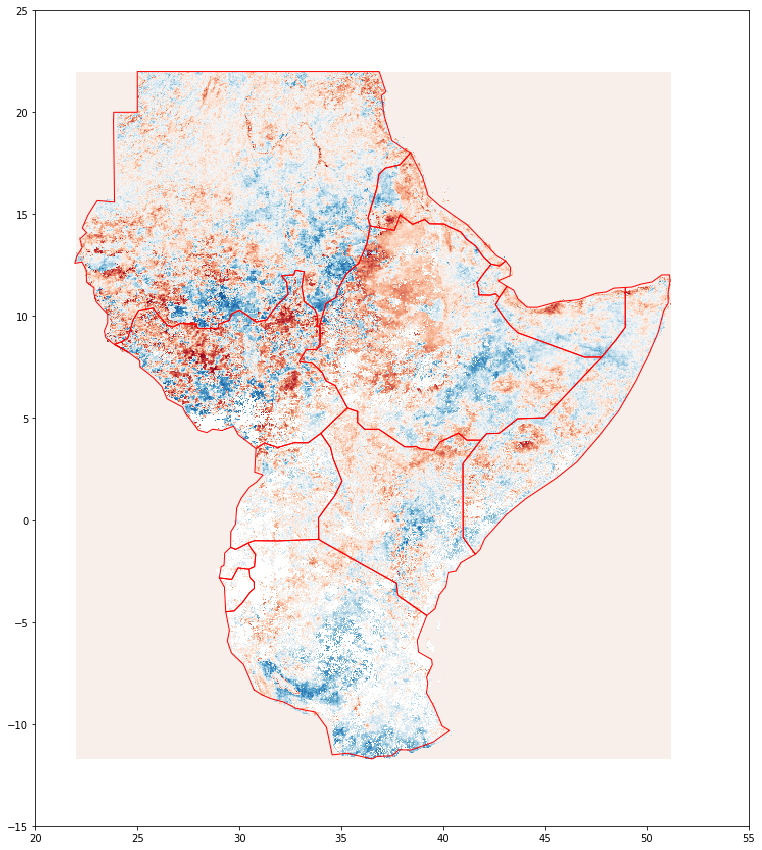

In [482]:
fig, ax = plt.subplots(figsize=(15,15))

show(ndvi_eastafrica_simplex_multi_ond, ax=ax, cmap = 'RdBu')
#show(ond_ndvi_uni, ax=ax, cmap = 'RdBu')


#zoom into East Africa
EastAfrica_basemap.plot(ax=ax, facecolor='none', edgecolor='red')
plt.axis([20, 55,-15,25])


In [ ]:
# raster_list = [temp_eastafrica_simplex_crop_tif, precip_eastafrica_simplex_crop_tif, ndvi_eastafrica_simplex_crop_tif]
# var_list = ['Temperature', 'Precipitation', 'NDVI']

# fig, axs = plt.subplots(1, 3, figsize = (30, 20))
# axs = axs.ravel()
# fig.subplots_adjust(wspace= 0.25, hspace = 0.35)
# fig = plt.gcf()
# for i, raster in enumerate(raster_list):
#     show(raster, ax=axs[i], cmap = 'Blues')
    
    
#     EastAfrica_basemap.plot(ax=axs[i], facecolor='none', edgecolor='darkblue', vmin = 0, vmax = 1)
    
#     axs[i].set_title(var_list[i], fontsize = 25)
    
# plt.savefig('/home/rgreen/ea_simplex_3panel.png', dpi = 300)

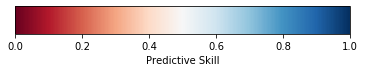

In [ ]:
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
cmap = mpl.cm.RdBu
norm = mpl.colors.Normalize(vmin=0, vmax=1)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal', label='Predictive Skill')  

plt.savefig('/home/rgreen/colorbar_bugr', dpi = 300)

# 4. Embedding Dimension Spatial Sensitivity 
use Embed Dimension function

In [ ]:
embed_result = EmbedDimension(dataFrame = table, 
                                      lib = train, pred = test, columns = column, showPlot = False)
        max_embed = embed_result.iloc[embed_result['rho'].idxmax()][0]
        print(max_embed)

In [ ]:
def pixelwise_embed_dimension(table, train, test, rs_rows, rs_cols):
    


    embed_max_df = []
    #table_chunk = table.loc[:100,500:510]
    
    for column in tqdm(table):
#         #print(column)
        if table[column].isnull().values.any():
            #print('null')
            embed_max_df.append(np.nan)
        else:
            interim_df = pd.DataFrame({'Time': list(range(0,522)), 'Data': table[column]}) #'Time': dekads
            embed_result = EmbedDimension(dataFrame = interim_df, 
                                      lib = train, pred = test, columns = 'Data', target = 'Data', showPlot = False)
            max_embed = embed_result.iloc[embed_result['rho'].idxmax()][0]
            
            #simplex_result = Simplex(dataFrame = interim_df, lib = train, pred = test, E = ed, Tp = pi, 
                                     #columns = 'Data', target = 'Data', showPlot = False)
#             error = ComputeError(list(simplex_result.Observations), list(simplex_result.Predictions))
#             MAE = list(error.values())[0]
#             RMSE = list(error.values())[1]
#             rho = list(error.values())[2]
           
            embed_max_df.append(max_embed) #adjust measure depending on output interest
            
    return(np.reshape(embed_max_df, (rs_rows,rs_cols)))
            

In [ ]:
ndvi_africa_ed = pixelwise_embed_dimension(ndvi_table, '1 100', '101 522', 800, 730)